# Goals of project

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

# Data Loading

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import warnings
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
%matplotlib inline

# Find and store all of the image paths for vehicles and non-vehicles seperatly
cars = glob.glob('data/vehicles/*/*.png')
notcars = glob.glob('data/non-vehicles/*/*.png')

print("Number of Vehicle Images found: " + str(len(cars)))
print("Number of Non-Vehicle Images found: " + str(len(notcars)))

Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 8968


# Data Exploration

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


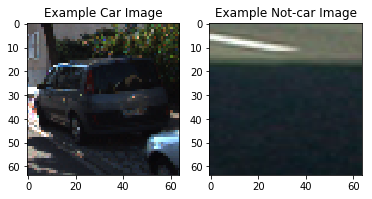

In [2]:
# Takes in a list of car and non-car image paths and returns some information about them
def dataExplore(car_list, notcar_list):
    data_dict = {}
     # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    testImg = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = testImg.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = testImg.dtype
    # Return data_dict
    return data_dict

data_info = dataExplore(cars, notcars)
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')


# Histogram of Gradient Feature Extraction

(31, 31, 2, 2, 9)
34596


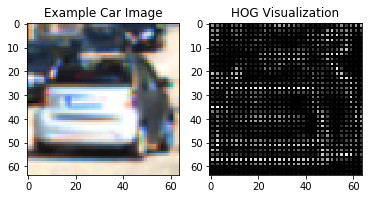

In [3]:
from skimage.feature import hog

# Takes in the image, number of orientation bins, pixels per cell (x,y), cells per block (row,col), visualisation flag, feature vector flag, and returns HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell,pix_per_cell), 
                                  cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orient, pixels_per_cell=(pix_per_cell,pix_per_cell), cells_per_block=(cell_per_block,cell_per_block), transform_sqrt=False, visualise=False, feature_vector=feature_vec)
        return features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))

# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 2
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2]*features.shape[3]*features.shape[4])
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


# HIstogram of Color

In [4]:
# Takes the image, number of bins,the range, and returns a feature vector
def get_color_hist_features(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Binned Color Feature

In [5]:
# Takes the image and size and returns a feature vector of the resized image that is flatten into a 1d array
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    # Return the feature vector
    return np.hstack((color1, color2, color3))

# Normalize

# Data Preperation

# Sliding Window

In [6]:
# Takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Box Drawing

In [7]:
# Takes in an image, a list of box corner cordinates, color, line thickness, and 
# returns the image with boxes drawn on them
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Sliding Window Example

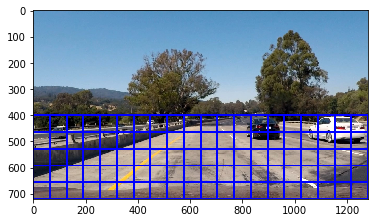

In [8]:
image = mpimg.imread('test_images/test1.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

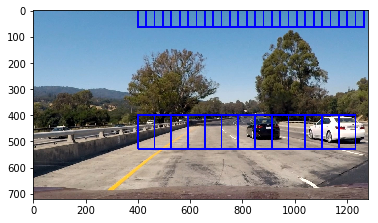

In [9]:
image = mpimg.imread('test_images/test1.jpg')
windows1 = slide_window(image, x_start_stop=[400, None], y_start_stop=[400, 528], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
windows2 = slide_window(image, x_start_stop=[400, None], y_start_stop=[None, 64], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

windows = windows1 + windows2
# windows = windows2
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

In [10]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Feature Extraction

In [11]:

orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32, 32)
hist_bins = 32



# Takes in a list of all of the images, color space, parameters for the hog function, and returns the feature
# vector for all the images
def extract_features(imgs, cspace='RGB',spatial_size=(32,32), hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL', spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    
    
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        ################
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            #Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        #####################
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            #Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [12]:
def single_img_features(img, color_space='RGB', spatial_size=(32,32),
                        hist_bins = 32, orient = 9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):
    global hog_image
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size = spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7)Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel =='ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient,
                                                          pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient,
                                                          pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)
        
        
            
    

# Searching for Cars

In [13]:
# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32,32), hist_bins=32,
                   hist_range=(0,256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    #1) Create an empty list to recieve postive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3 Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64,64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space = color_space,
                            spatial_size = spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

        #5) Scale extraced features to be fed to classifier
        reshaped_features = np.array(features).reshape(1,-1)
        test_features = scaler.transform(reshaped_features)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Retrun windows for positive detections
    return on_windows
                                  
# Define a funciton for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])
        

# Example of pipeline

number of features: 23880


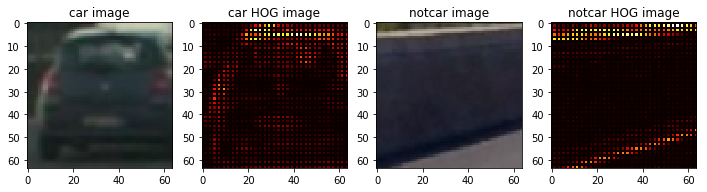

In [14]:

# Choose a random car / not-car indices
car_ind = np.random.random_integers(0, (len(cars)-1))
notcar_ind = np.random.random_integers(0, (len(notcars)-1))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6
pix_per_cell = 2
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins = hist_bins, orient = orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins = hist_bins, orient = orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize=(12,6))#, dpi=80)
visualize(fig, 1, 4, images, titles)
print('number of features: ' + str(car_features.shape[0]))



# Training (Only run this cell if you don't have the files clf.pkl or features.pkl

In [ ]:
# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
n_samples = 1000
random_idxs =  np.random.random_integers(0,len(cars), n_samples)
test_cars = cars#np.array(cars)[random_idxs]
test_notcars = notcars#np.array(notcars)[random_idxs]

car_features = extract_features(test_cars, cspace=color_space,spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(test_notcars, cspace=color_space,spatial_size=spatial_size,
                                   hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
features = [car_features, notcar_features]
print(time.time()-t, 'Seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# Save the Model
from sklearn.externals import joblib
joblib.dump(svc, 'clf.pkl')
joblib.dump(features, 'features.pkl')
print('done')

# Load in Model (only run the 2 cells below if you didn't run the training cell above)

In [15]:
from sklearn.externals import joblib
clf = joblib.load('clf.pkl')
#features[0] = car_features, features[1] = notcar_features
features = joblib.load('features.pkl')
car_features = features[0]
notcar_features = features[1]

In [16]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print(clf)
svc = clf
print(len(features[1]))

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
8968


# Pipeline Test on  test_images

In [17]:
# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

searchpath = 'test_images/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
overlap = 0.5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    print(np.min(img), np.max(img))

    windows = slide_window(img, x_start_stop=[400, None], y_start_stop=y_start_stop,
                           xy_window=(96,96), xy_overlap=(overlap, overlap)) 
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space = color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_img, hot_windows, color=(0,0,255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, 'seconds to process one image searching', len(windows), 'windows')
fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)

0.0 1.0
0.4855167865753174 seconds to process one image searching 68 windows
0.0 1.0
0.2937808036804199 seconds to process one image searching 68 windows
0.0 1.0
0.2877655029296875 seconds to process one image searching 68 windows
0.0 1.0
0.31383395195007324 seconds to process one image searching 68 windows
0.0 1.0
0.298292875289917 seconds to process one image searching 68 windows
0.0 1.0
0.2907741069793701 seconds to process one image searching 68 windows


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# Sub-Sambling a Single Gradient Extraction

In [18]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Heat Map Example

0.3082923889160156 seconds to run, total windows =  294
0.3128318786621094 seconds to run, total windows =  294
0.3083200454711914 seconds to run, total windows =  294
0.31784486770629883 seconds to run, total windows =  294
0.31082606315612793 seconds to run, total windows =  294
0.3093225955963135 seconds to run, total windows =  294


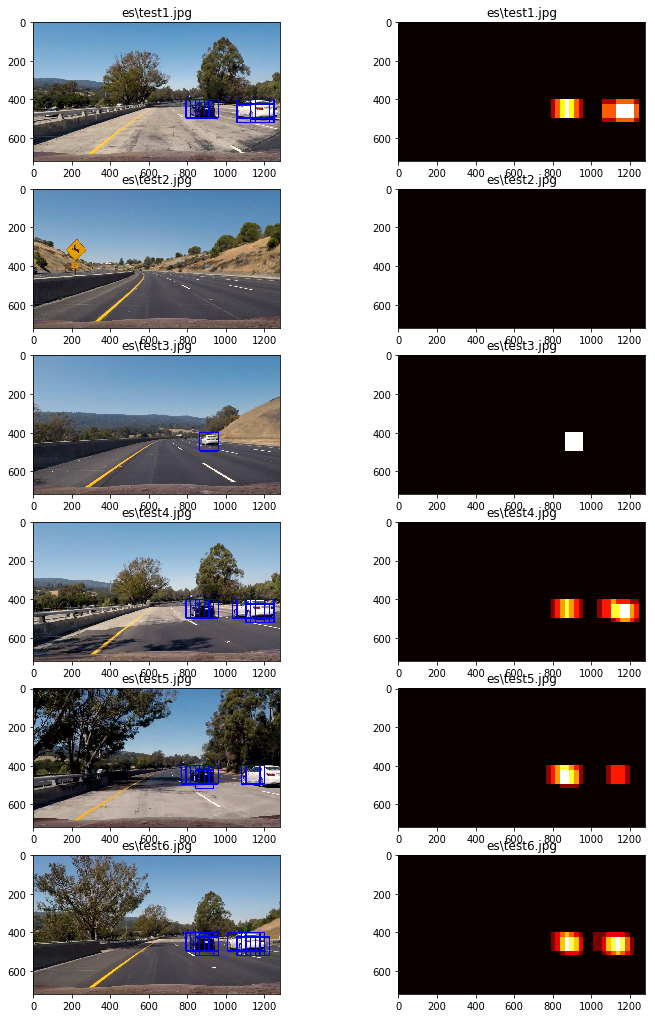

In [20]:
out_images = []
out_maps = []
out_titles = []
out_boxes = []
# Consider a narrower swath in y
xstart = 0
ystart = 400
ystop = 656
scale = 1.5
# Iterate over test images
for img_src in example_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
#     nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
#     nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = get_color_hist_features(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6) 
                img_boxes.append(((xbox_left+xstart, ytop_draw+ystart), (xbox_left+win_draw+xstart, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left+xstart:xbox_left+win_draw+xstart] += 1
        
    print(time.time()-t,'seconds to run, total windows = ', count)

    out_images.append(draw_img)

    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])
    #heatmap = 255*heatmap/np.max(heatmap)
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
        
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)
    
        
    
    

# Main Function find_cars()

In [21]:
# Define a single function that can extract features using hog sub-sampling and make predictions
# ystart, ystop, scale, svc = svc, X_scaler = X_scaler, orient = orient, pix_per_cell = pix_per_cell, cell_per_block = cell_per_block, spatial_size = spatial_size, hist_bins = hist_bins
def find_cars(img_boxes, img, ystart, ystop, xstart, xstop, scale, svc = svc, X_scaler = X_scaler, 
              orient = orient, pix_per_cell = pix_per_cell, 
              cell_per_block = cell_per_block, spatial_size = spatial_size, hist_bins = hist_bins):
    
    
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
#     nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
#     nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = get_color_hist_features(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,0,255),6) 
                img_boxes.append(((xbox_left+xstart, ytop_draw+ystart), (xbox_left+win_draw+xstart, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left+xstart:xbox_left+win_draw+xstart] += 1

    return draw_img, heatmap, img_boxes


def find_cars_with_multi_scales(img_boxes, img, ystart, ystop, xstart, xstop, scales, svc = svc, X_scaler = X_scaler, 
              orient = orient, pix_per_cell = pix_per_cell, 
              cell_per_block = cell_per_block, spatial_size = spatial_size, hist_bins = hist_bins):
    final_heatmap = np.zeros_like(img[:,:,0])
    draw_images = []
    box_coord = []
    for scale in scales:
        print(scale)
        draw_img, heatmap, box_coord_result = find_cars(img_boxes, img, ystart, ystop, xstart, xstop, scale)
        final_heatmap += heatmap
        draw_images.append(draw_img)
        box_coord.append(box_coord_result)
    
    #This is a little trick in order to get rid of the extra container that is wrapped around box_coord
    box_coord = box_coord[0]
    drawing = draw_boxes(img, box_coord, color=(0, 0, 255), thick=6)
    return drawing, final_heatmap, box_coord

1.0
1.5
2.0


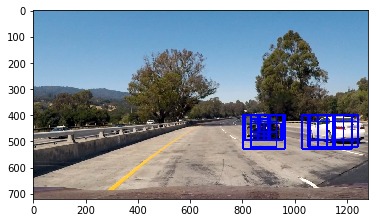

In [25]:
xstart = 450 #350
xstop = 1280 #1280
ystart = 400 #400
ystop = 656 #656
scale1 = 1.0 # 64x64
scale2 = 1.5 # 96x96
scale3 = 2.0 # 128x128
scales = [scale1, scale2, scale3]
scales_test = [1.5]
box_coord = []
image = mpimg.imread('test_images/test1.jpg')

drawing2, final_heatmap, bbox_result = find_cars_with_multi_scales(box_coord, image, ystart, ystop, xstart, xstop, scales)
plt.imshow(drawing2)

# Example of using the Find cars fucntion using multiple scales

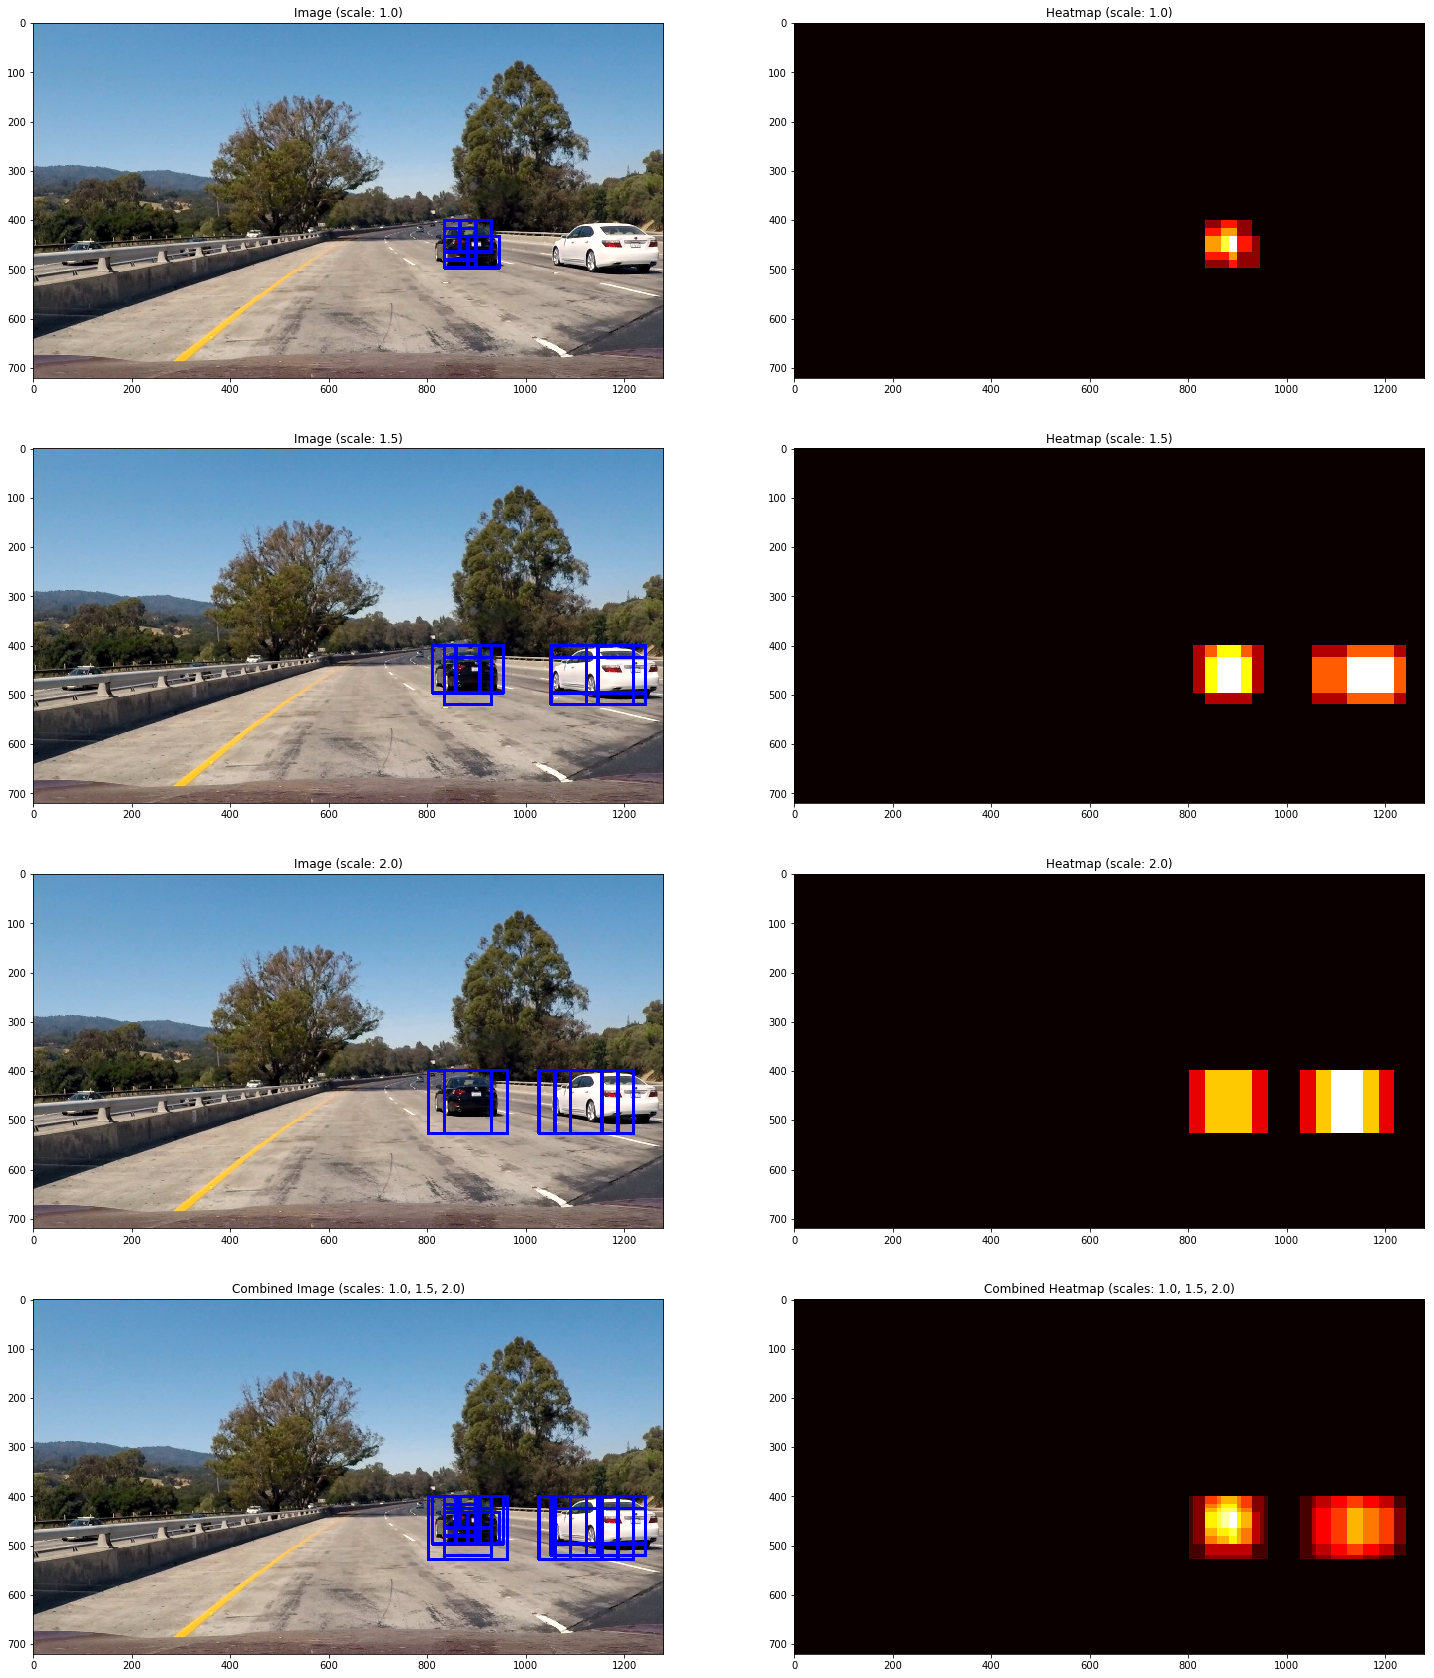

In [26]:
xstart = 450 #350
xstop = 1280 #1280
ystart = 400 #400
ystop = 656 #656
scale1 = 1.0 # 64x64
scale2 = 1.5 # 96x96
scale3 = 2.0 # 128x128
scales = [scale1, scale2, scale3]
box_coord = []
image = mpimg.imread('test_images/test1.jpg')

final_heatmap = np.zeros_like(image[:,:,0])

#First exctract features using the first scale 64x64 windows
draw_img1, heatmap1, box_coord_result1 = find_cars(box_coord, image, ystart, ystop, xstart, xstop, scale1)
# Reset box_coord beacuse the function has modified it (This is mainly for readability)
box_coord = []

#First exctract features using the first scale 96x96 windows
draw_img2, heatmap2, box_coord_result2 = find_cars(box_coord, image, ystart, ystop, xstart, xstop, scale2)
box_coord = []

#First exctract features using the first scale 128x128 windows
draw_img3, heatmap3, box_coord_result3 = find_cars(box_coord, image, ystart, ystop, xstart, xstop, scale3)

final_bbox = box_coord_result1 + box_coord_result2 + box_coord_result3

drawing = draw_boxes(image, final_bbox, color=(0, 0, 255), thick=6)

# drawing = draw_boxes(image, final_bbox, color=(0, 0, 255), thick=6)

final_heatmap  = heatmap1 + heatmap2 + heatmap3

images = [draw_img1, heatmap1, draw_img2, heatmap2, draw_img3, heatmap3, drawing, final_heatmap]
titles = ['Image (scale: 1.0)', 'Heatmap (scale: 1.0)','Image (scale: 1.5)', 'Heatmap (scale: 1.5)','Image (scale: 2.0)', 'Heatmap (scale: 2.0)', 'Combined Image (scales: 1.0, 1.5, 2.0)', 'Combined Heatmap (scales: 1.0, 1.5, 2.0)']

fig = plt.figure(figsize=(25,30))#, dpi=80)
vis = visualize(fig, 4, 2, images, titles)

In [27]:
# print(final_bbox) 
# print()
# print(bbox_result)
final_bbox == bbox_result

True

# Vehicle Object

In [28]:
# Define a class to recieve the characteristics of each vehicle detection
# Objects defined as "Vehicles" will be where multiple overlapping detections exist in the heatmap
class Vehicle():
    def __init__(self, position):
        self.position = position
        self.n_positions = [self.position]
        self.position_avg = self.position
        self.detected = False # was the Vehicle detected in the last iteration?
        self.n_detections = 1 # Number of times this vehicle has been in a row?
        self.n_nondetections = 0 # Number of consecutive times this car has not been detected.
        self.xpixels = (self.position[0][0], self.position[1][0]) # Pixel x values of last detection
        self.ypixels = (self.position[0][1], self.position[1][1]) # pixel y values of last detection
        self.recent_xfitted = [self.xpixels] # x position of the last n fits of the bounding box
        self.bestx = self.xpixels # average x position of the last n fits
        self.recent_yfitted = [self.ypixels] # y position of the last n fits of the bounding box
        self.besty = self.ypixels # average y position of the last n fits
        self.recent_wfitted = [abs(self.xpixels[0] - self.xpixels[1])] # width of the last n fits of the bounding box
        self.bestw = self.recent_wfitted # average width of the last n fits
        self.recent_hfitted = [abs(self.ypixels[0] - self.ypixels[1])] # height of the last n fits of the bounding box
        self.besth = self.recent_hfitted # average height of the last n fits
    
    def set_detection_to_false(self):
        self.detected = False
        return
    def incriment_det(self):
        if self.detected == False:
            self.n_nondetections += 1
            self.n_detections = 0
        return
            
    def reset_avg(self):
        if self.n_nondetections > 3:
            self.n_positions = []
        return
    # Optional TODO: Change the name of the function to better match what it does
    def is_this_position_new(self, unassociatedPos):
        # Check to see if the possible position is close enough to this cars positon
        #memory_frame_length is used to keep track of how far back (in terms of frames) does the average take
        memory_frame_size = 16
        # Optional TODO: create a smarter way of checking if this position belongs to this car
        if abs(unassociatedPos[1][0] - self.position[1][0]) < 100 and abs(unassociatedPos[1][1] - self.position[1][1]) < 100:
            self.position = unassociatedPos
            if self.detected == True:
                self.n_detections += 1
            self.detected = True
            if len(self.n_positions) > memory_frame_size:
                self.n_positions.pop(0)
                self.n_positions.append(self.position)
            else:
                self.n_positions.append(self.position)
            
            # Return false signifying that we have not found a new car but rather updated an old car's info
            return False
        else:
            # Return True signifying that this bounding box does not corrispond to this car
            return True
    
        
    def is_car_in_frame(self):
        #Is this car still visiable ?
        # If you haven't seen the car for 4 frames forget about it
        threshold_car_hasnt_showed = 30
        if self.detected == True or self.n_nondetections < threshold_car_hasnt_showed :
            return True
        self.n_positions = []
        return False
    
    def draw(self):
        return np.mean(np.array(self.n_positions), axis=0).astype(int)
    

# Use the cell below to reset the memory

In [29]:
global Cars_List
Cars_List = []
global count
count = 0

# Heatmap Threshold and Draw

In [30]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
def draw_labeled_bboxes(img, labels, applySmoothing = True):
    global count
    count += 1
    print("Frame number: " + str(count))
    # Iterate through all detected cars
    # draw_labeled_bboxes gets called on every frame so each instance represents one frame
    for car in Cars_List:
    # Reset all of the detected variables for each car to false since 
    # we don't know if we will see the car in this iteration
        car.set_detection_to_false()
# 1st: Get the bounding boxes for the new detections
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        # Check to see if this is a new car and if it is then add it to the list Cars_List
# 2nd: update any previous cars or append new cars to the list        
        if applySmoothing:
            newCar = True
            # For each vehicle object check to see if we have found this car already
            for car in Cars_List:
                newCar = car.is_this_position_new(bbox)
                if newCar == False:
                    break
            if newCar:
                # Add the car for the fist time as a new car
                Cars_List.append(Vehicle(bbox))
                location = bbox
# 3rd: update position of cars
            for car in Cars_List:
#                 print(len(car.n_positions))
                # incriment non detections for cars that were not detected
                car.incriment_det()
                # Check to see if the average needs to be reset
#                 car.reset_avg()
                flag = car.is_car_in_frame()
                if flag:
                    position = car.draw()
                    cv2.rectangle(img, (position[0][0], position[0][1]), (position[1][0], position[1][1]), (255, 0, 0), thickness=6)
        else:
            cv2.rectangle(img, bbox[0], bbox[1], (255, 0, 0), thickness=6)
    print("-------------------------------------------------------------------------------------")
    return img

1.0
1.5
2.0
Frame number: 1
-------------------------------------------------------------------------------------
1.0
1.5
2.0
Frame number: 2
-------------------------------------------------------------------------------------
1.0
1.5
2.0
Frame number: 3
-------------------------------------------------------------------------------------
1.0
1.5
2.0
Frame number: 4
-------------------------------------------------------------------------------------
1.0
1.5
2.0
Frame number: 5
-------------------------------------------------------------------------------------
1.0
1.5
2.0
Frame number: 6
-------------------------------------------------------------------------------------


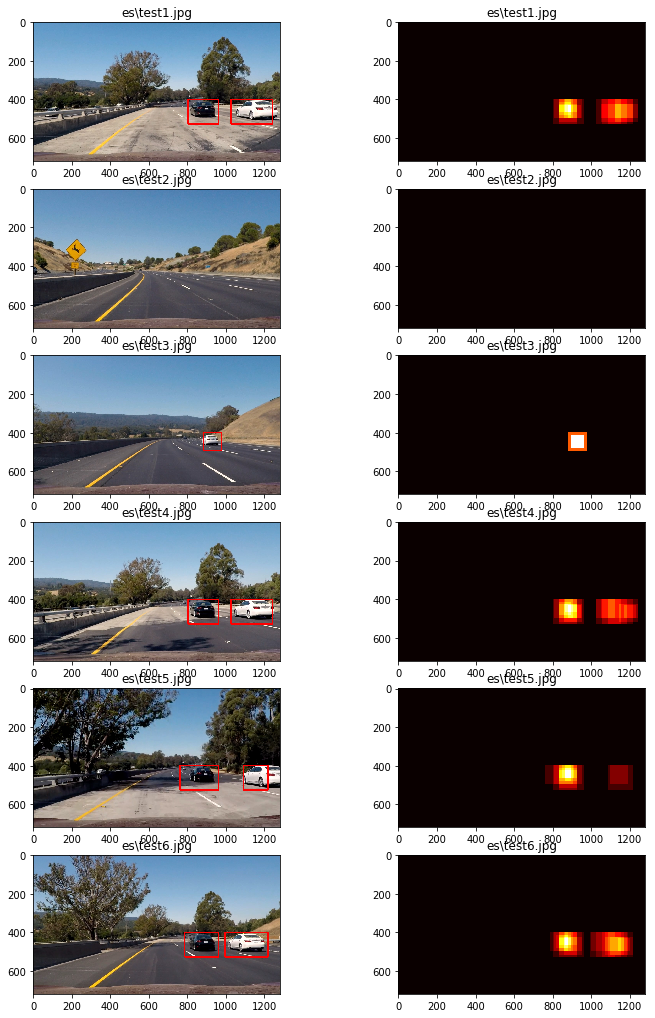

In [32]:
out_images =[]
out_maps = []
box_cord = []
xstart = 450 #350
xstop = 1280 #1280 
ystart = 400
ystop = 656
scales = [1.0, 1.5, 2.0]
# Iterate over test images
for img_src in example_images:
    img = mpimg.imread(img_src)
    #TODO: change find_cars call
    out_img, heat_map, bbox_result = find_cars_with_multi_scales(box_coord, img, ystart, ystop, xstart, xstop, scales)
    labels = label(heat_map)
#     print(labels[1])
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels, False)
    out_images.append(draw_img)
    out_images.append(heat_map)
    
fig = plt.figure(figsize=(12,24))
visualize(fig, 8, 2, out_images, out_titles)

In [33]:
print(len(Cars_List))

0


In [34]:
def process_image(img):
    #TODO: Change function call
    out_img, heat_map, bbox_result = find_cars_with_multi_scales(box_coord, img, ystart, ystop, xstart, xstop, scales)
    thresholded_heat_map = apply_threshold(heat_map, 1)
    labels = label(thresholded_heat_map)
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels, True)
    return draw_img
    

# Video Feed

In [35]:
## Load the video 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'output_vid.mp4'
# clip = VideoFileClip("test_video.mp4")
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image)
#%time
%time test_clip.write_videofile(test_output, audio=False) 


1.0
1.5
2.0
Frame number: 7
-------------------------------------------------------------------------------------
[MoviePy] >>>> Building video output_vid.mp4
[MoviePy] Writing video output_vid.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

1.0
1.5
2.0
Frame number: 8
-------------------------------------------------------------------------------------


  0%|                                                                                 | 1/1261 [00:00<17:07,  1.23it/s]

1.0
1.5
2.0
Frame number: 9
-------------------------------------------------------------------------------------


  0%|▏                                                                                | 2/1261 [00:01<17:06,  1.23it/s]

1.0
1.5
2.0
Frame number: 10
-------------------------------------------------------------------------------------


  0%|▏                                                                                | 3/1261 [00:02<17:12,  1.22it/s]

1.0
1.5
2.0
Frame number: 11
-------------------------------------------------------------------------------------


  0%|▎                                                                                | 4/1261 [00:03<17:08,  1.22it/s]

1.0
1.5
2.0
Frame number: 12
-------------------------------------------------------------------------------------


  0%|▎                                                                                | 5/1261 [00:04<17:20,  1.21it/s]

1.0
1.5
2.0
Frame number: 13
-------------------------------------------------------------------------------------


  0%|▍                                                                                | 6/1261 [00:04<17:21,  1.21it/s]

1.0
1.5
2.0
Frame number: 14
-------------------------------------------------------------------------------------


  1%|▍                                                                                | 7/1261 [00:05<17:12,  1.21it/s]

1.0
1.5
2.0
Frame number: 15
-------------------------------------------------------------------------------------


  1%|▌                                                                                | 8/1261 [00:06<17:09,  1.22it/s]

1.0
1.5
2.0
Frame number: 16
-------------------------------------------------------------------------------------


  1%|▌                                                                                | 9/1261 [00:07<17:03,  1.22it/s]

1.0
1.5
2.0
Frame number: 17
-------------------------------------------------------------------------------------


  1%|▋                                                                               | 10/1261 [00:08<17:00,  1.23it/s]

1.0
1.5
2.0
Frame number: 18
-------------------------------------------------------------------------------------


  1%|▋                                                                               | 11/1261 [00:09<17:32,  1.19it/s]

1.0
1.5
2.0
Frame number: 19
-------------------------------------------------------------------------------------


  1%|▊                                                                               | 12/1261 [00:09<17:25,  1.20it/s]

1.0
1.5
2.0
Frame number: 20
-------------------------------------------------------------------------------------


  1%|▊                                                                               | 13/1261 [00:10<17:26,  1.19it/s]

1.0
1.5
2.0
Frame number: 21
-------------------------------------------------------------------------------------


  1%|▉                                                                               | 14/1261 [00:11<17:17,  1.20it/s]

1.0
1.5
2.0
Frame number: 22
-------------------------------------------------------------------------------------


  1%|▉                                                                               | 15/1261 [00:12<17:11,  1.21it/s]

1.0
1.5
2.0
Frame number: 23
-------------------------------------------------------------------------------------


  1%|█                                                                               | 16/1261 [00:13<17:06,  1.21it/s]

1.0
1.5
2.0
Frame number: 24
-------------------------------------------------------------------------------------


  1%|█                                                                               | 17/1261 [00:14<17:15,  1.20it/s]

1.0
1.5
2.0
Frame number: 25
-------------------------------------------------------------------------------------


  1%|█▏                                                                              | 18/1261 [00:14<17:10,  1.21it/s]

1.0
1.5
2.0
Frame number: 26
-------------------------------------------------------------------------------------


  2%|█▏                                                                              | 19/1261 [00:15<17:05,  1.21it/s]

1.0
1.5
2.0
Frame number: 27
-------------------------------------------------------------------------------------


  2%|█▎                                                                              | 20/1261 [00:16<17:04,  1.21it/s]

1.0
1.5
2.0
Frame number: 28
-------------------------------------------------------------------------------------


  2%|█▎                                                                              | 21/1261 [00:17<17:01,  1.21it/s]

1.0
1.5
2.0
Frame number: 29
-------------------------------------------------------------------------------------


  2%|█▍                                                                              | 22/1261 [00:18<17:01,  1.21it/s]

1.0
1.5
2.0
Frame number: 30
-------------------------------------------------------------------------------------


  2%|█▍                                                                              | 23/1261 [00:19<17:11,  1.20it/s]

1.0
1.5
2.0
Frame number: 31
-------------------------------------------------------------------------------------


  2%|█▌                                                                              | 24/1261 [00:19<17:13,  1.20it/s]

1.0
1.5
2.0
Frame number: 32
-------------------------------------------------------------------------------------


  2%|█▌                                                                              | 25/1261 [00:20<17:10,  1.20it/s]

1.0
1.5
2.0
Frame number: 33
-------------------------------------------------------------------------------------


  2%|█▋                                                                              | 26/1261 [00:21<17:06,  1.20it/s]

1.0
1.5
2.0
Frame number: 34
-------------------------------------------------------------------------------------


  2%|█▋                                                                              | 27/1261 [00:22<17:11,  1.20it/s]

1.0
1.5
2.0
Frame number: 35
-------------------------------------------------------------------------------------


  2%|█▊                                                                              | 28/1261 [00:23<17:08,  1.20it/s]

1.0
1.5
2.0
Frame number: 36
-------------------------------------------------------------------------------------


  2%|█▊                                                                              | 29/1261 [00:24<17:03,  1.20it/s]

1.0
1.5
2.0
Frame number: 37
-------------------------------------------------------------------------------------


  2%|█▉                                                                              | 30/1261 [00:24<16:57,  1.21it/s]

1.0
1.5
2.0
Frame number: 38
-------------------------------------------------------------------------------------


  2%|█▉                                                                              | 31/1261 [00:25<16:55,  1.21it/s]

1.0
1.5
2.0
Frame number: 39
-------------------------------------------------------------------------------------


  3%|██                                                                              | 32/1261 [00:26<17:07,  1.20it/s]

1.0
1.5
2.0
Frame number: 40
-------------------------------------------------------------------------------------


  3%|██                                                                              | 33/1261 [00:27<16:57,  1.21it/s]

1.0
1.5
2.0
Frame number: 41
-------------------------------------------------------------------------------------


  3%|██▏                                                                             | 34/1261 [00:28<16:49,  1.22it/s]

1.0
1.5
2.0
Frame number: 42
-------------------------------------------------------------------------------------


  3%|██▏                                                                             | 35/1261 [00:28<16:47,  1.22it/s]

1.0
1.5
2.0
Frame number: 43
-------------------------------------------------------------------------------------


  3%|██▎                                                                             | 36/1261 [00:29<16:47,  1.22it/s]

1.0
1.5
2.0
Frame number: 44
-------------------------------------------------------------------------------------


  3%|██▎                                                                             | 37/1261 [00:30<16:47,  1.22it/s]

1.0
1.5
2.0
Frame number: 45
-------------------------------------------------------------------------------------


  3%|██▍                                                                             | 38/1261 [00:31<16:44,  1.22it/s]

1.0
1.5
2.0
Frame number: 46
-------------------------------------------------------------------------------------


  3%|██▍                                                                             | 39/1261 [00:32<16:44,  1.22it/s]

1.0
1.5
2.0
Frame number: 47
-------------------------------------------------------------------------------------


  3%|██▌                                                                             | 40/1261 [00:33<16:39,  1.22it/s]

1.0
1.5
2.0
Frame number: 48
-------------------------------------------------------------------------------------


  3%|██▌                                                                             | 41/1261 [00:33<16:37,  1.22it/s]

1.0
1.5
2.0
Frame number: 49
-------------------------------------------------------------------------------------


  3%|██▋                                                                             | 42/1261 [00:34<16:40,  1.22it/s]

1.0
1.5
2.0
Frame number: 50
-------------------------------------------------------------------------------------


  3%|██▋                                                                             | 43/1261 [00:35<16:36,  1.22it/s]

1.0
1.5
2.0
Frame number: 51
-------------------------------------------------------------------------------------


  3%|██▊                                                                             | 44/1261 [00:36<16:38,  1.22it/s]

1.0
1.5
2.0
Frame number: 52
-------------------------------------------------------------------------------------


  4%|██▊                                                                             | 45/1261 [00:37<16:41,  1.21it/s]

1.0
1.5
2.0
Frame number: 53
-------------------------------------------------------------------------------------


  4%|██▉                                                                             | 46/1261 [00:38<17:22,  1.17it/s]

1.0
1.5
2.0
Frame number: 54
-------------------------------------------------------------------------------------


  4%|██▉                                                                             | 47/1261 [00:39<17:27,  1.16it/s]

1.0
1.5
2.0
Frame number: 55
-------------------------------------------------------------------------------------


  4%|███                                                                             | 48/1261 [00:39<17:34,  1.15it/s]

1.0
1.5
2.0
Frame number: 56
-------------------------------------------------------------------------------------


  4%|███                                                                             | 49/1261 [00:40<17:58,  1.12it/s]

1.0
1.5
2.0
Frame number: 57
-------------------------------------------------------------------------------------


  4%|███▏                                                                            | 50/1261 [00:41<18:15,  1.11it/s]

1.0
1.5
2.0
Frame number: 58
-------------------------------------------------------------------------------------


  4%|███▏                                                                            | 51/1261 [00:42<18:11,  1.11it/s]

1.0
1.5
2.0
Frame number: 59
-------------------------------------------------------------------------------------


  4%|███▎                                                                            | 52/1261 [00:43<17:41,  1.14it/s]

1.0
1.5
2.0
Frame number: 60
-------------------------------------------------------------------------------------


  4%|███▎                                                                            | 53/1261 [00:44<17:16,  1.17it/s]

1.0
1.5
2.0
Frame number: 61
-------------------------------------------------------------------------------------


  4%|███▍                                                                            | 54/1261 [00:45<17:17,  1.16it/s]

1.0
1.5
2.0
Frame number: 62
-------------------------------------------------------------------------------------


  4%|███▍                                                                            | 55/1261 [00:46<17:17,  1.16it/s]

1.0
1.5
2.0
Frame number: 63
-------------------------------------------------------------------------------------


  4%|███▌                                                                            | 56/1261 [00:46<17:15,  1.16it/s]

1.0
1.5
2.0
Frame number: 64
-------------------------------------------------------------------------------------


  5%|███▌                                                                            | 57/1261 [00:47<17:24,  1.15it/s]

1.0
1.5
2.0
Frame number: 65
-------------------------------------------------------------------------------------


  5%|███▋                                                                            | 58/1261 [00:48<17:36,  1.14it/s]

1.0
1.5
2.0
Frame number: 66
-------------------------------------------------------------------------------------


  5%|███▋                                                                            | 59/1261 [00:49<17:20,  1.15it/s]

1.0
1.5
2.0
Frame number: 67
-------------------------------------------------------------------------------------


  5%|███▊                                                                            | 60/1261 [00:50<17:09,  1.17it/s]

1.0
1.5
2.0
Frame number: 68
-------------------------------------------------------------------------------------


  5%|███▊                                                                            | 61/1261 [00:51<16:54,  1.18it/s]

1.0
1.5
2.0
Frame number: 69
-------------------------------------------------------------------------------------


  5%|███▉                                                                            | 62/1261 [00:51<16:43,  1.19it/s]

1.0
1.5
2.0
Frame number: 70
-------------------------------------------------------------------------------------


  5%|███▉                                                                            | 63/1261 [00:52<16:37,  1.20it/s]

1.0
1.5
2.0
Frame number: 71
-------------------------------------------------------------------------------------


  5%|████                                                                            | 64/1261 [00:53<16:36,  1.20it/s]

1.0
1.5
2.0
Frame number: 72
-------------------------------------------------------------------------------------


  5%|████                                                                            | 65/1261 [00:54<16:35,  1.20it/s]

1.0
1.5
2.0
Frame number: 73
-------------------------------------------------------------------------------------


  5%|████▏                                                                           | 66/1261 [00:55<16:29,  1.21it/s]

1.0
1.5
2.0
Frame number: 74
-------------------------------------------------------------------------------------


  5%|████▎                                                                           | 67/1261 [00:56<16:24,  1.21it/s]

1.0
1.5
2.0
Frame number: 75
-------------------------------------------------------------------------------------


  5%|████▎                                                                           | 68/1261 [00:56<16:24,  1.21it/s]

1.0
1.5
2.0
Frame number: 76
-------------------------------------------------------------------------------------


  5%|████▍                                                                           | 69/1261 [00:57<16:20,  1.22it/s]

1.0
1.5
2.0
Frame number: 77
-------------------------------------------------------------------------------------


  6%|████▍                                                                           | 70/1261 [00:58<16:22,  1.21it/s]

1.0
1.5
2.0
Frame number: 78
-------------------------------------------------------------------------------------


  6%|████▌                                                                           | 71/1261 [00:59<16:15,  1.22it/s]

1.0
1.5
2.0
Frame number: 79
-------------------------------------------------------------------------------------


  6%|████▌                                                                           | 72/1261 [01:00<16:17,  1.22it/s]

1.0
1.5
2.0
Frame number: 80
-------------------------------------------------------------------------------------


  6%|████▋                                                                           | 73/1261 [01:01<16:34,  1.19it/s]

1.0
1.5
2.0
Frame number: 81
-------------------------------------------------------------------------------------


  6%|████▋                                                                           | 74/1261 [01:01<16:35,  1.19it/s]

1.0
1.5
2.0
Frame number: 82
-------------------------------------------------------------------------------------


  6%|████▊                                                                           | 75/1261 [01:02<16:45,  1.18it/s]

1.0
1.5
2.0
Frame number: 83
-------------------------------------------------------------------------------------


  6%|████▊                                                                           | 76/1261 [01:03<16:33,  1.19it/s]

1.0
1.5
2.0
Frame number: 84
-------------------------------------------------------------------------------------


  6%|████▉                                                                           | 77/1261 [01:04<16:27,  1.20it/s]

1.0
1.5
2.0
Frame number: 85
-------------------------------------------------------------------------------------


  6%|████▉                                                                           | 78/1261 [01:05<16:28,  1.20it/s]

1.0
1.5
2.0
Frame number: 86
-------------------------------------------------------------------------------------


  6%|█████                                                                           | 79/1261 [01:06<16:40,  1.18it/s]

1.0
1.5
2.0
Frame number: 87
-------------------------------------------------------------------------------------


  6%|█████                                                                           | 80/1261 [01:07<17:23,  1.13it/s]

1.0
1.5
2.0
Frame number: 88
-------------------------------------------------------------------------------------


  6%|█████▏                                                                          | 81/1261 [01:07<17:18,  1.14it/s]

1.0
1.5
2.0
Frame number: 89
-------------------------------------------------------------------------------------


  7%|█████▏                                                                          | 82/1261 [01:08<17:46,  1.11it/s]

1.0
1.5
2.0
Frame number: 90
-------------------------------------------------------------------------------------


  7%|█████▎                                                                          | 83/1261 [01:09<18:00,  1.09it/s]

1.0
1.5
2.0
Frame number: 91
-------------------------------------------------------------------------------------


  7%|█████▎                                                                          | 84/1261 [01:10<17:57,  1.09it/s]

1.0
1.5
2.0
Frame number: 92
-------------------------------------------------------------------------------------


  7%|█████▍                                                                          | 85/1261 [01:11<18:28,  1.06it/s]

1.0
1.5
2.0
Frame number: 93
-------------------------------------------------------------------------------------


  7%|█████▍                                                                          | 86/1261 [01:12<18:35,  1.05it/s]

1.0
1.5
2.0
Frame number: 94
-------------------------------------------------------------------------------------


  7%|█████▌                                                                          | 87/1261 [01:13<18:52,  1.04it/s]

1.0
1.5
2.0
Frame number: 95
-------------------------------------------------------------------------------------


  7%|█████▌                                                                          | 88/1261 [01:14<18:14,  1.07it/s]

1.0
1.5
2.0
Frame number: 96
-------------------------------------------------------------------------------------


  7%|█████▋                                                                          | 89/1261 [01:15<17:36,  1.11it/s]

1.0
1.5
2.0
Frame number: 97
-------------------------------------------------------------------------------------


  7%|█████▋                                                                          | 90/1261 [01:16<17:36,  1.11it/s]

1.0
1.5
2.0
Frame number: 98
-------------------------------------------------------------------------------------


  7%|█████▊                                                                          | 91/1261 [01:17<17:13,  1.13it/s]

1.0
1.5
2.0
Frame number: 99
-------------------------------------------------------------------------------------


  7%|█████▊                                                                          | 92/1261 [01:18<17:11,  1.13it/s]

1.0
1.5
2.0
Frame number: 100
-------------------------------------------------------------------------------------


  7%|█████▉                                                                          | 93/1261 [01:18<17:05,  1.14it/s]

1.0
1.5
2.0
Frame number: 101
-------------------------------------------------------------------------------------


  7%|█████▉                                                                          | 94/1261 [01:19<16:58,  1.15it/s]

1.0
1.5
2.0
Frame number: 102
-------------------------------------------------------------------------------------


  8%|██████                                                                          | 95/1261 [01:20<16:57,  1.15it/s]

1.0
1.5
2.0
Frame number: 103
-------------------------------------------------------------------------------------


  8%|██████                                                                          | 96/1261 [01:21<16:56,  1.15it/s]

1.0
1.5
2.0
Frame number: 104
-------------------------------------------------------------------------------------


  8%|██████▏                                                                         | 97/1261 [01:22<16:58,  1.14it/s]

1.0
1.5
2.0
Frame number: 105
-------------------------------------------------------------------------------------


  8%|██████▏                                                                         | 98/1261 [01:23<16:56,  1.14it/s]

1.0
1.5
2.0
Frame number: 106
-------------------------------------------------------------------------------------


  8%|██████▎                                                                         | 99/1261 [01:24<17:03,  1.14it/s]

1.0
1.5
2.0
Frame number: 107
-------------------------------------------------------------------------------------


  8%|██████▎                                                                        | 100/1261 [01:25<16:58,  1.14it/s]

1.0
1.5
2.0
Frame number: 108
-------------------------------------------------------------------------------------


  8%|██████▎                                                                        | 101/1261 [01:25<16:58,  1.14it/s]

1.0
1.5
2.0
Frame number: 109
-------------------------------------------------------------------------------------


  8%|██████▍                                                                        | 102/1261 [01:26<17:10,  1.12it/s]

1.0
1.5
2.0
Frame number: 110
-------------------------------------------------------------------------------------


  8%|██████▍                                                                        | 103/1261 [01:27<17:05,  1.13it/s]

1.0
1.5
2.0
Frame number: 111
-------------------------------------------------------------------------------------


  8%|██████▌                                                                        | 104/1261 [01:28<17:01,  1.13it/s]

1.0
1.5
2.0
Frame number: 112
-------------------------------------------------------------------------------------


  8%|██████▌                                                                        | 105/1261 [01:29<17:58,  1.07it/s]

1.0
1.5
2.0
Frame number: 113
-------------------------------------------------------------------------------------


  8%|██████▋                                                                        | 106/1261 [01:30<18:07,  1.06it/s]

1.0
1.5
2.0
Frame number: 114
-------------------------------------------------------------------------------------


  8%|██████▋                                                                        | 107/1261 [01:31<18:32,  1.04it/s]

1.0
1.5
2.0
Frame number: 115
-------------------------------------------------------------------------------------


  9%|██████▊                                                                        | 108/1261 [01:32<17:41,  1.09it/s]

1.0
1.5
2.0
Frame number: 116
-------------------------------------------------------------------------------------


  9%|██████▊                                                                        | 109/1261 [01:33<18:05,  1.06it/s]

1.0
1.5
2.0
Frame number: 117
-------------------------------------------------------------------------------------


  9%|██████▉                                                                        | 110/1261 [01:35<22:08,  1.15s/it]

1.0
1.5
2.0
Frame number: 118
-------------------------------------------------------------------------------------


  9%|██████▉                                                                        | 111/1261 [01:36<22:10,  1.16s/it]

1.0
1.5
2.0
Frame number: 119
-------------------------------------------------------------------------------------


  9%|███████                                                                        | 112/1261 [01:37<21:01,  1.10s/it]

1.0
1.5
2.0
Frame number: 120
-------------------------------------------------------------------------------------


  9%|███████                                                                        | 113/1261 [01:38<20:05,  1.05s/it]

1.0
1.5
2.0
Frame number: 121
-------------------------------------------------------------------------------------


  9%|███████▏                                                                       | 114/1261 [01:39<19:25,  1.02s/it]

1.0
1.5
2.0
Frame number: 122
-------------------------------------------------------------------------------------


  9%|███████▏                                                                       | 115/1261 [01:40<18:54,  1.01it/s]

1.0
1.5
2.0
Frame number: 123
-------------------------------------------------------------------------------------


  9%|███████▎                                                                       | 116/1261 [01:40<18:38,  1.02it/s]

1.0
1.5
2.0
Frame number: 124
-------------------------------------------------------------------------------------


  9%|███████▎                                                                       | 117/1261 [01:41<18:29,  1.03it/s]

1.0
1.5
2.0
Frame number: 125
-------------------------------------------------------------------------------------


  9%|███████▍                                                                       | 118/1261 [01:42<18:12,  1.05it/s]

1.0
1.5
2.0
Frame number: 126
-------------------------------------------------------------------------------------


  9%|███████▍                                                                       | 119/1261 [01:43<17:52,  1.06it/s]

1.0
1.5
2.0
Frame number: 127
-------------------------------------------------------------------------------------


 10%|███████▌                                                                       | 120/1261 [01:44<18:01,  1.05it/s]

1.0
1.5
2.0
Frame number: 128
-------------------------------------------------------------------------------------


 10%|███████▌                                                                       | 121/1261 [01:45<17:56,  1.06it/s]

1.0
1.5
2.0
Frame number: 129
-------------------------------------------------------------------------------------


 10%|███████▋                                                                       | 122/1261 [01:46<17:48,  1.07it/s]

1.0
1.5
2.0
Frame number: 130
-------------------------------------------------------------------------------------


 10%|███████▋                                                                       | 123/1261 [01:47<17:51,  1.06it/s]

1.0
1.5
2.0
Frame number: 131
-------------------------------------------------------------------------------------


 10%|███████▊                                                                       | 124/1261 [01:48<18:06,  1.05it/s]

1.0
1.5
2.0
Frame number: 132
-------------------------------------------------------------------------------------


 10%|███████▊                                                                       | 125/1261 [01:49<17:53,  1.06it/s]

1.0
1.5
2.0
Frame number: 133
-------------------------------------------------------------------------------------


 10%|███████▉                                                                       | 126/1261 [01:50<17:35,  1.08it/s]

1.0
1.5
2.0
Frame number: 134
-------------------------------------------------------------------------------------


 10%|███████▉                                                                       | 127/1261 [01:51<17:11,  1.10it/s]

1.0
1.5
2.0
Frame number: 135
-------------------------------------------------------------------------------------


 10%|████████                                                                       | 128/1261 [01:52<17:16,  1.09it/s]

1.0
1.5
2.0
Frame number: 136
-------------------------------------------------------------------------------------


 10%|████████                                                                       | 129/1261 [01:53<17:41,  1.07it/s]

1.0
1.5
2.0
Frame number: 137
-------------------------------------------------------------------------------------


 10%|████████▏                                                                      | 130/1261 [01:54<18:45,  1.00it/s]

1.0
1.5
2.0
Frame number: 138
-------------------------------------------------------------------------------------


 10%|████████▏                                                                      | 131/1261 [01:55<20:02,  1.06s/it]

1.0
1.5
2.0
Frame number: 139
-------------------------------------------------------------------------------------


 10%|████████▎                                                                      | 132/1261 [01:56<19:54,  1.06s/it]

1.0
1.5
2.0
Frame number: 140
-------------------------------------------------------------------------------------


 11%|████████▎                                                                      | 133/1261 [01:57<19:30,  1.04s/it]

1.0
1.5
2.0
Frame number: 141
-------------------------------------------------------------------------------------


 11%|████████▍                                                                      | 134/1261 [01:58<18:44,  1.00it/s]

1.0
1.5
2.0
Frame number: 142
-------------------------------------------------------------------------------------


 11%|████████▍                                                                      | 135/1261 [01:59<18:11,  1.03it/s]

1.0
1.5
2.0
Frame number: 143
-------------------------------------------------------------------------------------


 11%|████████▌                                                                      | 136/1261 [02:00<17:40,  1.06it/s]

1.0
1.5
2.0
Frame number: 144
-------------------------------------------------------------------------------------


 11%|████████▌                                                                      | 137/1261 [02:01<17:28,  1.07it/s]

1.0
1.5
2.0
Frame number: 145
-------------------------------------------------------------------------------------


 11%|████████▋                                                                      | 138/1261 [02:01<17:07,  1.09it/s]

1.0
1.5
2.0
Frame number: 146
-------------------------------------------------------------------------------------


 11%|████████▋                                                                      | 139/1261 [02:02<16:57,  1.10it/s]

1.0
1.5
2.0
Frame number: 147
-------------------------------------------------------------------------------------


 11%|████████▊                                                                      | 140/1261 [02:03<16:47,  1.11it/s]

1.0
1.5
2.0
Frame number: 148
-------------------------------------------------------------------------------------


 11%|████████▊                                                                      | 141/1261 [02:04<16:51,  1.11it/s]

1.0
1.5
2.0
Frame number: 149
-------------------------------------------------------------------------------------


 11%|████████▉                                                                      | 142/1261 [02:05<16:42,  1.12it/s]

1.0
1.5
2.0
Frame number: 150
-------------------------------------------------------------------------------------


 11%|████████▉                                                                      | 143/1261 [02:06<16:35,  1.12it/s]

1.0
1.5
2.0
Frame number: 151
-------------------------------------------------------------------------------------


 11%|█████████                                                                      | 144/1261 [02:07<16:30,  1.13it/s]

1.0
1.5
2.0
Frame number: 152
-------------------------------------------------------------------------------------


 11%|█████████                                                                      | 145/1261 [02:08<16:27,  1.13it/s]

1.0
1.5
2.0
Frame number: 153
-------------------------------------------------------------------------------------


 12%|█████████▏                                                                     | 146/1261 [02:09<16:30,  1.13it/s]

1.0
1.5
2.0
Frame number: 154
-------------------------------------------------------------------------------------


 12%|█████████▏                                                                     | 147/1261 [02:09<16:22,  1.13it/s]

1.0
1.5
2.0
Frame number: 155
-------------------------------------------------------------------------------------


 12%|█████████▎                                                                     | 148/1261 [02:10<16:22,  1.13it/s]

1.0
1.5
2.0
Frame number: 156
-------------------------------------------------------------------------------------


 12%|█████████▎                                                                     | 149/1261 [02:11<16:41,  1.11it/s]

1.0
1.5
2.0
Frame number: 157
-------------------------------------------------------------------------------------


 12%|█████████▍                                                                     | 150/1261 [02:12<16:54,  1.10it/s]

1.0
1.5
2.0
Frame number: 158
-------------------------------------------------------------------------------------


 12%|█████████▍                                                                     | 151/1261 [02:13<16:55,  1.09it/s]

1.0
1.5
2.0
Frame number: 159
-------------------------------------------------------------------------------------


 12%|█████████▌                                                                     | 152/1261 [02:14<17:23,  1.06it/s]

1.0
1.5
2.0
Frame number: 160
-------------------------------------------------------------------------------------


 12%|█████████▌                                                                     | 153/1261 [02:15<16:52,  1.09it/s]

1.0
1.5
2.0
Frame number: 161
-------------------------------------------------------------------------------------


 12%|█████████▋                                                                     | 154/1261 [02:16<17:21,  1.06it/s]

1.0
1.5
2.0
Frame number: 162
-------------------------------------------------------------------------------------


 12%|█████████▋                                                                     | 155/1261 [02:17<17:26,  1.06it/s]

1.0
1.5
2.0
Frame number: 163
-------------------------------------------------------------------------------------


 12%|█████████▊                                                                     | 156/1261 [02:18<17:18,  1.06it/s]

1.0
1.5
2.0
Frame number: 164
-------------------------------------------------------------------------------------


 12%|█████████▊                                                                     | 157/1261 [02:19<17:08,  1.07it/s]

1.0
1.5
2.0
Frame number: 165
-------------------------------------------------------------------------------------


 13%|█████████▉                                                                     | 158/1261 [02:20<17:08,  1.07it/s]

1.0
1.5
2.0
Frame number: 166
-------------------------------------------------------------------------------------


 13%|█████████▉                                                                     | 159/1261 [02:21<17:07,  1.07it/s]

1.0
1.5
2.0
Frame number: 167
-------------------------------------------------------------------------------------


 13%|██████████                                                                     | 160/1261 [02:22<16:56,  1.08it/s]

1.0
1.5
2.0
Frame number: 168
-------------------------------------------------------------------------------------


 13%|██████████                                                                     | 161/1261 [02:22<16:45,  1.09it/s]

1.0
1.5
2.0
Frame number: 169
-------------------------------------------------------------------------------------


 13%|██████████▏                                                                    | 162/1261 [02:23<16:38,  1.10it/s]

1.0
1.5
2.0
Frame number: 170
-------------------------------------------------------------------------------------


 13%|██████████▏                                                                    | 163/1261 [02:24<16:43,  1.09it/s]

1.0
1.5
2.0
Frame number: 171
-------------------------------------------------------------------------------------


 13%|██████████▎                                                                    | 164/1261 [02:25<16:36,  1.10it/s]

1.0
1.5
2.0
Frame number: 172
-------------------------------------------------------------------------------------


 13%|██████████▎                                                                    | 165/1261 [02:26<16:59,  1.08it/s]

1.0
1.5
2.0
Frame number: 173
-------------------------------------------------------------------------------------


 13%|██████████▍                                                                    | 166/1261 [02:27<16:45,  1.09it/s]

1.0
1.5
2.0
Frame number: 174
-------------------------------------------------------------------------------------


 13%|██████████▍                                                                    | 167/1261 [02:28<16:50,  1.08it/s]

1.0
1.5
2.0
Frame number: 175
-------------------------------------------------------------------------------------


 13%|██████████▌                                                                    | 168/1261 [02:29<17:07,  1.06it/s]

1.0
1.5
2.0
Frame number: 176
-------------------------------------------------------------------------------------


 13%|██████████▌                                                                    | 169/1261 [02:30<17:06,  1.06it/s]

1.0
1.5
2.0
Frame number: 177
-------------------------------------------------------------------------------------


 13%|██████████▋                                                                    | 170/1261 [02:31<17:15,  1.05it/s]

1.0
1.5
2.0
Frame number: 178
-------------------------------------------------------------------------------------


 14%|██████████▋                                                                    | 171/1261 [02:32<17:29,  1.04it/s]

1.0
1.5
2.0
Frame number: 179
-------------------------------------------------------------------------------------


 14%|██████████▊                                                                    | 172/1261 [02:33<17:24,  1.04it/s]

1.0
1.5
2.0
Frame number: 180
-------------------------------------------------------------------------------------


 14%|██████████▊                                                                    | 173/1261 [02:34<17:21,  1.05it/s]

1.0
1.5
2.0
Frame number: 181
-------------------------------------------------------------------------------------


 14%|██████████▉                                                                    | 174/1261 [02:35<17:30,  1.03it/s]

1.0
1.5
2.0
Frame number: 182
-------------------------------------------------------------------------------------


 14%|██████████▉                                                                    | 175/1261 [02:36<17:22,  1.04it/s]

1.0
1.5
2.0
Frame number: 183
-------------------------------------------------------------------------------------


 14%|███████████                                                                    | 176/1261 [02:37<17:06,  1.06it/s]

1.0
1.5
2.0
Frame number: 184
-------------------------------------------------------------------------------------


 14%|███████████                                                                    | 177/1261 [02:38<16:53,  1.07it/s]

1.0
1.5
2.0
Frame number: 185
-------------------------------------------------------------------------------------


 14%|███████████▏                                                                   | 178/1261 [02:38<16:47,  1.08it/s]

1.0
1.5
2.0
Frame number: 186
-------------------------------------------------------------------------------------


 14%|███████████▏                                                                   | 179/1261 [02:39<16:38,  1.08it/s]

1.0
1.5
2.0
Frame number: 187
-------------------------------------------------------------------------------------


 14%|███████████▎                                                                   | 180/1261 [02:40<16:39,  1.08it/s]

1.0
1.5
2.0
Frame number: 188
-------------------------------------------------------------------------------------


 14%|███████████▎                                                                   | 181/1261 [02:41<16:27,  1.09it/s]

1.0
1.5
2.0
Frame number: 189
-------------------------------------------------------------------------------------


 14%|███████████▍                                                                   | 182/1261 [02:42<16:24,  1.10it/s]

1.0
1.5
2.0
Frame number: 190
-------------------------------------------------------------------------------------


 15%|███████████▍                                                                   | 183/1261 [02:43<16:20,  1.10it/s]

1.0
1.5
2.0
Frame number: 191
-------------------------------------------------------------------------------------


 15%|███████████▌                                                                   | 184/1261 [02:44<16:29,  1.09it/s]

1.0
1.5
2.0
Frame number: 192
-------------------------------------------------------------------------------------


 15%|███████████▌                                                                   | 185/1261 [02:45<16:26,  1.09it/s]

1.0
1.5
2.0
Frame number: 193
-------------------------------------------------------------------------------------


 15%|███████████▋                                                                   | 186/1261 [02:46<16:21,  1.10it/s]

1.0
1.5
2.0
Frame number: 194
-------------------------------------------------------------------------------------


 15%|███████████▋                                                                   | 187/1261 [02:47<16:32,  1.08it/s]

1.0
1.5
2.0
Frame number: 195
-------------------------------------------------------------------------------------


 15%|███████████▊                                                                   | 188/1261 [02:48<16:43,  1.07it/s]

1.0
1.5
2.0
Frame number: 196
-------------------------------------------------------------------------------------


 15%|███████████▊                                                                   | 189/1261 [02:49<16:34,  1.08it/s]

1.0
1.5
2.0
Frame number: 197
-------------------------------------------------------------------------------------


 15%|███████████▉                                                                   | 190/1261 [02:49<16:20,  1.09it/s]

1.0
1.5
2.0
Frame number: 198
-------------------------------------------------------------------------------------


 15%|███████████▉                                                                   | 191/1261 [02:50<16:15,  1.10it/s]

1.0
1.5
2.0
Frame number: 199
-------------------------------------------------------------------------------------


 15%|████████████                                                                   | 192/1261 [02:51<16:13,  1.10it/s]

1.0
1.5
2.0
Frame number: 200
-------------------------------------------------------------------------------------


 15%|████████████                                                                   | 193/1261 [02:52<16:30,  1.08it/s]

1.0
1.5
2.0
Frame number: 201
-------------------------------------------------------------------------------------


 15%|████████████▏                                                                  | 194/1261 [02:53<16:22,  1.09it/s]

1.0
1.5
2.0
Frame number: 202
-------------------------------------------------------------------------------------


 15%|████████████▏                                                                  | 195/1261 [02:54<16:16,  1.09it/s]

1.0
1.5
2.0
Frame number: 203
-------------------------------------------------------------------------------------


 16%|████████████▎                                                                  | 196/1261 [02:55<16:09,  1.10it/s]

1.0
1.5
2.0
Frame number: 204
-------------------------------------------------------------------------------------


 16%|████████████▎                                                                  | 197/1261 [02:56<16:18,  1.09it/s]

1.0
1.5
2.0
Frame number: 205
-------------------------------------------------------------------------------------


 16%|████████████▍                                                                  | 198/1261 [02:57<16:11,  1.09it/s]

1.0
1.5
2.0
Frame number: 206
-------------------------------------------------------------------------------------


 16%|████████████▍                                                                  | 199/1261 [02:58<16:09,  1.10it/s]

1.0
1.5
2.0
Frame number: 207
-------------------------------------------------------------------------------------


 16%|████████████▌                                                                  | 200/1261 [02:59<16:09,  1.09it/s]

1.0
1.5
2.0
Frame number: 208
-------------------------------------------------------------------------------------


 16%|████████████▌                                                                  | 201/1261 [02:59<16:04,  1.10it/s]

1.0
1.5
2.0
Frame number: 209
-------------------------------------------------------------------------------------


 16%|████████████▋                                                                  | 202/1261 [03:00<16:11,  1.09it/s]

1.0
1.5
2.0
Frame number: 210
-------------------------------------------------------------------------------------


 16%|████████████▋                                                                  | 203/1261 [03:01<16:03,  1.10it/s]

1.0
1.5
2.0
Frame number: 211
-------------------------------------------------------------------------------------


 16%|████████████▊                                                                  | 204/1261 [03:02<16:05,  1.10it/s]

1.0
1.5
2.0
Frame number: 212
-------------------------------------------------------------------------------------


 16%|████████████▊                                                                  | 205/1261 [03:03<16:36,  1.06it/s]

1.0
1.5
2.0
Frame number: 213
-------------------------------------------------------------------------------------


 16%|████████████▉                                                                  | 206/1261 [03:04<16:51,  1.04it/s]

1.0
1.5
2.0
Frame number: 214
-------------------------------------------------------------------------------------


 16%|████████████▉                                                                  | 207/1261 [03:05<16:22,  1.07it/s]

1.0
1.5
2.0
Frame number: 215
-------------------------------------------------------------------------------------


 16%|█████████████                                                                  | 208/1261 [03:06<16:10,  1.08it/s]

1.0
1.5
2.0
Frame number: 216
-------------------------------------------------------------------------------------


 17%|█████████████                                                                  | 209/1261 [03:07<15:46,  1.11it/s]

1.0
1.5
2.0
Frame number: 217
-------------------------------------------------------------------------------------


 17%|█████████████▏                                                                 | 210/1261 [03:08<15:48,  1.11it/s]

1.0
1.5
2.0
Frame number: 218
-------------------------------------------------------------------------------------


 17%|█████████████▏                                                                 | 211/1261 [03:09<15:37,  1.12it/s]

1.0
1.5
2.0
Frame number: 219
-------------------------------------------------------------------------------------


 17%|█████████████▎                                                                 | 212/1261 [03:09<15:21,  1.14it/s]

1.0
1.5
2.0
Frame number: 220
-------------------------------------------------------------------------------------


 17%|█████████████▎                                                                 | 213/1261 [03:10<15:18,  1.14it/s]

1.0
1.5
2.0
Frame number: 221
-------------------------------------------------------------------------------------


 17%|█████████████▍                                                                 | 214/1261 [03:11<15:13,  1.15it/s]

1.0
1.5
2.0
Frame number: 222
-------------------------------------------------------------------------------------


 17%|█████████████▍                                                                 | 215/1261 [03:12<15:24,  1.13it/s]

1.0
1.5
2.0
Frame number: 223
-------------------------------------------------------------------------------------


 17%|█████████████▌                                                                 | 216/1261 [03:13<15:19,  1.14it/s]

1.0
1.5
2.0
Frame number: 224
-------------------------------------------------------------------------------------


 17%|█████████████▌                                                                 | 217/1261 [03:14<15:10,  1.15it/s]

1.0
1.5
2.0
Frame number: 225
-------------------------------------------------------------------------------------


 17%|█████████████▋                                                                 | 218/1261 [03:15<15:03,  1.15it/s]

1.0
1.5
2.0
Frame number: 226
-------------------------------------------------------------------------------------


 17%|█████████████▋                                                                 | 219/1261 [03:16<14:57,  1.16it/s]

1.0
1.5
2.0
Frame number: 227
-------------------------------------------------------------------------------------


 17%|█████████████▊                                                                 | 220/1261 [03:16<14:53,  1.17it/s]

1.0
1.5
2.0
Frame number: 228
-------------------------------------------------------------------------------------


 18%|█████████████▊                                                                 | 221/1261 [03:17<14:52,  1.17it/s]

1.0
1.5
2.0
Frame number: 229
-------------------------------------------------------------------------------------


 18%|█████████████▉                                                                 | 222/1261 [03:18<14:59,  1.16it/s]

1.0
1.5
2.0
Frame number: 230
-------------------------------------------------------------------------------------


 18%|█████████████▉                                                                 | 223/1261 [03:19<15:00,  1.15it/s]

1.0
1.5
2.0
Frame number: 231
-------------------------------------------------------------------------------------


 18%|██████████████                                                                 | 224/1261 [03:20<15:05,  1.15it/s]

1.0
1.5
2.0
Frame number: 232
-------------------------------------------------------------------------------------


 18%|██████████████                                                                 | 225/1261 [03:21<14:54,  1.16it/s]

1.0
1.5
2.0
Frame number: 233
-------------------------------------------------------------------------------------


 18%|██████████████▏                                                                | 226/1261 [03:22<14:48,  1.17it/s]

1.0
1.5
2.0
Frame number: 234
-------------------------------------------------------------------------------------


 18%|██████████████▏                                                                | 227/1261 [03:22<14:55,  1.15it/s]

1.0
1.5
2.0
Frame number: 235
-------------------------------------------------------------------------------------


 18%|██████████████▎                                                                | 228/1261 [03:24<15:55,  1.08it/s]

1.0
1.5
2.0
Frame number: 236
-------------------------------------------------------------------------------------


 18%|██████████████▎                                                                | 229/1261 [03:24<16:05,  1.07it/s]

1.0
1.5
2.0
Frame number: 237
-------------------------------------------------------------------------------------


 18%|██████████████▍                                                                | 230/1261 [03:25<15:55,  1.08it/s]

1.0
1.5
2.0
Frame number: 238
-------------------------------------------------------------------------------------


 18%|██████████████▍                                                                | 231/1261 [03:26<16:00,  1.07it/s]

1.0
1.5
2.0
Frame number: 239
-------------------------------------------------------------------------------------


 18%|██████████████▌                                                                | 232/1261 [03:27<15:53,  1.08it/s]

1.0
1.5
2.0
Frame number: 240
-------------------------------------------------------------------------------------


 18%|██████████████▌                                                                | 233/1261 [03:28<15:44,  1.09it/s]

1.0
1.5
2.0
Frame number: 241
-------------------------------------------------------------------------------------


 19%|██████████████▋                                                                | 234/1261 [03:29<15:22,  1.11it/s]

1.0
1.5
2.0
Frame number: 242
-------------------------------------------------------------------------------------


 19%|██████████████▋                                                                | 235/1261 [03:30<14:58,  1.14it/s]

1.0
1.5
2.0
Frame number: 243
-------------------------------------------------------------------------------------


 19%|██████████████▊                                                                | 236/1261 [03:31<14:42,  1.16it/s]

1.0
1.5
2.0
Frame number: 244
-------------------------------------------------------------------------------------


 19%|██████████████▊                                                                | 237/1261 [03:31<14:34,  1.17it/s]

1.0
1.5
2.0
Frame number: 245
-------------------------------------------------------------------------------------


 19%|██████████████▉                                                                | 238/1261 [03:32<14:26,  1.18it/s]

1.0
1.5
2.0
Frame number: 246
-------------------------------------------------------------------------------------


 19%|██████████████▉                                                                | 239/1261 [03:33<14:20,  1.19it/s]

1.0
1.5
2.0
Frame number: 247
-------------------------------------------------------------------------------------


 19%|███████████████                                                                | 240/1261 [03:34<14:18,  1.19it/s]

1.0
1.5
2.0
Frame number: 248
-------------------------------------------------------------------------------------


 19%|███████████████                                                                | 241/1261 [03:35<14:24,  1.18it/s]

1.0
1.5
2.0
Frame number: 249
-------------------------------------------------------------------------------------


 19%|███████████████▏                                                               | 242/1261 [03:36<14:15,  1.19it/s]

1.0
1.5
2.0
Frame number: 250
-------------------------------------------------------------------------------------


 19%|███████████████▏                                                               | 243/1261 [03:37<14:15,  1.19it/s]

1.0
1.5
2.0
Frame number: 251
-------------------------------------------------------------------------------------


 19%|███████████████▎                                                               | 244/1261 [03:37<14:11,  1.19it/s]

1.0
1.5
2.0
Frame number: 252
-------------------------------------------------------------------------------------


 19%|███████████████▎                                                               | 245/1261 [03:38<14:06,  1.20it/s]

1.0
1.5
2.0
Frame number: 253
-------------------------------------------------------------------------------------


 20%|███████████████▍                                                               | 246/1261 [03:39<14:00,  1.21it/s]

1.0
1.5
2.0
Frame number: 254
-------------------------------------------------------------------------------------


 20%|███████████████▍                                                               | 247/1261 [03:40<14:01,  1.21it/s]

1.0
1.5
2.0
Frame number: 255
-------------------------------------------------------------------------------------


 20%|███████████████▌                                                               | 248/1261 [03:41<13:57,  1.21it/s]

1.0
1.5
2.0
Frame number: 256
-------------------------------------------------------------------------------------


 20%|███████████████▌                                                               | 249/1261 [03:41<13:55,  1.21it/s]

1.0
1.5
2.0
Frame number: 257
-------------------------------------------------------------------------------------


 20%|███████████████▋                                                               | 250/1261 [03:42<13:55,  1.21it/s]

1.0
1.5
2.0
Frame number: 258
-------------------------------------------------------------------------------------


 20%|███████████████▋                                                               | 251/1261 [03:43<13:52,  1.21it/s]

1.0
1.5
2.0
Frame number: 259
-------------------------------------------------------------------------------------


 20%|███████████████▊                                                               | 252/1261 [03:44<13:53,  1.21it/s]

1.0
1.5
2.0
Frame number: 260
-------------------------------------------------------------------------------------


 20%|███████████████▊                                                               | 253/1261 [03:45<13:51,  1.21it/s]

1.0
1.5
2.0
Frame number: 261
-------------------------------------------------------------------------------------


 20%|███████████████▉                                                               | 254/1261 [03:46<13:54,  1.21it/s]

1.0
1.5
2.0
Frame number: 262
-------------------------------------------------------------------------------------


 20%|███████████████▉                                                               | 255/1261 [03:46<13:55,  1.20it/s]

1.0
1.5
2.0
Frame number: 263
-------------------------------------------------------------------------------------


 20%|████████████████                                                               | 256/1261 [03:47<13:52,  1.21it/s]

1.0
1.5
2.0
Frame number: 264
-------------------------------------------------------------------------------------


 20%|████████████████                                                               | 257/1261 [03:48<13:50,  1.21it/s]

1.0
1.5
2.0
Frame number: 265
-------------------------------------------------------------------------------------


 20%|████████████████▏                                                              | 258/1261 [03:49<13:48,  1.21it/s]

1.0
1.5
2.0
Frame number: 266
-------------------------------------------------------------------------------------


 21%|████████████████▏                                                              | 259/1261 [03:50<13:45,  1.21it/s]

1.0
1.5
2.0
Frame number: 267
-------------------------------------------------------------------------------------


 21%|████████████████▎                                                              | 260/1261 [03:51<13:47,  1.21it/s]

1.0
1.5
2.0
Frame number: 268
-------------------------------------------------------------------------------------


 21%|████████████████▎                                                              | 261/1261 [03:51<13:44,  1.21it/s]

1.0
1.5
2.0
Frame number: 269
-------------------------------------------------------------------------------------


 21%|████████████████▍                                                              | 262/1261 [03:52<13:45,  1.21it/s]

1.0
1.5
2.0
Frame number: 270
-------------------------------------------------------------------------------------


 21%|████████████████▍                                                              | 263/1261 [03:53<13:42,  1.21it/s]

1.0
1.5
2.0
Frame number: 271
-------------------------------------------------------------------------------------


 21%|████████████████▌                                                              | 264/1261 [03:54<13:42,  1.21it/s]

1.0
1.5
2.0
Frame number: 272
-------------------------------------------------------------------------------------


 21%|████████████████▌                                                              | 265/1261 [03:55<13:39,  1.21it/s]

1.0
1.5
2.0
Frame number: 273
-------------------------------------------------------------------------------------


 21%|████████████████▋                                                              | 266/1261 [03:55<13:39,  1.21it/s]

1.0
1.5
2.0
Frame number: 274
-------------------------------------------------------------------------------------


 21%|████████████████▋                                                              | 267/1261 [03:56<13:44,  1.21it/s]

1.0
1.5
2.0
Frame number: 275
-------------------------------------------------------------------------------------


 21%|████████████████▊                                                              | 268/1261 [03:57<13:42,  1.21it/s]

1.0
1.5
2.0
Frame number: 276
-------------------------------------------------------------------------------------


 21%|████████████████▊                                                              | 269/1261 [03:58<13:47,  1.20it/s]

1.0
1.5
2.0
Frame number: 277
-------------------------------------------------------------------------------------


 21%|████████████████▉                                                              | 270/1261 [03:59<13:43,  1.20it/s]

1.0
1.5
2.0
Frame number: 278
-------------------------------------------------------------------------------------


 21%|████████████████▉                                                              | 271/1261 [04:00<13:42,  1.20it/s]

1.0
1.5
2.0
Frame number: 279
-------------------------------------------------------------------------------------


 22%|█████████████████                                                              | 272/1261 [04:00<13:39,  1.21it/s]

1.0
1.5
2.0
Frame number: 280
-------------------------------------------------------------------------------------


 22%|█████████████████                                                              | 273/1261 [04:01<13:37,  1.21it/s]

1.0
1.5
2.0
Frame number: 281
-------------------------------------------------------------------------------------


 22%|█████████████████▏                                                             | 274/1261 [04:02<13:39,  1.20it/s]

1.0
1.5
2.0
Frame number: 282
-------------------------------------------------------------------------------------


 22%|█████████████████▏                                                             | 275/1261 [04:03<13:36,  1.21it/s]

1.0
1.5
2.0
Frame number: 283
-------------------------------------------------------------------------------------


 22%|█████████████████▎                                                             | 276/1261 [04:04<13:36,  1.21it/s]

1.0
1.5
2.0
Frame number: 284
-------------------------------------------------------------------------------------


 22%|█████████████████▎                                                             | 277/1261 [04:05<13:33,  1.21it/s]

1.0
1.5
2.0
Frame number: 285
-------------------------------------------------------------------------------------


 22%|█████████████████▍                                                             | 278/1261 [04:05<13:34,  1.21it/s]

1.0
1.5
2.0
Frame number: 286
-------------------------------------------------------------------------------------


 22%|█████████████████▍                                                             | 279/1261 [04:06<13:35,  1.20it/s]

1.0
1.5
2.0
Frame number: 287
-------------------------------------------------------------------------------------


 22%|█████████████████▌                                                             | 280/1261 [04:07<13:33,  1.21it/s]

1.0
1.5
2.0
Frame number: 288
-------------------------------------------------------------------------------------


 22%|█████████████████▌                                                             | 281/1261 [04:08<13:47,  1.18it/s]

1.0
1.5
2.0
Frame number: 289
-------------------------------------------------------------------------------------


 22%|█████████████████▋                                                             | 282/1261 [04:09<13:50,  1.18it/s]

1.0
1.5
2.0
Frame number: 290
-------------------------------------------------------------------------------------


 22%|█████████████████▋                                                             | 283/1261 [04:10<13:48,  1.18it/s]

1.0
1.5
2.0
Frame number: 291
-------------------------------------------------------------------------------------


 23%|█████████████████▊                                                             | 284/1261 [04:11<13:51,  1.18it/s]

1.0
1.5
2.0
Frame number: 292
-------------------------------------------------------------------------------------


 23%|█████████████████▊                                                             | 285/1261 [04:11<13:53,  1.17it/s]

1.0
1.5
2.0
Frame number: 293
-------------------------------------------------------------------------------------


 23%|█████████████████▉                                                             | 286/1261 [04:12<13:53,  1.17it/s]

1.0
1.5
2.0
Frame number: 294
-------------------------------------------------------------------------------------


 23%|█████████████████▉                                                             | 287/1261 [04:13<13:47,  1.18it/s]

1.0
1.5
2.0
Frame number: 295
-------------------------------------------------------------------------------------


 23%|██████████████████                                                             | 288/1261 [04:14<13:48,  1.17it/s]

1.0
1.5
2.0
Frame number: 296
-------------------------------------------------------------------------------------


 23%|██████████████████                                                             | 289/1261 [04:15<13:43,  1.18it/s]

1.0
1.5
2.0
Frame number: 297
-------------------------------------------------------------------------------------


 23%|██████████████████▏                                                            | 290/1261 [04:16<13:41,  1.18it/s]

1.0
1.5
2.0
Frame number: 298
-------------------------------------------------------------------------------------


 23%|██████████████████▏                                                            | 291/1261 [04:17<13:44,  1.18it/s]

1.0
1.5
2.0
Frame number: 299
-------------------------------------------------------------------------------------


 23%|██████████████████▎                                                            | 292/1261 [04:17<13:38,  1.18it/s]

1.0
1.5
2.0
Frame number: 300
-------------------------------------------------------------------------------------


 23%|██████████████████▎                                                            | 293/1261 [04:18<13:51,  1.16it/s]

1.0
1.5
2.0
Frame number: 301
-------------------------------------------------------------------------------------


 23%|██████████████████▍                                                            | 294/1261 [04:19<13:53,  1.16it/s]

1.0
1.5
2.0
Frame number: 302
-------------------------------------------------------------------------------------


 23%|██████████████████▍                                                            | 295/1261 [04:20<13:48,  1.17it/s]

1.0
1.5
2.0
Frame number: 303
-------------------------------------------------------------------------------------


 23%|██████████████████▌                                                            | 296/1261 [04:21<13:38,  1.18it/s]

1.0
1.5
2.0
Frame number: 304
-------------------------------------------------------------------------------------


 24%|██████████████████▌                                                            | 297/1261 [04:22<13:31,  1.19it/s]

1.0
1.5
2.0
Frame number: 305
-------------------------------------------------------------------------------------


 24%|██████████████████▋                                                            | 298/1261 [04:22<13:28,  1.19it/s]

1.0
1.5
2.0
Frame number: 306
-------------------------------------------------------------------------------------


 24%|██████████████████▋                                                            | 299/1261 [04:23<13:26,  1.19it/s]

1.0
1.5
2.0
Frame number: 307
-------------------------------------------------------------------------------------


 24%|██████████████████▊                                                            | 300/1261 [04:24<13:25,  1.19it/s]

1.0
1.5
2.0
Frame number: 308
-------------------------------------------------------------------------------------


 24%|██████████████████▊                                                            | 301/1261 [04:25<13:23,  1.19it/s]

1.0
1.5
2.0
Frame number: 309
-------------------------------------------------------------------------------------


 24%|██████████████████▉                                                            | 302/1261 [04:26<13:39,  1.17it/s]

1.0
1.5
2.0
Frame number: 310
-------------------------------------------------------------------------------------


 24%|██████████████████▉                                                            | 303/1261 [04:27<13:35,  1.17it/s]

1.0
1.5
2.0
Frame number: 311
-------------------------------------------------------------------------------------


 24%|███████████████████                                                            | 304/1261 [04:28<13:34,  1.18it/s]

1.0
1.5
2.0
Frame number: 312
-------------------------------------------------------------------------------------


 24%|███████████████████                                                            | 305/1261 [04:28<13:31,  1.18it/s]

1.0
1.5
2.0
Frame number: 313
-------------------------------------------------------------------------------------


 24%|███████████████████▏                                                           | 306/1261 [04:29<13:26,  1.18it/s]

1.0
1.5
2.0
Frame number: 314
-------------------------------------------------------------------------------------


 24%|███████████████████▏                                                           | 307/1261 [04:30<13:24,  1.19it/s]

1.0
1.5
2.0
Frame number: 315
-------------------------------------------------------------------------------------


 24%|███████████████████▎                                                           | 308/1261 [04:31<13:21,  1.19it/s]

1.0
1.5
2.0
Frame number: 316
-------------------------------------------------------------------------------------


 25%|███████████████████▎                                                           | 309/1261 [04:32<13:20,  1.19it/s]

1.0
1.5
2.0
Frame number: 317
-------------------------------------------------------------------------------------


 25%|███████████████████▍                                                           | 310/1261 [04:33<13:17,  1.19it/s]

1.0
1.5
2.0
Frame number: 318
-------------------------------------------------------------------------------------


 25%|███████████████████▍                                                           | 311/1261 [04:33<13:14,  1.20it/s]

1.0
1.5
2.0
Frame number: 319
-------------------------------------------------------------------------------------


 25%|███████████████████▌                                                           | 312/1261 [04:34<13:18,  1.19it/s]

1.0
1.5
2.0
Frame number: 320
-------------------------------------------------------------------------------------


 25%|███████████████████▌                                                           | 313/1261 [04:35<13:17,  1.19it/s]

1.0
1.5
2.0
Frame number: 321
-------------------------------------------------------------------------------------


 25%|███████████████████▋                                                           | 314/1261 [04:36<13:17,  1.19it/s]

1.0
1.5
2.0
Frame number: 322
-------------------------------------------------------------------------------------


 25%|███████████████████▋                                                           | 315/1261 [04:37<13:12,  1.19it/s]

1.0
1.5
2.0
Frame number: 323
-------------------------------------------------------------------------------------


 25%|███████████████████▊                                                           | 316/1261 [04:38<13:10,  1.20it/s]

1.0
1.5
2.0
Frame number: 324
-------------------------------------------------------------------------------------


 25%|███████████████████▊                                                           | 317/1261 [04:38<13:14,  1.19it/s]

1.0
1.5
2.0
Frame number: 325
-------------------------------------------------------------------------------------


 25%|███████████████████▉                                                           | 318/1261 [04:39<13:12,  1.19it/s]

1.0
1.5
2.0
Frame number: 326
-------------------------------------------------------------------------------------


 25%|███████████████████▉                                                           | 319/1261 [04:40<13:11,  1.19it/s]

1.0
1.5
2.0
Frame number: 327
-------------------------------------------------------------------------------------


 25%|████████████████████                                                           | 320/1261 [04:41<13:07,  1.19it/s]

1.0
1.5
2.0
Frame number: 328
-------------------------------------------------------------------------------------


 25%|████████████████████                                                           | 321/1261 [04:42<13:27,  1.16it/s]

1.0
1.5
2.0
Frame number: 329
-------------------------------------------------------------------------------------


 26%|████████████████████▏                                                          | 322/1261 [04:43<13:39,  1.15it/s]

1.0
1.5
2.0
Frame number: 330
-------------------------------------------------------------------------------------


 26%|████████████████████▏                                                          | 323/1261 [04:44<13:28,  1.16it/s]

1.0
1.5
2.0
Frame number: 331
-------------------------------------------------------------------------------------


 26%|████████████████████▎                                                          | 324/1261 [04:44<13:21,  1.17it/s]

1.0
1.5
2.0
Frame number: 332
-------------------------------------------------------------------------------------


 26%|████████████████████▎                                                          | 325/1261 [04:45<13:15,  1.18it/s]

1.0
1.5
2.0
Frame number: 333
-------------------------------------------------------------------------------------


 26%|████████████████████▍                                                          | 326/1261 [04:46<13:16,  1.17it/s]

1.0
1.5
2.0
Frame number: 334
-------------------------------------------------------------------------------------


 26%|████████████████████▍                                                          | 327/1261 [04:47<13:15,  1.17it/s]

1.0
1.5
2.0
Frame number: 335
-------------------------------------------------------------------------------------


 26%|████████████████████▌                                                          | 328/1261 [04:48<13:15,  1.17it/s]

1.0
1.5
2.0
Frame number: 336
-------------------------------------------------------------------------------------


 26%|████████████████████▌                                                          | 329/1261 [04:49<13:09,  1.18it/s]

1.0
1.5
2.0
Frame number: 337
-------------------------------------------------------------------------------------


 26%|████████████████████▋                                                          | 330/1261 [04:50<13:06,  1.18it/s]

1.0
1.5
2.0
Frame number: 338
-------------------------------------------------------------------------------------


 26%|████████████████████▋                                                          | 331/1261 [04:50<13:16,  1.17it/s]

1.0
1.5
2.0
Frame number: 339
-------------------------------------------------------------------------------------


 26%|████████████████████▊                                                          | 332/1261 [04:51<13:14,  1.17it/s]

1.0
1.5
2.0
Frame number: 340
-------------------------------------------------------------------------------------


 26%|████████████████████▊                                                          | 333/1261 [04:52<13:19,  1.16it/s]

1.0
1.5
2.0
Frame number: 341
-------------------------------------------------------------------------------------


 26%|████████████████████▉                                                          | 334/1261 [04:53<13:09,  1.17it/s]

1.0
1.5
2.0
Frame number: 342
-------------------------------------------------------------------------------------


 27%|████████████████████▉                                                          | 335/1261 [04:54<12:58,  1.19it/s]

1.0
1.5
2.0
Frame number: 343
-------------------------------------------------------------------------------------


 27%|█████████████████████                                                          | 336/1261 [04:55<12:46,  1.21it/s]

1.0
1.5
2.0
Frame number: 344
-------------------------------------------------------------------------------------


 27%|█████████████████████                                                          | 337/1261 [04:55<12:40,  1.21it/s]

1.0
1.5
2.0
Frame number: 345
-------------------------------------------------------------------------------------


 27%|█████████████████████▏                                                         | 338/1261 [04:56<12:37,  1.22it/s]

1.0
1.5
2.0
Frame number: 346
-------------------------------------------------------------------------------------


 27%|█████████████████████▏                                                         | 339/1261 [04:57<12:34,  1.22it/s]

1.0
1.5
2.0
Frame number: 347
-------------------------------------------------------------------------------------


 27%|█████████████████████▎                                                         | 340/1261 [04:58<12:32,  1.22it/s]

1.0
1.5
2.0
Frame number: 348
-------------------------------------------------------------------------------------


 27%|█████████████████████▎                                                         | 341/1261 [04:59<12:30,  1.23it/s]

1.0
1.5
2.0
Frame number: 349
-------------------------------------------------------------------------------------


 27%|█████████████████████▍                                                         | 342/1261 [04:59<12:26,  1.23it/s]

1.0
1.5
2.0
Frame number: 350
-------------------------------------------------------------------------------------


 27%|█████████████████████▍                                                         | 343/1261 [05:00<12:28,  1.23it/s]

1.0
1.5
2.0
Frame number: 351
-------------------------------------------------------------------------------------


 27%|█████████████████████▌                                                         | 344/1261 [05:01<12:51,  1.19it/s]

1.0
1.5
2.0
Frame number: 352
-------------------------------------------------------------------------------------


 27%|█████████████████████▌                                                         | 345/1261 [05:02<12:48,  1.19it/s]

1.0
1.5
2.0
Frame number: 353
-------------------------------------------------------------------------------------


 27%|█████████████████████▋                                                         | 346/1261 [05:03<12:54,  1.18it/s]

1.0
1.5
2.0
Frame number: 354
-------------------------------------------------------------------------------------


 28%|█████████████████████▋                                                         | 347/1261 [05:04<12:45,  1.19it/s]

1.0
1.5
2.0
Frame number: 355
-------------------------------------------------------------------------------------


 28%|█████████████████████▊                                                         | 348/1261 [05:05<12:43,  1.20it/s]

1.0
1.5
2.0
Frame number: 356
-------------------------------------------------------------------------------------


 28%|█████████████████████▊                                                         | 349/1261 [05:05<12:38,  1.20it/s]

1.0
1.5
2.0
Frame number: 357
-------------------------------------------------------------------------------------


 28%|█████████████████████▉                                                         | 350/1261 [05:06<12:33,  1.21it/s]

1.0
1.5
2.0
Frame number: 358
-------------------------------------------------------------------------------------


 28%|█████████████████████▉                                                         | 351/1261 [05:07<12:39,  1.20it/s]

1.0
1.5
2.0
Frame number: 359
-------------------------------------------------------------------------------------


 28%|██████████████████████                                                         | 352/1261 [05:08<12:39,  1.20it/s]

1.0
1.5
2.0
Frame number: 360
-------------------------------------------------------------------------------------


 28%|██████████████████████                                                         | 353/1261 [05:09<12:46,  1.18it/s]

1.0
1.5
2.0
Frame number: 361
-------------------------------------------------------------------------------------


 28%|██████████████████████▏                                                        | 354/1261 [05:10<12:48,  1.18it/s]

1.0
1.5
2.0
Frame number: 362
-------------------------------------------------------------------------------------


 28%|██████████████████████▏                                                        | 355/1261 [05:10<12:48,  1.18it/s]

1.0
1.5
2.0
Frame number: 363
-------------------------------------------------------------------------------------


 28%|██████████████████████▎                                                        | 356/1261 [05:11<12:59,  1.16it/s]

1.0
1.5
2.0
Frame number: 364
-------------------------------------------------------------------------------------


 28%|██████████████████████▎                                                        | 357/1261 [05:12<13:00,  1.16it/s]

1.0
1.5
2.0
Frame number: 365
-------------------------------------------------------------------------------------


 28%|██████████████████████▍                                                        | 358/1261 [05:13<12:49,  1.17it/s]

1.0
1.5
2.0
Frame number: 366
-------------------------------------------------------------------------------------


 28%|██████████████████████▍                                                        | 359/1261 [05:14<12:53,  1.17it/s]

1.0
1.5
2.0
Frame number: 367
-------------------------------------------------------------------------------------


 29%|██████████████████████▌                                                        | 360/1261 [05:15<12:45,  1.18it/s]

1.0
1.5
2.0
Frame number: 368
-------------------------------------------------------------------------------------


 29%|██████████████████████▌                                                        | 361/1261 [05:16<12:41,  1.18it/s]

1.0
1.5
2.0
Frame number: 369
-------------------------------------------------------------------------------------


 29%|██████████████████████▋                                                        | 362/1261 [05:16<12:38,  1.19it/s]

1.0
1.5
2.0
Frame number: 370
-------------------------------------------------------------------------------------


 29%|██████████████████████▋                                                        | 363/1261 [05:17<12:34,  1.19it/s]

1.0
1.5
2.0
Frame number: 371
-------------------------------------------------------------------------------------


 29%|██████████████████████▊                                                        | 364/1261 [05:18<12:41,  1.18it/s]

1.0
1.5
2.0
Frame number: 372
-------------------------------------------------------------------------------------


 29%|██████████████████████▊                                                        | 365/1261 [05:19<13:10,  1.13it/s]

1.0
1.5
2.0
Frame number: 373
-------------------------------------------------------------------------------------


 29%|██████████████████████▉                                                        | 366/1261 [05:20<13:46,  1.08it/s]

1.0
1.5
2.0
Frame number: 374
-------------------------------------------------------------------------------------


 29%|██████████████████████▉                                                        | 367/1261 [05:21<13:56,  1.07it/s]

1.0
1.5
2.0
Frame number: 375
-------------------------------------------------------------------------------------


 29%|███████████████████████                                                        | 368/1261 [05:22<14:21,  1.04it/s]

1.0
1.5
2.0
Frame number: 376
-------------------------------------------------------------------------------------


 29%|███████████████████████                                                        | 369/1261 [05:23<15:20,  1.03s/it]

1.0
1.5
2.0
Frame number: 377
-------------------------------------------------------------------------------------


 29%|███████████████████████▏                                                       | 370/1261 [05:25<16:23,  1.10s/it]

1.0
1.5
2.0
Frame number: 378
-------------------------------------------------------------------------------------


 29%|███████████████████████▏                                                       | 371/1261 [05:26<16:48,  1.13s/it]

1.0
1.5
2.0
Frame number: 379
-------------------------------------------------------------------------------------


 30%|███████████████████████▎                                                       | 372/1261 [05:27<16:20,  1.10s/it]

1.0
1.5
2.0
Frame number: 380
-------------------------------------------------------------------------------------


 30%|███████████████████████▎                                                       | 373/1261 [05:28<15:37,  1.06s/it]

1.0
1.5
2.0
Frame number: 381
-------------------------------------------------------------------------------------


 30%|███████████████████████▍                                                       | 374/1261 [05:29<15:16,  1.03s/it]

1.0
1.5
2.0
Frame number: 382
-------------------------------------------------------------------------------------


 30%|███████████████████████▍                                                       | 375/1261 [05:30<14:53,  1.01s/it]

1.0
1.5
2.0
Frame number: 383
-------------------------------------------------------------------------------------


 30%|███████████████████████▌                                                       | 376/1261 [05:31<14:41,  1.00it/s]

1.0
1.5
2.0
Frame number: 384
-------------------------------------------------------------------------------------


 30%|███████████████████████▌                                                       | 377/1261 [05:32<14:43,  1.00it/s]

1.0
1.5
2.0
Frame number: 385
-------------------------------------------------------------------------------------


 30%|███████████████████████▋                                                       | 378/1261 [05:33<14:37,  1.01it/s]

1.0
1.5
2.0
Frame number: 386
-------------------------------------------------------------------------------------


 30%|███████████████████████▋                                                       | 379/1261 [05:34<14:40,  1.00it/s]

1.0
1.5
2.0
Frame number: 387
-------------------------------------------------------------------------------------


 30%|███████████████████████▊                                                       | 380/1261 [05:35<14:46,  1.01s/it]

1.0
1.5
2.0
Frame number: 388
-------------------------------------------------------------------------------------


 30%|███████████████████████▊                                                       | 381/1261 [05:36<15:18,  1.04s/it]

1.0
1.5
2.0
Frame number: 389
-------------------------------------------------------------------------------------


 30%|███████████████████████▉                                                       | 382/1261 [05:37<15:28,  1.06s/it]

1.0
1.5
2.0
Frame number: 390
-------------------------------------------------------------------------------------


 30%|███████████████████████▉                                                       | 383/1261 [05:38<15:19,  1.05s/it]

1.0
1.5
2.0
Frame number: 391
-------------------------------------------------------------------------------------


 30%|████████████████████████                                                       | 384/1261 [05:39<15:14,  1.04s/it]

1.0
1.5
2.0
Frame number: 392
-------------------------------------------------------------------------------------


 31%|████████████████████████                                                       | 385/1261 [05:40<15:27,  1.06s/it]

1.0
1.5
2.0
Frame number: 393
-------------------------------------------------------------------------------------


 31%|████████████████████████▏                                                      | 386/1261 [05:41<15:34,  1.07s/it]

1.0
1.5
2.0
Frame number: 394
-------------------------------------------------------------------------------------


 31%|████████████████████████▏                                                      | 387/1261 [05:42<15:31,  1.07s/it]

1.0
1.5
2.0
Frame number: 395
-------------------------------------------------------------------------------------


 31%|████████████████████████▎                                                      | 388/1261 [05:43<15:25,  1.06s/it]

1.0
1.5
2.0
Frame number: 396
-------------------------------------------------------------------------------------


 31%|████████████████████████▎                                                      | 389/1261 [05:44<15:32,  1.07s/it]

1.0
1.5
2.0
Frame number: 397
-------------------------------------------------------------------------------------


 31%|████████████████████████▍                                                      | 390/1261 [05:45<15:28,  1.07s/it]

1.0
1.5
2.0
Frame number: 398
-------------------------------------------------------------------------------------


 31%|████████████████████████▍                                                      | 391/1261 [05:46<15:28,  1.07s/it]

1.0
1.5
2.0
Frame number: 399
-------------------------------------------------------------------------------------


 31%|████████████████████████▌                                                      | 392/1261 [05:47<15:08,  1.05s/it]

1.0
1.5
2.0
Frame number: 400
-------------------------------------------------------------------------------------


 31%|████████████████████████▌                                                      | 393/1261 [05:48<14:55,  1.03s/it]

1.0
1.5
2.0
Frame number: 401
-------------------------------------------------------------------------------------


 31%|████████████████████████▋                                                      | 394/1261 [05:49<14:33,  1.01s/it]

1.0
1.5
2.0
Frame number: 402
-------------------------------------------------------------------------------------


 31%|████████████████████████▋                                                      | 395/1261 [05:50<14:19,  1.01it/s]

1.0
1.5
2.0
Frame number: 403
-------------------------------------------------------------------------------------


 31%|████████████████████████▊                                                      | 396/1261 [05:51<14:08,  1.02it/s]

1.0
1.5
2.0
Frame number: 404
-------------------------------------------------------------------------------------


 31%|████████████████████████▊                                                      | 397/1261 [05:52<13:58,  1.03it/s]

1.0
1.5
2.0
Frame number: 405
-------------------------------------------------------------------------------------


 32%|████████████████████████▉                                                      | 398/1261 [05:53<13:40,  1.05it/s]

1.0
1.5
2.0
Frame number: 406
-------------------------------------------------------------------------------------


 32%|████████████████████████▉                                                      | 399/1261 [05:54<13:30,  1.06it/s]

1.0
1.5
2.0
Frame number: 407
-------------------------------------------------------------------------------------


 32%|█████████████████████████                                                      | 400/1261 [05:55<13:19,  1.08it/s]

1.0
1.5
2.0
Frame number: 408
-------------------------------------------------------------------------------------


 32%|█████████████████████████                                                      | 401/1261 [05:56<13:27,  1.06it/s]

1.0
1.5
2.0
Frame number: 409
-------------------------------------------------------------------------------------


 32%|█████████████████████████▏                                                     | 402/1261 [05:57<13:19,  1.07it/s]

1.0
1.5
2.0
Frame number: 410
-------------------------------------------------------------------------------------


 32%|█████████████████████████▏                                                     | 403/1261 [05:58<13:16,  1.08it/s]

1.0
1.5
2.0
Frame number: 411
-------------------------------------------------------------------------------------


 32%|█████████████████████████▎                                                     | 404/1261 [05:59<13:12,  1.08it/s]

1.0
1.5
2.0
Frame number: 412
-------------------------------------------------------------------------------------


 32%|█████████████████████████▎                                                     | 405/1261 [06:00<13:13,  1.08it/s]

1.0
1.5
2.0
Frame number: 413
-------------------------------------------------------------------------------------


 32%|█████████████████████████▍                                                     | 406/1261 [06:00<13:07,  1.09it/s]

1.0
1.5
2.0
Frame number: 414
-------------------------------------------------------------------------------------


 32%|█████████████████████████▍                                                     | 407/1261 [06:01<13:18,  1.07it/s]

1.0
1.5
2.0
Frame number: 415
-------------------------------------------------------------------------------------


 32%|█████████████████████████▌                                                     | 408/1261 [06:03<13:54,  1.02it/s]

1.0
1.5
2.0
Frame number: 416
-------------------------------------------------------------------------------------


 32%|█████████████████████████▌                                                     | 409/1261 [06:04<14:42,  1.04s/it]

1.0
1.5
2.0
Frame number: 417
-------------------------------------------------------------------------------------


 33%|█████████████████████████▋                                                     | 410/1261 [06:05<14:29,  1.02s/it]

1.0
1.5
2.0
Frame number: 418
-------------------------------------------------------------------------------------


 33%|█████████████████████████▋                                                     | 411/1261 [06:06<14:16,  1.01s/it]

1.0
1.5
2.0
Frame number: 419
-------------------------------------------------------------------------------------


 33%|█████████████████████████▊                                                     | 412/1261 [06:07<14:31,  1.03s/it]

1.0
1.5
2.0
Frame number: 420
-------------------------------------------------------------------------------------


 33%|█████████████████████████▊                                                     | 413/1261 [06:08<14:39,  1.04s/it]

1.0
1.5
2.0
Frame number: 421
-------------------------------------------------------------------------------------


 33%|█████████████████████████▉                                                     | 414/1261 [06:09<14:36,  1.04s/it]

1.0
1.5
2.0
Frame number: 422
-------------------------------------------------------------------------------------


 33%|█████████████████████████▉                                                     | 415/1261 [06:10<14:23,  1.02s/it]

1.0
1.5
2.0
Frame number: 423
-------------------------------------------------------------------------------------


 33%|██████████████████████████                                                     | 416/1261 [06:11<14:08,  1.00s/it]

1.0
1.5
2.0
Frame number: 424
-------------------------------------------------------------------------------------


 33%|██████████████████████████                                                     | 417/1261 [06:12<14:01,  1.00it/s]

1.0
1.5
2.0
Frame number: 425
-------------------------------------------------------------------------------------


 33%|██████████████████████████▏                                                    | 418/1261 [06:13<13:58,  1.01it/s]

1.0
1.5
2.0
Frame number: 426
-------------------------------------------------------------------------------------


 33%|██████████████████████████▏                                                    | 419/1261 [06:14<13:43,  1.02it/s]

1.0
1.5
2.0
Frame number: 427
-------------------------------------------------------------------------------------


 33%|██████████████████████████▎                                                    | 420/1261 [06:15<13:23,  1.05it/s]

1.0
1.5
2.0
Frame number: 428
-------------------------------------------------------------------------------------


 33%|██████████████████████████▍                                                    | 421/1261 [06:16<13:40,  1.02it/s]

1.0
1.5
2.0
Frame number: 429
-------------------------------------------------------------------------------------


 33%|██████████████████████████▍                                                    | 422/1261 [06:17<14:09,  1.01s/it]

1.0
1.5
2.0
Frame number: 430
-------------------------------------------------------------------------------------


 34%|██████████████████████████▌                                                    | 423/1261 [06:18<14:25,  1.03s/it]

1.0
1.5
2.0
Frame number: 431
-------------------------------------------------------------------------------------


 34%|██████████████████████████▌                                                    | 424/1261 [06:19<14:47,  1.06s/it]

1.0
1.5
2.0
Frame number: 432
-------------------------------------------------------------------------------------


 34%|██████████████████████████▋                                                    | 425/1261 [06:20<15:40,  1.13s/it]

1.0
1.5
2.0
Frame number: 433
-------------------------------------------------------------------------------------


 34%|██████████████████████████▋                                                    | 426/1261 [06:21<15:47,  1.13s/it]

1.0
1.5
2.0
Frame number: 434
-------------------------------------------------------------------------------------


 34%|██████████████████████████▊                                                    | 427/1261 [06:22<15:29,  1.11s/it]

1.0
1.5
2.0
Frame number: 435
-------------------------------------------------------------------------------------


 34%|██████████████████████████▊                                                    | 428/1261 [06:23<15:10,  1.09s/it]

1.0
1.5
2.0
Frame number: 436
-------------------------------------------------------------------------------------


 34%|██████████████████████████▉                                                    | 429/1261 [06:25<14:57,  1.08s/it]

1.0
1.5
2.0
Frame number: 437
-------------------------------------------------------------------------------------


 34%|██████████████████████████▉                                                    | 430/1261 [06:26<14:55,  1.08s/it]

1.0
1.5
2.0
Frame number: 438
-------------------------------------------------------------------------------------


 34%|███████████████████████████                                                    | 431/1261 [06:27<14:41,  1.06s/it]

1.0
1.5
2.0
Frame number: 439
-------------------------------------------------------------------------------------


 34%|███████████████████████████                                                    | 432/1261 [06:28<14:12,  1.03s/it]

1.0
1.5
2.0
Frame number: 440
-------------------------------------------------------------------------------------


 34%|███████████████████████████▏                                                   | 433/1261 [06:29<13:53,  1.01s/it]

1.0
1.5
2.0
Frame number: 441
-------------------------------------------------------------------------------------


 34%|███████████████████████████▏                                                   | 434/1261 [06:29<13:37,  1.01it/s]

1.0
1.5
2.0
Frame number: 442
-------------------------------------------------------------------------------------


 34%|███████████████████████████▎                                                   | 435/1261 [06:30<13:15,  1.04it/s]

1.0
1.5
2.0
Frame number: 443
-------------------------------------------------------------------------------------


 35%|███████████████████████████▎                                                   | 436/1261 [06:31<12:58,  1.06it/s]

1.0
1.5
2.0
Frame number: 444
-------------------------------------------------------------------------------------


 35%|███████████████████████████▍                                                   | 437/1261 [06:32<13:01,  1.05it/s]

1.0
1.5
2.0
Frame number: 445
-------------------------------------------------------------------------------------


 35%|███████████████████████████▍                                                   | 438/1261 [06:33<12:48,  1.07it/s]

1.0
1.5
2.0
Frame number: 446
-------------------------------------------------------------------------------------


 35%|███████████████████████████▌                                                   | 439/1261 [06:34<12:43,  1.08it/s]

1.0
1.5
2.0
Frame number: 447
-------------------------------------------------------------------------------------


 35%|███████████████████████████▌                                                   | 440/1261 [06:35<12:38,  1.08it/s]

1.0
1.5
2.0
Frame number: 448
-------------------------------------------------------------------------------------


 35%|███████████████████████████▋                                                   | 441/1261 [06:36<12:44,  1.07it/s]

1.0
1.5
2.0
Frame number: 449
-------------------------------------------------------------------------------------


 35%|███████████████████████████▋                                                   | 442/1261 [06:37<12:37,  1.08it/s]

1.0
1.5
2.0
Frame number: 450
-------------------------------------------------------------------------------------


 35%|███████████████████████████▊                                                   | 443/1261 [06:38<12:48,  1.06it/s]

1.0
1.5
2.0
Frame number: 451
-------------------------------------------------------------------------------------


 35%|███████████████████████████▊                                                   | 444/1261 [06:39<12:51,  1.06it/s]

1.0
1.5
2.0
Frame number: 452
-------------------------------------------------------------------------------------


 35%|███████████████████████████▉                                                   | 445/1261 [06:40<13:02,  1.04it/s]

1.0
1.5
2.0
Frame number: 453
-------------------------------------------------------------------------------------


 35%|███████████████████████████▉                                                   | 446/1261 [06:41<13:09,  1.03it/s]

1.0
1.5
2.0
Frame number: 454
-------------------------------------------------------------------------------------


 35%|████████████████████████████                                                   | 447/1261 [06:42<13:13,  1.03it/s]

1.0
1.5
2.0
Frame number: 455
-------------------------------------------------------------------------------------


 36%|████████████████████████████                                                   | 448/1261 [06:43<13:12,  1.03it/s]

1.0
1.5
2.0
Frame number: 456
-------------------------------------------------------------------------------------


 36%|████████████████████████████▏                                                  | 449/1261 [06:44<13:09,  1.03it/s]

1.0
1.5
2.0
Frame number: 457
-------------------------------------------------------------------------------------


 36%|████████████████████████████▏                                                  | 450/1261 [06:45<13:10,  1.03it/s]

1.0
1.5
2.0
Frame number: 458
-------------------------------------------------------------------------------------


 36%|████████████████████████████▎                                                  | 451/1261 [06:46<13:54,  1.03s/it]

1.0
1.5
2.0
Frame number: 459
-------------------------------------------------------------------------------------


 36%|████████████████████████████▎                                                  | 452/1261 [06:47<13:27,  1.00it/s]

1.0
1.5
2.0
Frame number: 460
-------------------------------------------------------------------------------------


 36%|████████████████████████████▍                                                  | 453/1261 [06:48<13:08,  1.02it/s]

1.0
1.5
2.0
Frame number: 461
-------------------------------------------------------------------------------------


 36%|████████████████████████████▍                                                  | 454/1261 [06:49<12:53,  1.04it/s]

1.0
1.5
2.0
Frame number: 462
-------------------------------------------------------------------------------------


 36%|████████████████████████████▌                                                  | 455/1261 [06:49<12:44,  1.05it/s]

1.0
1.5
2.0
Frame number: 463
-------------------------------------------------------------------------------------


 36%|████████████████████████████▌                                                  | 456/1261 [06:50<12:32,  1.07it/s]

1.0
1.5
2.0
Frame number: 464
-------------------------------------------------------------------------------------


 36%|████████████████████████████▋                                                  | 457/1261 [06:51<12:34,  1.07it/s]

1.0
1.5
2.0
Frame number: 465
-------------------------------------------------------------------------------------


 36%|████████████████████████████▋                                                  | 458/1261 [06:52<12:29,  1.07it/s]

1.0
1.5
2.0
Frame number: 466
-------------------------------------------------------------------------------------


 36%|████████████████████████████▊                                                  | 459/1261 [06:53<12:21,  1.08it/s]

1.0
1.5
2.0
Frame number: 467
-------------------------------------------------------------------------------------


 36%|████████████████████████████▊                                                  | 460/1261 [06:54<12:16,  1.09it/s]

1.0
1.5
2.0
Frame number: 468
-------------------------------------------------------------------------------------


 37%|████████████████████████████▉                                                  | 461/1261 [06:55<12:22,  1.08it/s]

1.0
1.5
2.0
Frame number: 469
-------------------------------------------------------------------------------------


 37%|████████████████████████████▉                                                  | 462/1261 [06:56<12:20,  1.08it/s]

1.0
1.5
2.0
Frame number: 470
-------------------------------------------------------------------------------------


 37%|█████████████████████████████                                                  | 463/1261 [06:57<12:54,  1.03it/s]

1.0
1.5
2.0
Frame number: 471
-------------------------------------------------------------------------------------


 37%|█████████████████████████████                                                  | 464/1261 [06:58<13:23,  1.01s/it]

1.0
1.5
2.0
Frame number: 472
-------------------------------------------------------------------------------------


 37%|█████████████████████████████▏                                                 | 465/1261 [06:59<13:42,  1.03s/it]

1.0
1.5
2.0
Frame number: 473
-------------------------------------------------------------------------------------


 37%|█████████████████████████████▏                                                 | 466/1261 [07:00<14:10,  1.07s/it]

1.0
1.5
2.0
Frame number: 474
-------------------------------------------------------------------------------------


 37%|█████████████████████████████▎                                                 | 467/1261 [07:01<14:17,  1.08s/it]

1.0
1.5
2.0
Frame number: 475
-------------------------------------------------------------------------------------


 37%|█████████████████████████████▎                                                 | 468/1261 [07:02<13:51,  1.05s/it]

1.0
1.5
2.0
Frame number: 476
-------------------------------------------------------------------------------------


 37%|█████████████████████████████▍                                                 | 469/1261 [07:04<14:14,  1.08s/it]

1.0
1.5
2.0
Frame number: 477
-------------------------------------------------------------------------------------


 37%|█████████████████████████████▍                                                 | 470/1261 [07:05<13:51,  1.05s/it]

1.0
1.5
2.0
Frame number: 478
-------------------------------------------------------------------------------------


 37%|█████████████████████████████▌                                                 | 471/1261 [07:06<13:37,  1.04s/it]

1.0
1.5
2.0
Frame number: 479
-------------------------------------------------------------------------------------


 37%|█████████████████████████████▌                                                 | 472/1261 [07:07<13:19,  1.01s/it]

1.0
1.5
2.0
Frame number: 480
-------------------------------------------------------------------------------------


 38%|█████████████████████████████▋                                                 | 473/1261 [07:08<13:10,  1.00s/it]

1.0
1.5
2.0
Frame number: 481
-------------------------------------------------------------------------------------


 38%|█████████████████████████████▋                                                 | 474/1261 [07:09<13:41,  1.04s/it]

1.0
1.5
2.0
Frame number: 482
-------------------------------------------------------------------------------------


 38%|█████████████████████████████▊                                                 | 475/1261 [07:10<12:57,  1.01it/s]

1.0
1.5
2.0
Frame number: 483
-------------------------------------------------------------------------------------


 38%|█████████████████████████████▊                                                 | 476/1261 [07:10<12:23,  1.06it/s]

1.0
1.5
2.0
Frame number: 484
-------------------------------------------------------------------------------------


 38%|█████████████████████████████▉                                                 | 477/1261 [07:11<12:00,  1.09it/s]

1.0
1.5
2.0
Frame number: 485
-------------------------------------------------------------------------------------


 38%|█████████████████████████████▉                                                 | 478/1261 [07:12<11:44,  1.11it/s]

1.0
1.5
2.0
Frame number: 486
-------------------------------------------------------------------------------------


 38%|██████████████████████████████                                                 | 479/1261 [07:13<11:35,  1.12it/s]

1.0
1.5
2.0
Frame number: 487
-------------------------------------------------------------------------------------


 38%|██████████████████████████████                                                 | 480/1261 [07:14<11:28,  1.13it/s]

1.0
1.5
2.0
Frame number: 488
-------------------------------------------------------------------------------------


 38%|██████████████████████████████▏                                                | 481/1261 [07:15<11:46,  1.10it/s]

1.0
1.5
2.0
Frame number: 489
-------------------------------------------------------------------------------------


 38%|██████████████████████████████▏                                                | 482/1261 [07:16<11:55,  1.09it/s]

1.0
1.5
2.0
Frame number: 490
-------------------------------------------------------------------------------------


 38%|██████████████████████████████▎                                                | 483/1261 [07:17<11:54,  1.09it/s]

1.0
1.5
2.0
Frame number: 491
-------------------------------------------------------------------------------------


 38%|██████████████████████████████▎                                                | 484/1261 [07:18<11:43,  1.10it/s]

1.0
1.5
2.0
Frame number: 492
-------------------------------------------------------------------------------------


 38%|██████████████████████████████▍                                                | 485/1261 [07:18<11:31,  1.12it/s]

1.0
1.5
2.0
Frame number: 493
-------------------------------------------------------------------------------------


 39%|██████████████████████████████▍                                                | 486/1261 [07:19<11:26,  1.13it/s]

1.0
1.5
2.0
Frame number: 494
-------------------------------------------------------------------------------------


 39%|██████████████████████████████▌                                                | 487/1261 [07:20<11:25,  1.13it/s]

1.0
1.5
2.0
Frame number: 495
-------------------------------------------------------------------------------------


 39%|██████████████████████████████▌                                                | 488/1261 [07:21<11:23,  1.13it/s]

1.0
1.5
2.0
Frame number: 496
-------------------------------------------------------------------------------------


 39%|██████████████████████████████▋                                                | 489/1261 [07:22<11:19,  1.14it/s]

1.0
1.5
2.0
Frame number: 497
-------------------------------------------------------------------------------------


 39%|██████████████████████████████▋                                                | 490/1261 [07:23<11:14,  1.14it/s]

1.0
1.5
2.0
Frame number: 498
-------------------------------------------------------------------------------------


 39%|██████████████████████████████▊                                                | 491/1261 [07:24<11:20,  1.13it/s]

1.0
1.5
2.0
Frame number: 499
-------------------------------------------------------------------------------------


 39%|██████████████████████████████▊                                                | 492/1261 [07:25<11:28,  1.12it/s]

1.0
1.5
2.0
Frame number: 500
-------------------------------------------------------------------------------------


 39%|██████████████████████████████▉                                                | 493/1261 [07:25<11:27,  1.12it/s]

1.0
1.5
2.0
Frame number: 501
-------------------------------------------------------------------------------------


 39%|██████████████████████████████▉                                                | 494/1261 [07:26<11:15,  1.14it/s]

1.0
1.5
2.0
Frame number: 502
-------------------------------------------------------------------------------------


 39%|███████████████████████████████                                                | 495/1261 [07:27<11:09,  1.14it/s]

1.0
1.5
2.0
Frame number: 503
-------------------------------------------------------------------------------------


 39%|███████████████████████████████                                                | 496/1261 [07:28<11:12,  1.14it/s]

1.0
1.5
2.0
Frame number: 504
-------------------------------------------------------------------------------------


 39%|███████████████████████████████▏                                               | 497/1261 [07:29<11:12,  1.14it/s]

1.0
1.5
2.0
Frame number: 505
-------------------------------------------------------------------------------------


 39%|███████████████████████████████▏                                               | 498/1261 [07:30<11:04,  1.15it/s]

1.0
1.5
2.0
Frame number: 506
-------------------------------------------------------------------------------------


 40%|███████████████████████████████▎                                               | 499/1261 [07:31<10:58,  1.16it/s]

1.0
1.5
2.0
Frame number: 507
-------------------------------------------------------------------------------------


 40%|███████████████████████████████▎                                               | 500/1261 [07:32<10:57,  1.16it/s]

1.0
1.5
2.0
Frame number: 508
-------------------------------------------------------------------------------------


 40%|███████████████████████████████▍                                               | 501/1261 [07:32<11:02,  1.15it/s]

1.0
1.5
2.0
Frame number: 509
-------------------------------------------------------------------------------------


 40%|███████████████████████████████▍                                               | 502/1261 [07:33<10:59,  1.15it/s]

1.0
1.5
2.0
Frame number: 510
-------------------------------------------------------------------------------------


 40%|███████████████████████████████▌                                               | 503/1261 [07:34<10:52,  1.16it/s]

1.0
1.5
2.0
Frame number: 511
-------------------------------------------------------------------------------------


 40%|███████████████████████████████▌                                               | 504/1261 [07:35<10:47,  1.17it/s]

1.0
1.5
2.0
Frame number: 512
-------------------------------------------------------------------------------------


 40%|███████████████████████████████▋                                               | 505/1261 [07:36<10:45,  1.17it/s]

1.0
1.5
2.0
Frame number: 513
-------------------------------------------------------------------------------------


 40%|███████████████████████████████▋                                               | 506/1261 [07:37<10:51,  1.16it/s]

1.0
1.5
2.0
Frame number: 514
-------------------------------------------------------------------------------------


 40%|███████████████████████████████▊                                               | 507/1261 [07:38<10:46,  1.17it/s]

1.0
1.5
2.0
Frame number: 515
-------------------------------------------------------------------------------------


 40%|███████████████████████████████▊                                               | 508/1261 [07:38<10:46,  1.16it/s]

1.0
1.5
2.0
Frame number: 516
-------------------------------------------------------------------------------------


 40%|███████████████████████████████▉                                               | 509/1261 [07:39<10:43,  1.17it/s]

1.0
1.5
2.0
Frame number: 517
-------------------------------------------------------------------------------------


 40%|███████████████████████████████▉                                               | 510/1261 [07:40<10:42,  1.17it/s]

1.0
1.5
2.0
Frame number: 518
-------------------------------------------------------------------------------------


 41%|████████████████████████████████                                               | 511/1261 [07:41<10:47,  1.16it/s]

1.0
1.5
2.0
Frame number: 519
-------------------------------------------------------------------------------------


 41%|████████████████████████████████                                               | 512/1261 [07:42<10:45,  1.16it/s]

1.0
1.5
2.0
Frame number: 520
-------------------------------------------------------------------------------------


 41%|████████████████████████████████▏                                              | 513/1261 [07:43<10:40,  1.17it/s]

1.0
1.5
2.0
Frame number: 521
-------------------------------------------------------------------------------------


 41%|████████████████████████████████▏                                              | 514/1261 [07:44<10:39,  1.17it/s]

1.0
1.5
2.0
Frame number: 522
-------------------------------------------------------------------------------------


 41%|████████████████████████████████▎                                              | 515/1261 [07:44<10:47,  1.15it/s]

1.0
1.5
2.0
Frame number: 523
-------------------------------------------------------------------------------------


 41%|████████████████████████████████▎                                              | 516/1261 [07:45<10:40,  1.16it/s]

1.0
1.5
2.0
Frame number: 524
-------------------------------------------------------------------------------------


 41%|████████████████████████████████▍                                              | 517/1261 [07:46<10:36,  1.17it/s]

1.0
1.5
2.0
Frame number: 525
-------------------------------------------------------------------------------------


 41%|████████████████████████████████▍                                              | 518/1261 [07:47<10:32,  1.17it/s]

1.0
1.5
2.0
Frame number: 526
-------------------------------------------------------------------------------------


 41%|████████████████████████████████▌                                              | 519/1261 [07:48<10:33,  1.17it/s]

1.0
1.5
2.0
Frame number: 527
-------------------------------------------------------------------------------------


 41%|████████████████████████████████▌                                              | 520/1261 [07:49<10:42,  1.15it/s]

1.0
1.5
2.0
Frame number: 528
-------------------------------------------------------------------------------------


 41%|████████████████████████████████▋                                              | 521/1261 [07:50<10:38,  1.16it/s]

1.0
1.5
2.0
Frame number: 529
-------------------------------------------------------------------------------------


 41%|████████████████████████████████▋                                              | 522/1261 [07:50<10:37,  1.16it/s]

1.0
1.5
2.0
Frame number: 530
-------------------------------------------------------------------------------------


 41%|████████████████████████████████▊                                              | 523/1261 [07:51<10:37,  1.16it/s]

1.0
1.5
2.0
Frame number: 531
-------------------------------------------------------------------------------------


 42%|████████████████████████████████▊                                              | 524/1261 [07:52<10:34,  1.16it/s]

1.0
1.5
2.0
Frame number: 532
-------------------------------------------------------------------------------------


 42%|████████████████████████████████▉                                              | 525/1261 [07:53<10:35,  1.16it/s]

1.0
1.5
2.0
Frame number: 533
-------------------------------------------------------------------------------------


 42%|████████████████████████████████▉                                              | 526/1261 [07:54<10:36,  1.15it/s]

1.0
1.5
2.0
Frame number: 534
-------------------------------------------------------------------------------------


 42%|█████████████████████████████████                                              | 527/1261 [07:55<10:33,  1.16it/s]

1.0
1.5
2.0
Frame number: 535
-------------------------------------------------------------------------------------


 42%|█████████████████████████████████                                              | 528/1261 [07:56<10:30,  1.16it/s]

1.0
1.5
2.0
Frame number: 536
-------------------------------------------------------------------------------------


 42%|█████████████████████████████████▏                                             | 529/1261 [07:57<10:41,  1.14it/s]

1.0
1.5
2.0
Frame number: 537
-------------------------------------------------------------------------------------


 42%|█████████████████████████████████▏                                             | 530/1261 [07:57<10:35,  1.15it/s]

1.0
1.5
2.0
Frame number: 538
-------------------------------------------------------------------------------------


 42%|█████████████████████████████████▎                                             | 531/1261 [07:58<10:29,  1.16it/s]

1.0
1.5
2.0
Frame number: 539
-------------------------------------------------------------------------------------


 42%|█████████████████████████████████▎                                             | 532/1261 [07:59<10:27,  1.16it/s]

1.0
1.5
2.0
Frame number: 540
-------------------------------------------------------------------------------------


 42%|█████████████████████████████████▍                                             | 533/1261 [08:00<10:26,  1.16it/s]

1.0
1.5
2.0
Frame number: 541
-------------------------------------------------------------------------------------


 42%|█████████████████████████████████▍                                             | 534/1261 [08:01<10:30,  1.15it/s]

1.0
1.5
2.0
Frame number: 542
-------------------------------------------------------------------------------------


 42%|█████████████████████████████████▌                                             | 535/1261 [08:02<10:28,  1.16it/s]

1.0
1.5
2.0
Frame number: 543
-------------------------------------------------------------------------------------


 43%|█████████████████████████████████▌                                             | 536/1261 [08:03<10:24,  1.16it/s]

1.0
1.5
2.0
Frame number: 544
-------------------------------------------------------------------------------------


 43%|█████████████████████████████████▋                                             | 537/1261 [08:03<10:23,  1.16it/s]

1.0
1.5
2.0
Frame number: 545
-------------------------------------------------------------------------------------


 43%|█████████████████████████████████▋                                             | 538/1261 [08:04<10:19,  1.17it/s]

1.0
1.5
2.0
Frame number: 546
-------------------------------------------------------------------------------------


 43%|█████████████████████████████████▊                                             | 539/1261 [08:05<10:29,  1.15it/s]

1.0
1.5
2.0
Frame number: 547
-------------------------------------------------------------------------------------


 43%|█████████████████████████████████▊                                             | 540/1261 [08:06<10:26,  1.15it/s]

1.0
1.5
2.0
Frame number: 548
-------------------------------------------------------------------------------------


 43%|█████████████████████████████████▉                                             | 541/1261 [08:07<10:21,  1.16it/s]

1.0
1.5
2.0
Frame number: 549
-------------------------------------------------------------------------------------


 43%|█████████████████████████████████▉                                             | 542/1261 [08:08<10:18,  1.16it/s]

1.0
1.5
2.0
Frame number: 550
-------------------------------------------------------------------------------------


 43%|██████████████████████████████████                                             | 543/1261 [08:09<10:21,  1.16it/s]

1.0
1.5
2.0
Frame number: 551
-------------------------------------------------------------------------------------


 43%|██████████████████████████████████                                             | 544/1261 [08:09<10:19,  1.16it/s]

1.0
1.5
2.0
Frame number: 552
-------------------------------------------------------------------------------------


 43%|██████████████████████████████████▏                                            | 545/1261 [08:10<10:17,  1.16it/s]

1.0
1.5
2.0
Frame number: 553
-------------------------------------------------------------------------------------


 43%|██████████████████████████████████▏                                            | 546/1261 [08:11<10:16,  1.16it/s]

1.0
1.5
2.0
Frame number: 554
-------------------------------------------------------------------------------------


 43%|██████████████████████████████████▎                                            | 547/1261 [08:12<10:15,  1.16it/s]

1.0
1.5
2.0
Frame number: 555
-------------------------------------------------------------------------------------


 43%|██████████████████████████████████▎                                            | 548/1261 [08:13<10:13,  1.16it/s]

1.0
1.5
2.0
Frame number: 556
-------------------------------------------------------------------------------------


 44%|██████████████████████████████████▍                                            | 549/1261 [08:14<10:17,  1.15it/s]

1.0
1.5
2.0
Frame number: 557
-------------------------------------------------------------------------------------


 44%|██████████████████████████████████▍                                            | 550/1261 [08:15<10:14,  1.16it/s]

1.0
1.5
2.0
Frame number: 558
-------------------------------------------------------------------------------------


 44%|██████████████████████████████████▌                                            | 551/1261 [08:15<10:13,  1.16it/s]

1.0
1.5
2.0
Frame number: 559
-------------------------------------------------------------------------------------


 44%|██████████████████████████████████▌                                            | 552/1261 [08:16<10:13,  1.16it/s]

1.0
1.5
2.0
Frame number: 560
-------------------------------------------------------------------------------------


 44%|██████████████████████████████████▋                                            | 553/1261 [08:17<10:13,  1.15it/s]

1.0
1.5
2.0
Frame number: 561
-------------------------------------------------------------------------------------


 44%|██████████████████████████████████▋                                            | 554/1261 [08:18<10:16,  1.15it/s]

1.0
1.5
2.0
Frame number: 562
-------------------------------------------------------------------------------------


 44%|██████████████████████████████████▊                                            | 555/1261 [08:19<10:14,  1.15it/s]

1.0
1.5
2.0
Frame number: 563
-------------------------------------------------------------------------------------


 44%|██████████████████████████████████▊                                            | 556/1261 [08:20<10:16,  1.14it/s]

1.0
1.5
2.0
Frame number: 564
-------------------------------------------------------------------------------------


 44%|██████████████████████████████████▉                                            | 557/1261 [08:21<10:14,  1.15it/s]

1.0
1.5
2.0
Frame number: 565
-------------------------------------------------------------------------------------


 44%|██████████████████████████████████▉                                            | 558/1261 [08:22<10:14,  1.14it/s]

1.0
1.5
2.0
Frame number: 566
-------------------------------------------------------------------------------------


 44%|███████████████████████████████████                                            | 559/1261 [08:22<10:15,  1.14it/s]

1.0
1.5
2.0
Frame number: 567
-------------------------------------------------------------------------------------


 44%|███████████████████████████████████                                            | 560/1261 [08:23<10:16,  1.14it/s]

1.0
1.5
2.0
Frame number: 568
-------------------------------------------------------------------------------------


 44%|███████████████████████████████████▏                                           | 561/1261 [08:24<10:14,  1.14it/s]

1.0
1.5
2.0
Frame number: 569
-------------------------------------------------------------------------------------


 45%|███████████████████████████████████▏                                           | 562/1261 [08:25<10:10,  1.14it/s]

1.0
1.5
2.0
Frame number: 570
-------------------------------------------------------------------------------------


 45%|███████████████████████████████████▎                                           | 563/1261 [08:26<10:26,  1.11it/s]

1.0
1.5
2.0
Frame number: 571
-------------------------------------------------------------------------------------


 45%|███████████████████████████████████▎                                           | 564/1261 [08:27<10:30,  1.11it/s]

1.0
1.5
2.0
Frame number: 572
-------------------------------------------------------------------------------------


 45%|███████████████████████████████████▍                                           | 565/1261 [08:28<10:32,  1.10it/s]

1.0
1.5
2.0
Frame number: 573
-------------------------------------------------------------------------------------


 45%|███████████████████████████████████▍                                           | 566/1261 [08:29<10:25,  1.11it/s]

1.0
1.5
2.0
Frame number: 574
-------------------------------------------------------------------------------------


 45%|███████████████████████████████████▌                                           | 567/1261 [08:30<10:17,  1.12it/s]

1.0
1.5
2.0
Frame number: 575
-------------------------------------------------------------------------------------


 45%|███████████████████████████████████▌                                           | 568/1261 [08:31<10:11,  1.13it/s]

1.0
1.5
2.0
Frame number: 576
-------------------------------------------------------------------------------------


 45%|███████████████████████████████████▋                                           | 569/1261 [08:31<10:09,  1.14it/s]

1.0
1.5
2.0
Frame number: 577
-------------------------------------------------------------------------------------


 45%|███████████████████████████████████▋                                           | 570/1261 [08:32<10:03,  1.14it/s]

1.0
1.5
2.0
Frame number: 578
-------------------------------------------------------------------------------------


 45%|███████████████████████████████████▊                                           | 571/1261 [08:33<09:58,  1.15it/s]

1.0
1.5
2.0
Frame number: 579
-------------------------------------------------------------------------------------


 45%|███████████████████████████████████▊                                           | 572/1261 [08:34<09:58,  1.15it/s]

1.0
1.5
2.0
Frame number: 580
-------------------------------------------------------------------------------------


 45%|███████████████████████████████████▉                                           | 573/1261 [08:35<09:54,  1.16it/s]

1.0
1.5
2.0
Frame number: 581
-------------------------------------------------------------------------------------


 46%|███████████████████████████████████▉                                           | 574/1261 [08:36<09:54,  1.16it/s]

1.0
1.5
2.0
Frame number: 582
-------------------------------------------------------------------------------------


 46%|████████████████████████████████████                                           | 575/1261 [08:37<09:53,  1.16it/s]

1.0
1.5
2.0
Frame number: 583
-------------------------------------------------------------------------------------


 46%|████████████████████████████████████                                           | 576/1261 [08:37<09:53,  1.16it/s]

1.0
1.5
2.0
Frame number: 584
-------------------------------------------------------------------------------------


 46%|████████████████████████████████████▏                                          | 577/1261 [08:38<09:51,  1.16it/s]

1.0
1.5
2.0
Frame number: 585
-------------------------------------------------------------------------------------


 46%|████████████████████████████████████▏                                          | 578/1261 [08:39<09:49,  1.16it/s]

1.0
1.5
2.0
Frame number: 586
-------------------------------------------------------------------------------------


 46%|████████████████████████████████████▎                                          | 579/1261 [08:40<09:47,  1.16it/s]

1.0
1.5
2.0
Frame number: 587
-------------------------------------------------------------------------------------


 46%|████████████████████████████████████▎                                          | 580/1261 [08:41<09:47,  1.16it/s]

1.0
1.5
2.0
Frame number: 588
-------------------------------------------------------------------------------------


 46%|████████████████████████████████████▍                                          | 581/1261 [08:42<09:52,  1.15it/s]

1.0
1.5
2.0
Frame number: 589
-------------------------------------------------------------------------------------


 46%|████████████████████████████████████▍                                          | 582/1261 [08:43<09:48,  1.15it/s]

1.0
1.5
2.0
Frame number: 590
-------------------------------------------------------------------------------------


 46%|████████████████████████████████████▌                                          | 583/1261 [08:43<09:45,  1.16it/s]

1.0
1.5
2.0
Frame number: 591
-------------------------------------------------------------------------------------


 46%|████████████████████████████████████▌                                          | 584/1261 [08:44<09:42,  1.16it/s]

1.0
1.5
2.0
Frame number: 592
-------------------------------------------------------------------------------------


 46%|████████████████████████████████████▋                                          | 585/1261 [08:45<09:39,  1.17it/s]

1.0
1.5
2.0
Frame number: 593
-------------------------------------------------------------------------------------


 46%|████████████████████████████████████▋                                          | 586/1261 [08:46<09:39,  1.16it/s]

1.0
1.5
2.0
Frame number: 594
-------------------------------------------------------------------------------------


 47%|████████████████████████████████████▊                                          | 587/1261 [08:47<09:40,  1.16it/s]

1.0
1.5
2.0
Frame number: 595
-------------------------------------------------------------------------------------


 47%|████████████████████████████████████▊                                          | 588/1261 [08:48<09:41,  1.16it/s]

1.0
1.5
2.0
Frame number: 596
-------------------------------------------------------------------------------------


 47%|████████████████████████████████████▉                                          | 589/1261 [08:49<09:39,  1.16it/s]

1.0
1.5
2.0
Frame number: 597
-------------------------------------------------------------------------------------


 47%|████████████████████████████████████▉                                          | 590/1261 [08:49<09:37,  1.16it/s]

1.0
1.5
2.0
Frame number: 598
-------------------------------------------------------------------------------------


 47%|█████████████████████████████████████                                          | 591/1261 [08:50<09:36,  1.16it/s]

1.0
1.5
2.0
Frame number: 599
-------------------------------------------------------------------------------------


 47%|█████████████████████████████████████                                          | 592/1261 [08:51<09:34,  1.17it/s]

1.0
1.5
2.0
Frame number: 600
-------------------------------------------------------------------------------------


 47%|█████████████████████████████████████▏                                         | 593/1261 [08:52<09:33,  1.16it/s]

1.0
1.5
2.0
Frame number: 601
-------------------------------------------------------------------------------------


 47%|█████████████████████████████████████▏                                         | 594/1261 [08:53<09:32,  1.16it/s]

1.0
1.5
2.0
Frame number: 602
-------------------------------------------------------------------------------------


 47%|█████████████████████████████████████▎                                         | 595/1261 [08:54<09:32,  1.16it/s]

1.0
1.5
2.0
Frame number: 603
-------------------------------------------------------------------------------------


 47%|█████████████████████████████████████▎                                         | 596/1261 [08:55<09:30,  1.16it/s]

1.0
1.5
2.0
Frame number: 604
-------------------------------------------------------------------------------------


 47%|█████████████████████████████████████▍                                         | 597/1261 [08:55<09:31,  1.16it/s]

1.0
1.5
2.0
Frame number: 605
-------------------------------------------------------------------------------------


 47%|█████████████████████████████████████▍                                         | 598/1261 [08:56<09:29,  1.16it/s]

1.0
1.5
2.0
Frame number: 606
-------------------------------------------------------------------------------------


 48%|█████████████████████████████████████▌                                         | 599/1261 [08:57<09:28,  1.16it/s]

1.0
1.5
2.0
Frame number: 607
-------------------------------------------------------------------------------------


 48%|█████████████████████████████████████▌                                         | 600/1261 [08:58<09:28,  1.16it/s]

1.0
1.5
2.0
Frame number: 608
-------------------------------------------------------------------------------------


 48%|█████████████████████████████████████▋                                         | 601/1261 [08:59<09:24,  1.17it/s]

1.0
1.5
2.0
Frame number: 609
-------------------------------------------------------------------------------------


 48%|█████████████████████████████████████▋                                         | 602/1261 [09:00<09:24,  1.17it/s]

1.0
1.5
2.0
Frame number: 610
-------------------------------------------------------------------------------------


 48%|█████████████████████████████████████▊                                         | 603/1261 [09:01<09:23,  1.17it/s]

1.0
1.5
2.0
Frame number: 611
-------------------------------------------------------------------------------------


 48%|█████████████████████████████████████▊                                         | 604/1261 [09:01<09:22,  1.17it/s]

1.0
1.5
2.0
Frame number: 612
-------------------------------------------------------------------------------------


 48%|█████████████████████████████████████▉                                         | 605/1261 [09:02<09:20,  1.17it/s]

1.0
1.5
2.0
Frame number: 613
-------------------------------------------------------------------------------------


 48%|█████████████████████████████████████▉                                         | 606/1261 [09:03<09:19,  1.17it/s]

1.0
1.5
2.0
Frame number: 614
-------------------------------------------------------------------------------------


 48%|██████████████████████████████████████                                         | 607/1261 [09:04<09:19,  1.17it/s]

1.0
1.5
2.0
Frame number: 615
-------------------------------------------------------------------------------------


 48%|██████████████████████████████████████                                         | 608/1261 [09:05<09:16,  1.17it/s]

1.0
1.5
2.0
Frame number: 616
-------------------------------------------------------------------------------------


 48%|██████████████████████████████████████▏                                        | 609/1261 [09:06<09:16,  1.17it/s]

1.0
1.5
2.0
Frame number: 617
-------------------------------------------------------------------------------------


 48%|██████████████████████████████████████▏                                        | 610/1261 [09:07<09:14,  1.17it/s]

1.0
1.5
2.0
Frame number: 618
-------------------------------------------------------------------------------------


 48%|██████████████████████████████████████▎                                        | 611/1261 [09:07<09:13,  1.17it/s]

1.0
1.5
2.0
Frame number: 619
-------------------------------------------------------------------------------------


 49%|██████████████████████████████████████▎                                        | 612/1261 [09:08<09:13,  1.17it/s]

1.0
1.5
2.0
Frame number: 620
-------------------------------------------------------------------------------------


 49%|██████████████████████████████████████▍                                        | 613/1261 [09:09<09:12,  1.17it/s]

1.0
1.5
2.0
Frame number: 621
-------------------------------------------------------------------------------------


 49%|██████████████████████████████████████▍                                        | 614/1261 [09:10<09:11,  1.17it/s]

1.0
1.5
2.0
Frame number: 622
-------------------------------------------------------------------------------------


 49%|██████████████████████████████████████▌                                        | 615/1261 [09:11<09:09,  1.18it/s]

1.0
1.5
2.0
Frame number: 623
-------------------------------------------------------------------------------------


 49%|██████████████████████████████████████▌                                        | 616/1261 [09:12<09:09,  1.17it/s]

1.0
1.5
2.0
Frame number: 624
-------------------------------------------------------------------------------------


 49%|██████████████████████████████████████▋                                        | 617/1261 [09:13<09:06,  1.18it/s]

1.0
1.5
2.0
Frame number: 625
-------------------------------------------------------------------------------------


 49%|██████████████████████████████████████▋                                        | 618/1261 [09:13<09:05,  1.18it/s]

1.0
1.5
2.0
Frame number: 626
-------------------------------------------------------------------------------------


 49%|██████████████████████████████████████▊                                        | 619/1261 [09:14<09:03,  1.18it/s]

1.0
1.5
2.0
Frame number: 627
-------------------------------------------------------------------------------------


 49%|██████████████████████████████████████▊                                        | 620/1261 [09:15<09:01,  1.18it/s]

1.0
1.5
2.0
Frame number: 628
-------------------------------------------------------------------------------------


 49%|██████████████████████████████████████▉                                        | 621/1261 [09:16<08:58,  1.19it/s]

1.0
1.5
2.0
Frame number: 629
-------------------------------------------------------------------------------------


 49%|██████████████████████████████████████▉                                        | 622/1261 [09:17<08:56,  1.19it/s]

1.0
1.5
2.0
Frame number: 630
-------------------------------------------------------------------------------------


 49%|███████████████████████████████████████                                        | 623/1261 [09:18<08:57,  1.19it/s]

1.0
1.5
2.0
Frame number: 631
-------------------------------------------------------------------------------------


 49%|███████████████████████████████████████                                        | 624/1261 [09:18<08:56,  1.19it/s]

1.0
1.5
2.0
Frame number: 632
-------------------------------------------------------------------------------------


 50%|███████████████████████████████████████▏                                       | 625/1261 [09:19<08:55,  1.19it/s]

1.0
1.5
2.0
Frame number: 633
-------------------------------------------------------------------------------------


 50%|███████████████████████████████████████▏                                       | 626/1261 [09:20<08:52,  1.19it/s]

1.0
1.5
2.0
Frame number: 634
-------------------------------------------------------------------------------------


 50%|███████████████████████████████████████▎                                       | 627/1261 [09:21<08:51,  1.19it/s]

1.0
1.5
2.0
Frame number: 635
-------------------------------------------------------------------------------------


 50%|███████████████████████████████████████▎                                       | 628/1261 [09:22<08:53,  1.19it/s]

1.0
1.5
2.0
Frame number: 636
-------------------------------------------------------------------------------------


 50%|███████████████████████████████████████▍                                       | 629/1261 [09:23<08:54,  1.18it/s]

1.0
1.5
2.0
Frame number: 637
-------------------------------------------------------------------------------------


 50%|███████████████████████████████████████▍                                       | 630/1261 [09:24<08:53,  1.18it/s]

1.0
1.5
2.0
Frame number: 638
-------------------------------------------------------------------------------------


 50%|███████████████████████████████████████▌                                       | 631/1261 [09:24<08:50,  1.19it/s]

1.0
1.5
2.0
Frame number: 639
-------------------------------------------------------------------------------------


 50%|███████████████████████████████████████▌                                       | 632/1261 [09:25<08:49,  1.19it/s]

1.0
1.5
2.0
Frame number: 640
-------------------------------------------------------------------------------------


 50%|███████████████████████████████████████▋                                       | 633/1261 [09:26<08:48,  1.19it/s]

1.0
1.5
2.0
Frame number: 641
-------------------------------------------------------------------------------------


 50%|███████████████████████████████████████▋                                       | 634/1261 [09:27<08:46,  1.19it/s]

1.0
1.5
2.0
Frame number: 642
-------------------------------------------------------------------------------------


 50%|███████████████████████████████████████▊                                       | 635/1261 [09:28<08:48,  1.18it/s]

1.0
1.5
2.0
Frame number: 643
-------------------------------------------------------------------------------------


 50%|███████████████████████████████████████▊                                       | 636/1261 [09:29<08:46,  1.19it/s]

1.0
1.5
2.0
Frame number: 644
-------------------------------------------------------------------------------------


 51%|███████████████████████████████████████▉                                       | 637/1261 [09:29<08:45,  1.19it/s]

1.0
1.5
2.0
Frame number: 645
-------------------------------------------------------------------------------------


 51%|███████████████████████████████████████▉                                       | 638/1261 [09:30<08:44,  1.19it/s]

1.0
1.5
2.0
Frame number: 646
-------------------------------------------------------------------------------------


 51%|████████████████████████████████████████                                       | 639/1261 [09:31<08:42,  1.19it/s]

1.0
1.5
2.0
Frame number: 647
-------------------------------------------------------------------------------------


 51%|████████████████████████████████████████                                       | 640/1261 [09:32<08:42,  1.19it/s]

1.0
1.5
2.0
Frame number: 648
-------------------------------------------------------------------------------------


 51%|████████████████████████████████████████▏                                      | 641/1261 [09:33<08:40,  1.19it/s]

1.0
1.5
2.0
Frame number: 649
-------------------------------------------------------------------------------------


 51%|████████████████████████████████████████▏                                      | 642/1261 [09:34<08:41,  1.19it/s]

1.0
1.5
2.0
Frame number: 650
-------------------------------------------------------------------------------------


 51%|████████████████████████████████████████▎                                      | 643/1261 [09:34<08:39,  1.19it/s]

1.0
1.5
2.0
Frame number: 651
-------------------------------------------------------------------------------------


 51%|████████████████████████████████████████▎                                      | 644/1261 [09:35<08:39,  1.19it/s]

1.0
1.5
2.0
Frame number: 652
-------------------------------------------------------------------------------------


 51%|████████████████████████████████████████▍                                      | 645/1261 [09:36<08:38,  1.19it/s]

1.0
1.5
2.0
Frame number: 653
-------------------------------------------------------------------------------------


 51%|████████████████████████████████████████▍                                      | 646/1261 [09:37<08:36,  1.19it/s]

1.0
1.5
2.0
Frame number: 654
-------------------------------------------------------------------------------------


 51%|████████████████████████████████████████▌                                      | 647/1261 [09:38<08:36,  1.19it/s]

1.0
1.5
2.0
Frame number: 655
-------------------------------------------------------------------------------------


 51%|████████████████████████████████████████▌                                      | 648/1261 [09:39<08:34,  1.19it/s]

1.0
1.5
2.0
Frame number: 656
-------------------------------------------------------------------------------------


 51%|████████████████████████████████████████▋                                      | 649/1261 [09:39<08:34,  1.19it/s]

1.0
1.5
2.0
Frame number: 657
-------------------------------------------------------------------------------------


 52%|████████████████████████████████████████▋                                      | 650/1261 [09:40<08:32,  1.19it/s]

1.0
1.5
2.0
Frame number: 658
-------------------------------------------------------------------------------------


 52%|████████████████████████████████████████▊                                      | 651/1261 [09:41<08:32,  1.19it/s]

1.0
1.5
2.0
Frame number: 659
-------------------------------------------------------------------------------------


 52%|████████████████████████████████████████▊                                      | 652/1261 [09:42<08:46,  1.16it/s]

1.0
1.5
2.0
Frame number: 660
-------------------------------------------------------------------------------------


 52%|████████████████████████████████████████▉                                      | 653/1261 [09:43<08:50,  1.15it/s]

1.0
1.5
2.0
Frame number: 661
-------------------------------------------------------------------------------------


 52%|████████████████████████████████████████▉                                      | 654/1261 [09:44<08:49,  1.15it/s]

1.0
1.5
2.0
Frame number: 662
-------------------------------------------------------------------------------------


 52%|█████████████████████████████████████████                                      | 655/1261 [09:45<08:44,  1.16it/s]

1.0
1.5
2.0
Frame number: 663
-------------------------------------------------------------------------------------


 52%|█████████████████████████████████████████                                      | 656/1261 [09:46<08:42,  1.16it/s]

1.0
1.5
2.0
Frame number: 664
-------------------------------------------------------------------------------------


 52%|█████████████████████████████████████████▏                                     | 657/1261 [09:46<08:38,  1.17it/s]

1.0
1.5
2.0
Frame number: 665
-------------------------------------------------------------------------------------


 52%|█████████████████████████████████████████▏                                     | 658/1261 [09:47<08:35,  1.17it/s]

1.0
1.5
2.0
Frame number: 666
-------------------------------------------------------------------------------------


 52%|█████████████████████████████████████████▎                                     | 659/1261 [09:48<08:32,  1.18it/s]

1.0
1.5
2.0
Frame number: 667
-------------------------------------------------------------------------------------


 52%|█████████████████████████████████████████▎                                     | 660/1261 [09:49<08:29,  1.18it/s]

1.0
1.5
2.0
Frame number: 668
-------------------------------------------------------------------------------------


 52%|█████████████████████████████████████████▍                                     | 661/1261 [09:50<08:27,  1.18it/s]

1.0
1.5
2.0
Frame number: 669
-------------------------------------------------------------------------------------


 52%|█████████████████████████████████████████▍                                     | 662/1261 [09:51<08:25,  1.19it/s]

1.0
1.5
2.0
Frame number: 670
-------------------------------------------------------------------------------------


 53%|█████████████████████████████████████████▌                                     | 663/1261 [09:51<08:22,  1.19it/s]

1.0
1.5
2.0
Frame number: 671
-------------------------------------------------------------------------------------


 53%|█████████████████████████████████████████▌                                     | 664/1261 [09:52<08:22,  1.19it/s]

1.0
1.5
2.0
Frame number: 672
-------------------------------------------------------------------------------------


 53%|█████████████████████████████████████████▋                                     | 665/1261 [09:53<08:21,  1.19it/s]

1.0
1.5
2.0
Frame number: 673
-------------------------------------------------------------------------------------


 53%|█████████████████████████████████████████▋                                     | 666/1261 [09:54<08:20,  1.19it/s]

1.0
1.5
2.0
Frame number: 674
-------------------------------------------------------------------------------------


 53%|█████████████████████████████████████████▊                                     | 667/1261 [09:55<08:19,  1.19it/s]

1.0
1.5
2.0
Frame number: 675
-------------------------------------------------------------------------------------


 53%|█████████████████████████████████████████▊                                     | 668/1261 [09:56<08:19,  1.19it/s]

1.0
1.5
2.0
Frame number: 676
-------------------------------------------------------------------------------------


 53%|█████████████████████████████████████████▉                                     | 669/1261 [09:56<08:18,  1.19it/s]

1.0
1.5
2.0
Frame number: 677
-------------------------------------------------------------------------------------


 53%|█████████████████████████████████████████▉                                     | 670/1261 [09:57<08:19,  1.18it/s]

1.0
1.5
2.0
Frame number: 678
-------------------------------------------------------------------------------------


 53%|██████████████████████████████████████████                                     | 671/1261 [09:58<08:17,  1.19it/s]

1.0
1.5
2.0
Frame number: 679
-------------------------------------------------------------------------------------


 53%|██████████████████████████████████████████                                     | 672/1261 [09:59<08:15,  1.19it/s]

1.0
1.5
2.0
Frame number: 680
-------------------------------------------------------------------------------------


 53%|██████████████████████████████████████████▏                                    | 673/1261 [10:00<08:14,  1.19it/s]

1.0
1.5
2.0
Frame number: 681
-------------------------------------------------------------------------------------


 53%|██████████████████████████████████████████▏                                    | 674/1261 [10:01<08:12,  1.19it/s]

1.0
1.5
2.0
Frame number: 682
-------------------------------------------------------------------------------------


 54%|██████████████████████████████████████████▎                                    | 675/1261 [10:02<08:12,  1.19it/s]

1.0
1.5
2.0
Frame number: 683
-------------------------------------------------------------------------------------


 54%|██████████████████████████████████████████▎                                    | 676/1261 [10:02<08:11,  1.19it/s]

1.0
1.5
2.0
Frame number: 684
-------------------------------------------------------------------------------------


 54%|██████████████████████████████████████████▍                                    | 677/1261 [10:03<08:09,  1.19it/s]

1.0
1.5
2.0
Frame number: 685
-------------------------------------------------------------------------------------


 54%|██████████████████████████████████████████▍                                    | 678/1261 [10:04<08:08,  1.19it/s]

1.0
1.5
2.0
Frame number: 686
-------------------------------------------------------------------------------------


 54%|██████████████████████████████████████████▌                                    | 679/1261 [10:05<08:08,  1.19it/s]

1.0
1.5
2.0
Frame number: 687
-------------------------------------------------------------------------------------


 54%|██████████████████████████████████████████▌                                    | 680/1261 [10:06<08:09,  1.19it/s]

1.0
1.5
2.0
Frame number: 688
-------------------------------------------------------------------------------------


 54%|██████████████████████████████████████████▋                                    | 681/1261 [10:07<08:08,  1.19it/s]

1.0
1.5
2.0
Frame number: 689
-------------------------------------------------------------------------------------


 54%|██████████████████████████████████████████▋                                    | 682/1261 [10:07<08:08,  1.18it/s]

1.0
1.5
2.0
Frame number: 690
-------------------------------------------------------------------------------------


 54%|██████████████████████████████████████████▊                                    | 683/1261 [10:08<08:07,  1.18it/s]

1.0
1.5
2.0
Frame number: 691
-------------------------------------------------------------------------------------


 54%|██████████████████████████████████████████▊                                    | 684/1261 [10:09<08:07,  1.18it/s]

1.0
1.5
2.0
Frame number: 692
-------------------------------------------------------------------------------------


 54%|██████████████████████████████████████████▉                                    | 685/1261 [10:10<08:05,  1.19it/s]

1.0
1.5
2.0
Frame number: 693
-------------------------------------------------------------------------------------


 54%|██████████████████████████████████████████▉                                    | 686/1261 [10:11<08:04,  1.19it/s]

1.0
1.5
2.0
Frame number: 694
-------------------------------------------------------------------------------------


 54%|███████████████████████████████████████████                                    | 687/1261 [10:12<08:04,  1.18it/s]

1.0
1.5
2.0
Frame number: 695
-------------------------------------------------------------------------------------


 55%|███████████████████████████████████████████                                    | 688/1261 [10:12<08:04,  1.18it/s]

1.0
1.5
2.0
Frame number: 696
-------------------------------------------------------------------------------------


 55%|███████████████████████████████████████████▏                                   | 689/1261 [10:13<08:05,  1.18it/s]

1.0
1.5
2.0
Frame number: 697
-------------------------------------------------------------------------------------


 55%|███████████████████████████████████████████▏                                   | 690/1261 [10:14<08:04,  1.18it/s]

1.0
1.5
2.0
Frame number: 698
-------------------------------------------------------------------------------------


 55%|███████████████████████████████████████████▎                                   | 691/1261 [10:15<08:01,  1.18it/s]

1.0
1.5
2.0
Frame number: 699
-------------------------------------------------------------------------------------


 55%|███████████████████████████████████████████▎                                   | 692/1261 [10:16<08:00,  1.18it/s]

1.0
1.5
2.0
Frame number: 700
-------------------------------------------------------------------------------------


 55%|███████████████████████████████████████████▍                                   | 693/1261 [10:17<07:57,  1.19it/s]

1.0
1.5
2.0
Frame number: 701
-------------------------------------------------------------------------------------


 55%|███████████████████████████████████████████▍                                   | 694/1261 [10:18<07:58,  1.19it/s]

1.0
1.5
2.0
Frame number: 702
-------------------------------------------------------------------------------------


 55%|███████████████████████████████████████████▌                                   | 695/1261 [10:18<07:56,  1.19it/s]

1.0
1.5
2.0
Frame number: 703
-------------------------------------------------------------------------------------


 55%|███████████████████████████████████████████▌                                   | 696/1261 [10:19<07:56,  1.19it/s]

1.0
1.5
2.0
Frame number: 704
-------------------------------------------------------------------------------------


 55%|███████████████████████████████████████████▋                                   | 697/1261 [10:20<07:55,  1.19it/s]

1.0
1.5
2.0
Frame number: 705
-------------------------------------------------------------------------------------


 55%|███████████████████████████████████████████▋                                   | 698/1261 [10:21<07:58,  1.18it/s]

1.0
1.5
2.0
Frame number: 706
-------------------------------------------------------------------------------------


 55%|███████████████████████████████████████████▊                                   | 699/1261 [10:22<07:58,  1.17it/s]

1.0
1.5
2.0
Frame number: 707
-------------------------------------------------------------------------------------


 56%|███████████████████████████████████████████▊                                   | 700/1261 [10:23<07:58,  1.17it/s]

1.0
1.5
2.0
Frame number: 708
-------------------------------------------------------------------------------------


 56%|███████████████████████████████████████████▉                                   | 701/1261 [10:24<08:03,  1.16it/s]

1.0
1.5
2.0
Frame number: 709
-------------------------------------------------------------------------------------


 56%|███████████████████████████████████████████▉                                   | 702/1261 [10:24<07:59,  1.16it/s]

1.0
1.5
2.0
Frame number: 710
-------------------------------------------------------------------------------------


 56%|████████████████████████████████████████████                                   | 703/1261 [10:25<08:02,  1.16it/s]

1.0
1.5
2.0
Frame number: 711
-------------------------------------------------------------------------------------


 56%|████████████████████████████████████████████                                   | 704/1261 [10:26<08:06,  1.15it/s]

1.0
1.5
2.0
Frame number: 712
-------------------------------------------------------------------------------------


 56%|████████████████████████████████████████████▏                                  | 705/1261 [10:27<07:59,  1.16it/s]

1.0
1.5
2.0
Frame number: 713
-------------------------------------------------------------------------------------


 56%|████████████████████████████████████████████▏                                  | 706/1261 [10:28<07:56,  1.16it/s]

1.0
1.5
2.0
Frame number: 714
-------------------------------------------------------------------------------------


 56%|████████████████████████████████████████████▎                                  | 707/1261 [10:29<07:55,  1.16it/s]

1.0
1.5
2.0
Frame number: 715
-------------------------------------------------------------------------------------


 56%|████████████████████████████████████████████▎                                  | 708/1261 [10:30<07:49,  1.18it/s]

1.0
1.5
2.0
Frame number: 716
-------------------------------------------------------------------------------------


 56%|████████████████████████████████████████████▍                                  | 709/1261 [10:30<07:43,  1.19it/s]

1.0
1.5
2.0
Frame number: 717
-------------------------------------------------------------------------------------


 56%|████████████████████████████████████████████▍                                  | 710/1261 [10:31<07:38,  1.20it/s]

1.0
1.5
2.0
Frame number: 718
-------------------------------------------------------------------------------------


 56%|████████████████████████████████████████████▌                                  | 711/1261 [10:32<07:41,  1.19it/s]

1.0
1.5
2.0
Frame number: 719
-------------------------------------------------------------------------------------


 56%|████████████████████████████████████████████▌                                  | 712/1261 [10:33<07:38,  1.20it/s]

1.0
1.5
2.0
Frame number: 720
-------------------------------------------------------------------------------------


 57%|████████████████████████████████████████████▋                                  | 713/1261 [10:34<07:48,  1.17it/s]

1.0
1.5
2.0
Frame number: 721
-------------------------------------------------------------------------------------


 57%|████████████████████████████████████████████▋                                  | 714/1261 [10:35<07:54,  1.15it/s]

1.0
1.5
2.0
Frame number: 722
-------------------------------------------------------------------------------------


 57%|████████████████████████████████████████████▊                                  | 715/1261 [10:36<07:54,  1.15it/s]

1.0
1.5
2.0
Frame number: 723
-------------------------------------------------------------------------------------


 57%|████████████████████████████████████████████▊                                  | 716/1261 [10:36<07:44,  1.17it/s]

1.0
1.5
2.0
Frame number: 724
-------------------------------------------------------------------------------------


 57%|████████████████████████████████████████████▉                                  | 717/1261 [10:37<07:40,  1.18it/s]

1.0
1.5
2.0
Frame number: 725
-------------------------------------------------------------------------------------


 57%|████████████████████████████████████████████▉                                  | 718/1261 [10:38<07:34,  1.20it/s]

1.0
1.5
2.0
Frame number: 726
-------------------------------------------------------------------------------------


 57%|█████████████████████████████████████████████                                  | 719/1261 [10:39<07:29,  1.21it/s]

1.0
1.5
2.0
Frame number: 727
-------------------------------------------------------------------------------------


 57%|█████████████████████████████████████████████                                  | 720/1261 [10:40<07:26,  1.21it/s]

1.0
1.5
2.0
Frame number: 728
-------------------------------------------------------------------------------------


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [10:40<07:24,  1.21it/s]

1.0
1.5
2.0
Frame number: 729
-------------------------------------------------------------------------------------


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [10:41<07:32,  1.19it/s]

1.0
1.5
2.0
Frame number: 730
-------------------------------------------------------------------------------------


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [10:42<07:32,  1.19it/s]

1.0
1.5
2.0
Frame number: 731
-------------------------------------------------------------------------------------


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [10:43<07:32,  1.19it/s]

1.0
1.5
2.0
Frame number: 732
-------------------------------------------------------------------------------------


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [10:44<07:33,  1.18it/s]

1.0
1.5
2.0
Frame number: 733
-------------------------------------------------------------------------------------


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [10:45<07:31,  1.18it/s]

1.0
1.5
2.0
Frame number: 734
-------------------------------------------------------------------------------------


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [10:46<07:31,  1.18it/s]

1.0
1.5
2.0
Frame number: 735
-------------------------------------------------------------------------------------


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [10:46<07:30,  1.18it/s]

1.0
1.5
2.0
Frame number: 736
-------------------------------------------------------------------------------------


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [10:47<07:29,  1.18it/s]

1.0
1.5
2.0
Frame number: 737
-------------------------------------------------------------------------------------


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [10:48<07:29,  1.18it/s]

1.0
1.5
2.0
Frame number: 738
-------------------------------------------------------------------------------------


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [10:49<07:28,  1.18it/s]

1.0
1.5
2.0
Frame number: 739
-------------------------------------------------------------------------------------


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [10:50<07:31,  1.17it/s]

1.0
1.5
2.0
Frame number: 740
-------------------------------------------------------------------------------------


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [10:51<07:29,  1.18it/s]

1.0
1.5
2.0
Frame number: 741
-------------------------------------------------------------------------------------


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [10:52<07:28,  1.17it/s]

1.0
1.5
2.0
Frame number: 742
-------------------------------------------------------------------------------------


 58%|██████████████████████████████████████████████                                 | 735/1261 [10:52<07:26,  1.18it/s]

1.0
1.5
2.0
Frame number: 743
-------------------------------------------------------------------------------------


 58%|██████████████████████████████████████████████                                 | 736/1261 [10:53<07:25,  1.18it/s]

1.0
1.5
2.0
Frame number: 744
-------------------------------------------------------------------------------------


 58%|██████████████████████████████████████████████▏                                | 737/1261 [10:54<07:25,  1.18it/s]

1.0
1.5
2.0
Frame number: 745
-------------------------------------------------------------------------------------


 59%|██████████████████████████████████████████████▏                                | 738/1261 [10:55<07:24,  1.18it/s]

1.0
1.5
2.0
Frame number: 746
-------------------------------------------------------------------------------------


 59%|██████████████████████████████████████████████▎                                | 739/1261 [10:56<07:26,  1.17it/s]

1.0
1.5
2.0
Frame number: 747
-------------------------------------------------------------------------------------


 59%|██████████████████████████████████████████████▎                                | 740/1261 [10:57<07:24,  1.17it/s]

1.0
1.5
2.0
Frame number: 748
-------------------------------------------------------------------------------------


 59%|██████████████████████████████████████████████▍                                | 741/1261 [10:57<07:25,  1.17it/s]

1.0
1.5
2.0
Frame number: 749
-------------------------------------------------------------------------------------


 59%|██████████████████████████████████████████████▍                                | 742/1261 [10:58<07:25,  1.17it/s]

1.0
1.5
2.0
Frame number: 750
-------------------------------------------------------------------------------------


 59%|██████████████████████████████████████████████▌                                | 743/1261 [10:59<07:23,  1.17it/s]

1.0
1.5
2.0
Frame number: 751
-------------------------------------------------------------------------------------


 59%|██████████████████████████████████████████████▌                                | 744/1261 [11:00<07:22,  1.17it/s]

1.0
1.5
2.0
Frame number: 752
-------------------------------------------------------------------------------------


 59%|██████████████████████████████████████████████▋                                | 745/1261 [11:01<07:20,  1.17it/s]

1.0
1.5
2.0
Frame number: 753
-------------------------------------------------------------------------------------


 59%|██████████████████████████████████████████████▋                                | 746/1261 [11:02<07:20,  1.17it/s]

1.0
1.5
2.0
Frame number: 754
-------------------------------------------------------------------------------------


 59%|██████████████████████████████████████████████▊                                | 747/1261 [11:03<07:19,  1.17it/s]

1.0
1.5
2.0
Frame number: 755
-------------------------------------------------------------------------------------


 59%|██████████████████████████████████████████████▊                                | 748/1261 [11:03<07:21,  1.16it/s]

1.0
1.5
2.0
Frame number: 756
-------------------------------------------------------------------------------------


 59%|██████████████████████████████████████████████▉                                | 749/1261 [11:04<07:19,  1.17it/s]

1.0
1.5
2.0
Frame number: 757
-------------------------------------------------------------------------------------


 59%|██████████████████████████████████████████████▉                                | 750/1261 [11:05<07:18,  1.16it/s]

1.0
1.5
2.0
Frame number: 758
-------------------------------------------------------------------------------------


 60%|███████████████████████████████████████████████                                | 751/1261 [11:06<07:18,  1.16it/s]

1.0
1.5
2.0
Frame number: 759
-------------------------------------------------------------------------------------


 60%|███████████████████████████████████████████████                                | 752/1261 [11:07<07:16,  1.17it/s]

1.0
1.5
2.0
Frame number: 760
-------------------------------------------------------------------------------------


 60%|███████████████████████████████████████████████▏                               | 753/1261 [11:08<07:15,  1.17it/s]

1.0
1.5
2.0
Frame number: 761
-------------------------------------------------------------------------------------


 60%|███████████████████████████████████████████████▏                               | 754/1261 [11:09<07:15,  1.16it/s]

1.0
1.5
2.0
Frame number: 762
-------------------------------------------------------------------------------------


 60%|███████████████████████████████████████████████▎                               | 755/1261 [11:09<07:15,  1.16it/s]

1.0
1.5
2.0
Frame number: 763
-------------------------------------------------------------------------------------


 60%|███████████████████████████████████████████████▎                               | 756/1261 [11:10<07:14,  1.16it/s]

1.0
1.5
2.0
Frame number: 764
-------------------------------------------------------------------------------------


 60%|███████████████████████████████████████████████▍                               | 757/1261 [11:11<07:13,  1.16it/s]

1.0
1.5
2.0
Frame number: 765
-------------------------------------------------------------------------------------


 60%|███████████████████████████████████████████████▍                               | 758/1261 [11:12<07:11,  1.17it/s]

1.0
1.5
2.0
Frame number: 766
-------------------------------------------------------------------------------------


 60%|███████████████████████████████████████████████▌                               | 759/1261 [11:13<07:09,  1.17it/s]

1.0
1.5
2.0
Frame number: 767
-------------------------------------------------------------------------------------


 60%|███████████████████████████████████████████████▌                               | 760/1261 [11:14<07:09,  1.17it/s]

1.0
1.5
2.0
Frame number: 768
-------------------------------------------------------------------------------------


 60%|███████████████████████████████████████████████▋                               | 761/1261 [11:15<07:08,  1.17it/s]

1.0
1.5
2.0
Frame number: 769
-------------------------------------------------------------------------------------


 60%|███████████████████████████████████████████████▋                               | 762/1261 [11:15<07:08,  1.16it/s]

1.0
1.5
2.0
Frame number: 770
-------------------------------------------------------------------------------------


 61%|███████████████████████████████████████████████▊                               | 763/1261 [11:16<07:08,  1.16it/s]

1.0
1.5
2.0
Frame number: 771
-------------------------------------------------------------------------------------


 61%|███████████████████████████████████████████████▊                               | 764/1261 [11:17<07:13,  1.15it/s]

1.0
1.5
2.0
Frame number: 772
-------------------------------------------------------------------------------------


 61%|███████████████████████████████████████████████▉                               | 765/1261 [11:18<07:17,  1.13it/s]

1.0
1.5
2.0
Frame number: 773
-------------------------------------------------------------------------------------


 61%|███████████████████████████████████████████████▉                               | 766/1261 [11:19<07:18,  1.13it/s]

1.0
1.5
2.0
Frame number: 774
-------------------------------------------------------------------------------------


 61%|████████████████████████████████████████████████                               | 767/1261 [11:20<07:13,  1.14it/s]

1.0
1.5
2.0
Frame number: 775
-------------------------------------------------------------------------------------


 61%|████████████████████████████████████████████████                               | 768/1261 [11:21<07:09,  1.15it/s]

1.0
1.5
2.0
Frame number: 776
-------------------------------------------------------------------------------------


 61%|████████████████████████████████████████████████▏                              | 769/1261 [11:22<07:06,  1.15it/s]

1.0
1.5
2.0
Frame number: 777
-------------------------------------------------------------------------------------


 61%|████████████████████████████████████████████████▏                              | 770/1261 [11:23<07:06,  1.15it/s]

1.0
1.5
2.0
Frame number: 778
-------------------------------------------------------------------------------------


 61%|████████████████████████████████████████████████▎                              | 771/1261 [11:23<07:03,  1.16it/s]

1.0
1.5
2.0
Frame number: 779
-------------------------------------------------------------------------------------


 61%|████████████████████████████████████████████████▎                              | 772/1261 [11:24<07:03,  1.16it/s]

1.0
1.5
2.0
Frame number: 780
-------------------------------------------------------------------------------------


 61%|████████████████████████████████████████████████▍                              | 773/1261 [11:25<07:00,  1.16it/s]

1.0
1.5
2.0
Frame number: 781
-------------------------------------------------------------------------------------


 61%|████████████████████████████████████████████████▍                              | 774/1261 [11:26<07:01,  1.16it/s]

1.0
1.5
2.0
Frame number: 782
-------------------------------------------------------------------------------------


 61%|████████████████████████████████████████████████▌                              | 775/1261 [11:27<06:58,  1.16it/s]

1.0
1.5
2.0
Frame number: 783
-------------------------------------------------------------------------------------


 62%|████████████████████████████████████████████████▌                              | 776/1261 [11:28<06:59,  1.16it/s]

1.0
1.5
2.0
Frame number: 784
-------------------------------------------------------------------------------------


 62%|████████████████████████████████████████████████▋                              | 777/1261 [11:29<06:57,  1.16it/s]

1.0
1.5
2.0
Frame number: 785
-------------------------------------------------------------------------------------


 62%|████████████████████████████████████████████████▋                              | 778/1261 [11:29<06:56,  1.16it/s]

1.0
1.5
2.0
Frame number: 786
-------------------------------------------------------------------------------------


 62%|████████████████████████████████████████████████▊                              | 779/1261 [11:30<06:55,  1.16it/s]

1.0
1.5
2.0
Frame number: 787
-------------------------------------------------------------------------------------


 62%|████████████████████████████████████████████████▊                              | 780/1261 [11:31<06:54,  1.16it/s]

1.0
1.5
2.0
Frame number: 788
-------------------------------------------------------------------------------------


 62%|████████████████████████████████████████████████▉                              | 781/1261 [11:32<06:55,  1.16it/s]

1.0
1.5
2.0
Frame number: 789
-------------------------------------------------------------------------------------


 62%|████████████████████████████████████████████████▉                              | 782/1261 [11:33<06:53,  1.16it/s]

1.0
1.5
2.0
Frame number: 790
-------------------------------------------------------------------------------------


 62%|█████████████████████████████████████████████████                              | 783/1261 [11:34<06:53,  1.16it/s]

1.0
1.5
2.0
Frame number: 791
-------------------------------------------------------------------------------------


 62%|█████████████████████████████████████████████████                              | 784/1261 [11:35<06:51,  1.16it/s]

1.0
1.5
2.0
Frame number: 792
-------------------------------------------------------------------------------------


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [11:35<06:49,  1.16it/s]

1.0
1.5
2.0
Frame number: 793
-------------------------------------------------------------------------------------


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [11:36<06:49,  1.16it/s]

1.0
1.5
2.0
Frame number: 794
-------------------------------------------------------------------------------------


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [11:37<06:48,  1.16it/s]

1.0
1.5
2.0
Frame number: 795
-------------------------------------------------------------------------------------


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [11:38<06:49,  1.15it/s]

1.0
1.5
2.0
Frame number: 796
-------------------------------------------------------------------------------------


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [11:39<06:47,  1.16it/s]

1.0
1.5
2.0
Frame number: 797
-------------------------------------------------------------------------------------


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [11:40<06:47,  1.16it/s]

1.0
1.5
2.0
Frame number: 798
-------------------------------------------------------------------------------------


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [11:41<06:45,  1.16it/s]

1.0
1.5
2.0
Frame number: 799
-------------------------------------------------------------------------------------


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [11:41<06:45,  1.16it/s]

1.0
1.5
2.0
Frame number: 800
-------------------------------------------------------------------------------------


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [11:42<06:47,  1.15it/s]

1.0
1.5
2.0
Frame number: 801
-------------------------------------------------------------------------------------


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [11:43<06:45,  1.15it/s]

1.0
1.5
2.0
Frame number: 802
-------------------------------------------------------------------------------------


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [11:44<06:46,  1.15it/s]

1.0
1.5
2.0
Frame number: 803
-------------------------------------------------------------------------------------


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [11:45<06:43,  1.15it/s]

1.0
1.5
2.0
Frame number: 804
-------------------------------------------------------------------------------------


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [11:46<06:44,  1.15it/s]

1.0
1.5
2.0
Frame number: 805
-------------------------------------------------------------------------------------


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [11:47<06:42,  1.15it/s]

1.0
1.5
2.0
Frame number: 806
-------------------------------------------------------------------------------------


 63%|██████████████████████████████████████████████████                             | 799/1261 [11:48<06:41,  1.15it/s]

1.0
1.5
2.0
Frame number: 807
-------------------------------------------------------------------------------------


 63%|██████████████████████████████████████████████████                             | 800/1261 [11:48<06:40,  1.15it/s]

1.0
1.5
2.0
Frame number: 808
-------------------------------------------------------------------------------------


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [11:49<06:44,  1.14it/s]

1.0
1.5
2.0
Frame number: 809
-------------------------------------------------------------------------------------


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [11:50<06:52,  1.11it/s]

1.0
1.5
2.0
Frame number: 810
-------------------------------------------------------------------------------------


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [11:51<06:54,  1.10it/s]

1.0
1.5
2.0
Frame number: 811
-------------------------------------------------------------------------------------


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [11:52<07:02,  1.08it/s]

1.0
1.5
2.0
Frame number: 812
-------------------------------------------------------------------------------------


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [11:53<06:48,  1.12it/s]

1.0
1.5
2.0
Frame number: 813
-------------------------------------------------------------------------------------


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [11:54<06:41,  1.13it/s]

1.0
1.5
2.0
Frame number: 814
-------------------------------------------------------------------------------------


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [11:55<06:35,  1.15it/s]

1.0
1.5
2.0
Frame number: 815
-------------------------------------------------------------------------------------


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [11:56<06:39,  1.13it/s]

1.0
1.5
2.0
Frame number: 816
-------------------------------------------------------------------------------------


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [11:57<06:50,  1.10it/s]

1.0
1.5
2.0
Frame number: 817
-------------------------------------------------------------------------------------


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [11:57<06:38,  1.13it/s]

1.0
1.5
2.0
Frame number: 818
-------------------------------------------------------------------------------------


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [11:58<06:29,  1.16it/s]

1.0
1.5
2.0
Frame number: 819
-------------------------------------------------------------------------------------


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [11:59<06:22,  1.18it/s]

1.0
1.5
2.0
Frame number: 820
-------------------------------------------------------------------------------------


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [12:00<06:18,  1.18it/s]

1.0
1.5
2.0
Frame number: 821
-------------------------------------------------------------------------------------


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [12:01<06:30,  1.14it/s]

1.0
1.5
2.0
Frame number: 822
-------------------------------------------------------------------------------------


 65%|███████████████████████████████████████████████████                            | 815/1261 [12:02<06:45,  1.10it/s]

1.0
1.5
2.0
Frame number: 823
-------------------------------------------------------------------------------------


 65%|███████████████████████████████████████████████████                            | 816/1261 [12:03<07:10,  1.03it/s]

1.0
1.5
2.0
Frame number: 824
-------------------------------------------------------------------------------------


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [12:04<06:59,  1.06it/s]

1.0
1.5
2.0
Frame number: 825
-------------------------------------------------------------------------------------


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [12:05<07:09,  1.03it/s]

1.0
1.5
2.0
Frame number: 826
-------------------------------------------------------------------------------------


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [12:06<07:12,  1.02it/s]

1.0
1.5
2.0
Frame number: 827
-------------------------------------------------------------------------------------


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [12:07<07:17,  1.01it/s]

1.0
1.5
2.0
Frame number: 828
-------------------------------------------------------------------------------------


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [12:08<07:35,  1.04s/it]

1.0
1.5
2.0
Frame number: 829
-------------------------------------------------------------------------------------


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [12:09<07:37,  1.04s/it]

1.0
1.5
2.0
Frame number: 830
-------------------------------------------------------------------------------------


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [12:10<07:33,  1.04s/it]

1.0
1.5
2.0
Frame number: 831
-------------------------------------------------------------------------------------


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [12:11<07:39,  1.05s/it]

1.0
1.5
2.0
Frame number: 832
-------------------------------------------------------------------------------------


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [12:12<07:45,  1.07s/it]

1.0
1.5
2.0
Frame number: 833
-------------------------------------------------------------------------------------


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [12:13<08:03,  1.11s/it]

1.0
1.5
2.0
Frame number: 834
-------------------------------------------------------------------------------------


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [12:15<07:49,  1.08s/it]

1.0
1.5
2.0
Frame number: 835
-------------------------------------------------------------------------------------


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [12:15<07:29,  1.04s/it]

1.0
1.5
2.0
Frame number: 836
-------------------------------------------------------------------------------------


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [12:16<07:19,  1.02s/it]

1.0
1.5
2.0
Frame number: 837
-------------------------------------------------------------------------------------


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [12:17<07:07,  1.01it/s]

1.0
1.5
2.0
Frame number: 838
-------------------------------------------------------------------------------------


 66%|████████████████████████████████████████████████████                           | 831/1261 [12:18<06:59,  1.03it/s]

1.0
1.5
2.0
Frame number: 839
-------------------------------------------------------------------------------------


 66%|████████████████████████████████████████████████████                           | 832/1261 [12:19<06:56,  1.03it/s]

1.0
1.5
2.0
Frame number: 840
-------------------------------------------------------------------------------------


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [12:20<07:09,  1.00s/it]

1.0
1.5
2.0
Frame number: 841
-------------------------------------------------------------------------------------


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [12:21<07:14,  1.02s/it]

1.0
1.5
2.0
Frame number: 842
-------------------------------------------------------------------------------------


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [12:22<07:26,  1.05s/it]

1.0
1.5
2.0
Frame number: 843
-------------------------------------------------------------------------------------


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [12:24<07:27,  1.05s/it]

1.0
1.5
2.0
Frame number: 844
-------------------------------------------------------------------------------------


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [12:25<07:33,  1.07s/it]

1.0
1.5
2.0
Frame number: 845
-------------------------------------------------------------------------------------


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [12:26<07:47,  1.11s/it]

1.0
1.5
2.0
Frame number: 846
-------------------------------------------------------------------------------------


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [12:27<07:52,  1.12s/it]

1.0
1.5
2.0
Frame number: 847
-------------------------------------------------------------------------------------


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [12:28<07:44,  1.10s/it]

1.0
1.5
2.0
Frame number: 848
-------------------------------------------------------------------------------------


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [12:29<07:30,  1.07s/it]

1.0
1.5
2.0
Frame number: 849
-------------------------------------------------------------------------------------


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [12:30<07:19,  1.05s/it]

1.0
1.5
2.0
Frame number: 850
-------------------------------------------------------------------------------------


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [12:31<07:14,  1.04s/it]

1.0
1.5
2.0
Frame number: 851
-------------------------------------------------------------------------------------


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [12:32<07:07,  1.02s/it]

1.0
1.5
2.0
Frame number: 852
-------------------------------------------------------------------------------------


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [12:33<07:01,  1.01s/it]

1.0
1.5
2.0
Frame number: 853
-------------------------------------------------------------------------------------


 67%|█████████████████████████████████████████████████████                          | 846/1261 [12:34<06:59,  1.01s/it]

1.0
1.5
2.0
Frame number: 854
-------------------------------------------------------------------------------------


 67%|█████████████████████████████████████████████████████                          | 847/1261 [12:35<06:54,  1.00s/it]

1.0
1.5
2.0
Frame number: 855
-------------------------------------------------------------------------------------


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [12:36<06:53,  1.00s/it]

1.0
1.5
2.0
Frame number: 856
-------------------------------------------------------------------------------------


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [12:37<06:51,  1.00it/s]

1.0
1.5
2.0
Frame number: 857
-------------------------------------------------------------------------------------


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [12:38<06:51,  1.00s/it]

1.0
1.5
2.0
Frame number: 858
-------------------------------------------------------------------------------------


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [12:39<06:51,  1.00s/it]

1.0
1.5
2.0
Frame number: 859
-------------------------------------------------------------------------------------


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [12:40<06:49,  1.00s/it]

1.0
1.5
2.0
Frame number: 860
-------------------------------------------------------------------------------------


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [12:41<06:47,  1.00it/s]

1.0
1.5
2.0
Frame number: 861
-------------------------------------------------------------------------------------


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [12:42<06:45,  1.00it/s]

1.0
1.5
2.0
Frame number: 862
-------------------------------------------------------------------------------------


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [12:43<06:47,  1.00s/it]

1.0
1.5
2.0
Frame number: 863
-------------------------------------------------------------------------------------


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [12:44<06:46,  1.00s/it]

1.0
1.5
2.0
Frame number: 864
-------------------------------------------------------------------------------------


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [12:45<06:43,  1.00it/s]

1.0
1.5
2.0
Frame number: 865
-------------------------------------------------------------------------------------


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [12:46<06:42,  1.00it/s]

1.0
1.5
2.0
Frame number: 866
-------------------------------------------------------------------------------------


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [12:47<06:46,  1.01s/it]

1.0
1.5
2.0
Frame number: 867
-------------------------------------------------------------------------------------


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [12:48<06:45,  1.01s/it]

1.0
1.5
2.0
Frame number: 868
-------------------------------------------------------------------------------------


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [12:49<06:43,  1.01s/it]

1.0
1.5
2.0
Frame number: 869
-------------------------------------------------------------------------------------


 68%|██████████████████████████████████████████████████████                         | 862/1261 [12:50<06:38,  1.00it/s]

1.0
1.5
2.0
Frame number: 870
-------------------------------------------------------------------------------------


 68%|██████████████████████████████████████████████████████                         | 863/1261 [12:51<06:38,  1.00s/it]

1.0
1.5
2.0
Frame number: 871
-------------------------------------------------------------------------------------


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [12:52<06:35,  1.00it/s]

1.0
1.5
2.0
Frame number: 872
-------------------------------------------------------------------------------------


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [12:53<06:33,  1.01it/s]

1.0
1.5
2.0
Frame number: 873
-------------------------------------------------------------------------------------


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [12:54<06:32,  1.01it/s]

1.0
1.5
2.0
Frame number: 874
-------------------------------------------------------------------------------------


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [12:55<06:34,  1.00s/it]

1.0
1.5
2.0
Frame number: 875
-------------------------------------------------------------------------------------


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [12:56<06:45,  1.03s/it]

1.0
1.5
2.0
Frame number: 876
-------------------------------------------------------------------------------------


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [12:57<06:47,  1.04s/it]

1.0
1.5
2.0
Frame number: 877
-------------------------------------------------------------------------------------


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [12:58<06:57,  1.07s/it]

1.0
1.5
2.0
Frame number: 878
-------------------------------------------------------------------------------------


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [12:59<07:01,  1.08s/it]

1.0
1.5
2.0
Frame number: 879
-------------------------------------------------------------------------------------


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [13:01<07:13,  1.11s/it]

1.0
1.5
2.0
Frame number: 880
-------------------------------------------------------------------------------------


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [13:02<06:50,  1.06s/it]

1.0
1.5
2.0
Frame number: 881
-------------------------------------------------------------------------------------


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [13:02<06:31,  1.01s/it]

1.0
1.5
2.0
Frame number: 882
-------------------------------------------------------------------------------------


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [13:03<06:17,  1.02it/s]

1.0
1.5
2.0
Frame number: 883
-------------------------------------------------------------------------------------


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [13:04<06:17,  1.02it/s]

1.0
1.5
2.0
Frame number: 884
-------------------------------------------------------------------------------------


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [13:05<06:07,  1.05it/s]

1.0
1.5
2.0
Frame number: 885
-------------------------------------------------------------------------------------


 70%|███████████████████████████████████████████████████████                        | 878/1261 [13:06<06:02,  1.06it/s]

1.0
1.5
2.0
Frame number: 886
-------------------------------------------------------------------------------------


 70%|███████████████████████████████████████████████████████                        | 879/1261 [13:07<05:54,  1.08it/s]

1.0
1.5
2.0
Frame number: 887
-------------------------------------------------------------------------------------


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [13:08<05:53,  1.08it/s]

1.0
1.5
2.0
Frame number: 888
-------------------------------------------------------------------------------------


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [13:09<05:46,  1.10it/s]

1.0
1.5
2.0
Frame number: 889
-------------------------------------------------------------------------------------


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [13:10<05:43,  1.10it/s]

1.0
1.5
2.0
Frame number: 890
-------------------------------------------------------------------------------------


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [13:11<05:42,  1.11it/s]

1.0
1.5
2.0
Frame number: 891
-------------------------------------------------------------------------------------


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [13:12<05:39,  1.11it/s]

1.0
1.5
2.0
Frame number: 892
-------------------------------------------------------------------------------------


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [13:12<05:37,  1.11it/s]

1.0
1.5
2.0
Frame number: 893
-------------------------------------------------------------------------------------


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [13:13<05:42,  1.09it/s]

1.0
1.5
2.0
Frame number: 894
-------------------------------------------------------------------------------------


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [13:14<05:44,  1.09it/s]

1.0
1.5
2.0
Frame number: 895
-------------------------------------------------------------------------------------


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [13:15<05:40,  1.10it/s]

1.0
1.5
2.0
Frame number: 896
-------------------------------------------------------------------------------------


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [13:16<05:37,  1.10it/s]

1.0
1.5
2.0
Frame number: 897
-------------------------------------------------------------------------------------


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [13:17<05:36,  1.10it/s]

1.0
1.5
2.0
Frame number: 898
-------------------------------------------------------------------------------------


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [13:18<05:34,  1.11it/s]

1.0
1.5
2.0
Frame number: 899
-------------------------------------------------------------------------------------


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [13:19<05:33,  1.11it/s]

1.0
1.5
2.0
Frame number: 900
-------------------------------------------------------------------------------------


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [13:20<05:31,  1.11it/s]

1.0
1.5
2.0
Frame number: 901
-------------------------------------------------------------------------------------


 71%|████████████████████████████████████████████████████████                       | 894/1261 [13:21<05:29,  1.11it/s]

1.0
1.5
2.0
Frame number: 902
-------------------------------------------------------------------------------------


 71%|████████████████████████████████████████████████████████                       | 895/1261 [13:22<05:31,  1.10it/s]

1.0
1.5
2.0
Frame number: 903
-------------------------------------------------------------------------------------


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [13:22<05:29,  1.11it/s]

1.0
1.5
2.0
Frame number: 904
-------------------------------------------------------------------------------------


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [13:23<05:27,  1.11it/s]

1.0
1.5
2.0
Frame number: 905
-------------------------------------------------------------------------------------


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [13:24<05:25,  1.12it/s]

1.0
1.5
2.0
Frame number: 906
-------------------------------------------------------------------------------------


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [13:25<05:24,  1.12it/s]

1.0
1.5
2.0
Frame number: 907
-------------------------------------------------------------------------------------


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [13:26<05:27,  1.10it/s]

1.0
1.5
2.0
Frame number: 908
-------------------------------------------------------------------------------------


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [13:27<05:25,  1.11it/s]

1.0
1.5
2.0
Frame number: 909
-------------------------------------------------------------------------------------


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [13:28<05:24,  1.11it/s]

1.0
1.5
2.0
Frame number: 910
-------------------------------------------------------------------------------------


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [13:29<05:24,  1.10it/s]

1.0
1.5
2.0
Frame number: 911
-------------------------------------------------------------------------------------


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [13:30<05:22,  1.11it/s]

1.0
1.5
2.0
Frame number: 912
-------------------------------------------------------------------------------------


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [13:31<05:20,  1.11it/s]

1.0
1.5
2.0
Frame number: 913
-------------------------------------------------------------------------------------


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [13:31<05:18,  1.11it/s]

1.0
1.5
2.0
Frame number: 914
-------------------------------------------------------------------------------------


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [13:32<05:18,  1.11it/s]

1.0
1.5
2.0
Frame number: 915
-------------------------------------------------------------------------------------


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [13:33<05:21,  1.10it/s]

1.0
1.5
2.0
Frame number: 916
-------------------------------------------------------------------------------------


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [13:34<05:19,  1.10it/s]

1.0
1.5
2.0
Frame number: 917
-------------------------------------------------------------------------------------


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [13:35<05:16,  1.11it/s]

1.0
1.5
2.0
Frame number: 918
-------------------------------------------------------------------------------------


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [13:36<05:15,  1.11it/s]

1.0
1.5
2.0
Frame number: 919
-------------------------------------------------------------------------------------


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [13:37<05:16,  1.10it/s]

1.0
1.5
2.0
Frame number: 920
-------------------------------------------------------------------------------------


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [13:38<05:15,  1.10it/s]

1.0
1.5
2.0
Frame number: 921
-------------------------------------------------------------------------------------


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [13:39<05:16,  1.10it/s]

1.0
1.5
2.0
Frame number: 922
-------------------------------------------------------------------------------------


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [13:40<05:16,  1.09it/s]

1.0
1.5
2.0
Frame number: 923
-------------------------------------------------------------------------------------


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [13:41<05:15,  1.09it/s]

1.0
1.5
2.0
Frame number: 924
-------------------------------------------------------------------------------------


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [13:41<05:14,  1.09it/s]

1.0
1.5
2.0
Frame number: 925
-------------------------------------------------------------------------------------


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [13:42<05:12,  1.10it/s]

1.0
1.5
2.0
Frame number: 926
-------------------------------------------------------------------------------------


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [13:43<05:10,  1.10it/s]

1.0
1.5
2.0
Frame number: 927
-------------------------------------------------------------------------------------


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [13:44<05:08,  1.10it/s]

1.0
1.5
2.0
Frame number: 928
-------------------------------------------------------------------------------------


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [13:45<05:09,  1.10it/s]

1.0
1.5
2.0
Frame number: 929
-------------------------------------------------------------------------------------


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [13:46<05:08,  1.10it/s]

1.0
1.5
2.0
Frame number: 930
-------------------------------------------------------------------------------------


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [13:47<05:06,  1.10it/s]

1.0
1.5
2.0
Frame number: 931
-------------------------------------------------------------------------------------


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [13:48<05:05,  1.10it/s]

1.0
1.5
2.0
Frame number: 932
-------------------------------------------------------------------------------------


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [13:49<05:05,  1.10it/s]

1.0
1.5
2.0
Frame number: 933
-------------------------------------------------------------------------------------


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [13:50<05:06,  1.09it/s]

1.0
1.5
2.0
Frame number: 934
-------------------------------------------------------------------------------------


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [13:51<05:05,  1.09it/s]

1.0
1.5
2.0
Frame number: 935
-------------------------------------------------------------------------------------


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [13:51<05:04,  1.09it/s]

1.0
1.5
2.0
Frame number: 936
-------------------------------------------------------------------------------------


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [13:52<05:03,  1.09it/s]

1.0
1.5
2.0
Frame number: 937
-------------------------------------------------------------------------------------


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [13:53<05:05,  1.08it/s]

1.0
1.5
2.0
Frame number: 938
-------------------------------------------------------------------------------------


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [13:54<05:03,  1.09it/s]

1.0
1.5
2.0
Frame number: 939
-------------------------------------------------------------------------------------


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [13:55<05:02,  1.09it/s]

1.0
1.5
2.0
Frame number: 940
-------------------------------------------------------------------------------------


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [13:56<05:01,  1.09it/s]

1.0
1.5
2.0
Frame number: 941
-------------------------------------------------------------------------------------


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [13:57<05:01,  1.08it/s]

1.0
1.5
2.0
Frame number: 942
-------------------------------------------------------------------------------------


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [13:58<04:59,  1.09it/s]

1.0
1.5
2.0
Frame number: 943
-------------------------------------------------------------------------------------


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [13:59<04:56,  1.10it/s]

1.0
1.5
2.0
Frame number: 944
-------------------------------------------------------------------------------------


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [14:00<04:54,  1.10it/s]

1.0
1.5
2.0
Frame number: 945
-------------------------------------------------------------------------------------


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [14:01<04:52,  1.10it/s]

1.0
1.5
2.0
Frame number: 946
-------------------------------------------------------------------------------------


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [14:02<04:53,  1.10it/s]

1.0
1.5
2.0
Frame number: 947
-------------------------------------------------------------------------------------


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [14:02<04:51,  1.10it/s]

1.0
1.5
2.0
Frame number: 948
-------------------------------------------------------------------------------------


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [14:03<04:52,  1.09it/s]

1.0
1.5
2.0
Frame number: 949
-------------------------------------------------------------------------------------


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [14:04<04:51,  1.09it/s]

1.0
1.5
2.0
Frame number: 950
-------------------------------------------------------------------------------------


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [14:05<04:52,  1.09it/s]

1.0
1.5
2.0
Frame number: 951
-------------------------------------------------------------------------------------


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [14:06<04:51,  1.09it/s]

1.0
1.5
2.0
Frame number: 952
-------------------------------------------------------------------------------------


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [14:07<04:48,  1.10it/s]

1.0
1.5
2.0
Frame number: 953
-------------------------------------------------------------------------------------


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [14:08<04:46,  1.10it/s]

1.0
1.5
2.0
Frame number: 954
-------------------------------------------------------------------------------------


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [14:09<04:44,  1.10it/s]

1.0
1.5
2.0
Frame number: 955
-------------------------------------------------------------------------------------


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [14:10<04:46,  1.09it/s]

1.0
1.5
2.0
Frame number: 956
-------------------------------------------------------------------------------------


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [14:11<04:45,  1.09it/s]

1.0
1.5
2.0
Frame number: 957
-------------------------------------------------------------------------------------


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [14:12<04:43,  1.10it/s]

1.0
1.5
2.0
Frame number: 958
-------------------------------------------------------------------------------------


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [14:13<04:42,  1.10it/s]

1.0
1.5
2.0
Frame number: 959
-------------------------------------------------------------------------------------


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [14:13<04:44,  1.09it/s]

1.0
1.5
2.0
Frame number: 960
-------------------------------------------------------------------------------------


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [14:14<04:43,  1.09it/s]

1.0
1.5
2.0
Frame number: 961
-------------------------------------------------------------------------------------


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [14:15<04:41,  1.09it/s]

1.0
1.5
2.0
Frame number: 962
-------------------------------------------------------------------------------------


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [14:16<04:41,  1.09it/s]

1.0
1.5
2.0
Frame number: 963
-------------------------------------------------------------------------------------


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [14:17<04:42,  1.08it/s]

1.0
1.5
2.0
Frame number: 964
-------------------------------------------------------------------------------------


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [14:18<04:39,  1.09it/s]

1.0
1.5
2.0
Frame number: 965
-------------------------------------------------------------------------------------


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [14:19<04:38,  1.09it/s]

1.0
1.5
2.0
Frame number: 966
-------------------------------------------------------------------------------------


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [14:20<04:36,  1.09it/s]

1.0
1.5
2.0
Frame number: 967
-------------------------------------------------------------------------------------


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [14:21<04:36,  1.09it/s]

1.0
1.5
2.0
Frame number: 968
-------------------------------------------------------------------------------------


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [14:22<04:37,  1.08it/s]

1.0
1.5
2.0
Frame number: 969
-------------------------------------------------------------------------------------


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [14:23<04:36,  1.08it/s]

1.0
1.5
2.0
Frame number: 970
-------------------------------------------------------------------------------------


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [14:24<04:33,  1.09it/s]

1.0
1.5
2.0
Frame number: 971
-------------------------------------------------------------------------------------


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [14:24<04:32,  1.09it/s]

1.0
1.5
2.0
Frame number: 972
-------------------------------------------------------------------------------------


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [14:25<04:35,  1.07it/s]

1.0
1.5
2.0
Frame number: 973
-------------------------------------------------------------------------------------


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [14:26<04:35,  1.07it/s]

1.0
1.5
2.0
Frame number: 974
-------------------------------------------------------------------------------------


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [14:27<04:33,  1.07it/s]

1.0
1.5
2.0
Frame number: 975
-------------------------------------------------------------------------------------


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [14:28<04:32,  1.08it/s]

1.0
1.5
2.0
Frame number: 976
-------------------------------------------------------------------------------------


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [14:29<04:33,  1.07it/s]

1.0
1.5
2.0
Frame number: 977
-------------------------------------------------------------------------------------


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [14:30<04:32,  1.07it/s]

1.0
1.5
2.0
Frame number: 978
-------------------------------------------------------------------------------------


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [14:31<04:30,  1.07it/s]

1.0
1.5
2.0
Frame number: 979
-------------------------------------------------------------------------------------


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [14:32<04:29,  1.07it/s]

1.0
1.5
2.0
Frame number: 980
-------------------------------------------------------------------------------------


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [14:33<04:28,  1.07it/s]

1.0
1.5
2.0
Frame number: 981
-------------------------------------------------------------------------------------


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [14:34<04:28,  1.07it/s]

1.0
1.5
2.0
Frame number: 982
-------------------------------------------------------------------------------------


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [14:35<04:30,  1.06it/s]

1.0
1.5
2.0
Frame number: 983
-------------------------------------------------------------------------------------


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [14:36<04:28,  1.06it/s]

1.0
1.5
2.0
Frame number: 984
-------------------------------------------------------------------------------------


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [14:37<04:25,  1.07it/s]

1.0
1.5
2.0
Frame number: 985
-------------------------------------------------------------------------------------


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [14:38<04:26,  1.06it/s]

1.0
1.5
2.0
Frame number: 986
-------------------------------------------------------------------------------------


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [14:39<04:24,  1.07it/s]

1.0
1.5
2.0
Frame number: 987
-------------------------------------------------------------------------------------


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [14:39<04:22,  1.07it/s]

1.0
1.5
2.0
Frame number: 988
-------------------------------------------------------------------------------------


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [14:40<04:21,  1.07it/s]

1.0
1.5
2.0
Frame number: 989
-------------------------------------------------------------------------------------


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [14:41<04:21,  1.07it/s]

1.0
1.5
2.0
Frame number: 990
-------------------------------------------------------------------------------------


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [14:42<04:19,  1.07it/s]

1.0
1.5
2.0
Frame number: 991
-------------------------------------------------------------------------------------


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [14:43<04:17,  1.08it/s]

1.0
1.5
2.0
Frame number: 992
-------------------------------------------------------------------------------------


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [14:44<04:16,  1.08it/s]

1.0
1.5
2.0
Frame number: 993
-------------------------------------------------------------------------------------


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [14:45<04:17,  1.07it/s]

1.0
1.5
2.0
Frame number: 994
-------------------------------------------------------------------------------------


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [14:46<04:16,  1.07it/s]

1.0
1.5
2.0
Frame number: 995
-------------------------------------------------------------------------------------


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [14:47<04:19,  1.05it/s]

1.0
1.5
2.0
Frame number: 996
-------------------------------------------------------------------------------------


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [14:48<04:16,  1.06it/s]

1.0
1.5
2.0
Frame number: 997
-------------------------------------------------------------------------------------


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [14:49<04:15,  1.06it/s]

1.0
1.5
2.0
Frame number: 998
-------------------------------------------------------------------------------------


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [14:50<04:11,  1.07it/s]

1.0
1.5
2.0
Frame number: 999
-------------------------------------------------------------------------------------


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [14:51<04:13,  1.06it/s]

1.0
1.5
2.0
Frame number: 1000
-------------------------------------------------------------------------------------


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [14:52<04:11,  1.07it/s]

1.0
1.5
2.0
Frame number: 1001
-------------------------------------------------------------------------------------


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [14:53<04:09,  1.07it/s]

1.0
1.5
2.0
Frame number: 1002
-------------------------------------------------------------------------------------


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [14:54<04:10,  1.06it/s]

1.0
1.5
2.0
Frame number: 1003
-------------------------------------------------------------------------------------


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [14:55<04:08,  1.07it/s]

1.0
1.5
2.0
Frame number: 1004
-------------------------------------------------------------------------------------


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [14:55<04:07,  1.07it/s]

1.0
1.5
2.0
Frame number: 1005
-------------------------------------------------------------------------------------


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [14:56<04:08,  1.06it/s]

1.0
1.5
2.0
Frame number: 1006
-------------------------------------------------------------------------------------


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [14:57<04:15,  1.03it/s]

1.0
1.5
2.0
Frame number: 1007
-------------------------------------------------------------------------------------


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [14:58<04:17,  1.01it/s]

1.0
1.5
2.0
Frame number: 1008
-------------------------------------------------------------------------------------


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [14:59<04:17,  1.01it/s]

1.0
1.5
2.0
Frame number: 1009
-------------------------------------------------------------------------------------


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [15:00<04:15,  1.01it/s]

1.0
1.5
2.0
Frame number: 1010
-------------------------------------------------------------------------------------


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [15:01<04:13,  1.02it/s]

1.0
1.5
2.0
Frame number: 1011
-------------------------------------------------------------------------------------


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [15:02<04:10,  1.03it/s]

1.0
1.5
2.0
Frame number: 1012
-------------------------------------------------------------------------------------


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [15:03<04:09,  1.03it/s]

1.0
1.5
2.0
Frame number: 1013
-------------------------------------------------------------------------------------


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [15:04<04:06,  1.04it/s]

1.0
1.5
2.0
Frame number: 1014
-------------------------------------------------------------------------------------


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [15:05<04:07,  1.03it/s]

1.0
1.5
2.0
Frame number: 1015
-------------------------------------------------------------------------------------


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [15:06<04:05,  1.03it/s]

1.0
1.5
2.0
Frame number: 1016
-------------------------------------------------------------------------------------


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [15:07<04:05,  1.03it/s]

1.0
1.5
2.0
Frame number: 1017
-------------------------------------------------------------------------------------


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [15:08<04:02,  1.03it/s]

1.0
1.5
2.0
Frame number: 1018
-------------------------------------------------------------------------------------


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [15:09<04:01,  1.04it/s]

1.0
1.5
2.0
Frame number: 1019
-------------------------------------------------------------------------------------


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [15:10<03:59,  1.04it/s]

1.0
1.5
2.0
Frame number: 1020
-------------------------------------------------------------------------------------


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [15:11<04:04,  1.02it/s]

1.0
1.5
2.0
Frame number: 1021
-------------------------------------------------------------------------------------


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [15:12<04:09,  1.01s/it]

1.0
1.5
2.0
Frame number: 1022
-------------------------------------------------------------------------------------


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [15:13<04:02,  1.01it/s]

1.0
1.5
2.0
Frame number: 1023
-------------------------------------------------------------------------------------


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [15:14<04:11,  1.02s/it]

1.0
1.5
2.0
Frame number: 1024
-------------------------------------------------------------------------------------


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [15:15<04:01,  1.01it/s]

1.0
1.5
2.0
Frame number: 1025
-------------------------------------------------------------------------------------


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [15:16<03:52,  1.05it/s]

1.0
1.5
2.0
Frame number: 1026
-------------------------------------------------------------------------------------


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [15:17<03:45,  1.07it/s]

1.0
1.5
2.0
Frame number: 1027
-------------------------------------------------------------------------------------


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [15:18<03:41,  1.09it/s]

1.0
1.5
2.0
Frame number: 1028
-------------------------------------------------------------------------------------


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [15:19<03:36,  1.11it/s]

1.0
1.5
2.0
Frame number: 1029
-------------------------------------------------------------------------------------


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [15:20<03:35,  1.11it/s]

1.0
1.5
2.0
Frame number: 1030
-------------------------------------------------------------------------------------


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [15:20<03:34,  1.11it/s]

1.0
1.5
2.0
Frame number: 1031
-------------------------------------------------------------------------------------


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [15:21<03:34,  1.11it/s]

1.0
1.5
2.0
Frame number: 1032
-------------------------------------------------------------------------------------


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [15:22<03:31,  1.12it/s]

1.0
1.5
2.0
Frame number: 1033
-------------------------------------------------------------------------------------


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [15:23<03:29,  1.12it/s]

1.0
1.5
2.0
Frame number: 1034
-------------------------------------------------------------------------------------


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [15:24<03:27,  1.13it/s]

1.0
1.5
2.0
Frame number: 1035
-------------------------------------------------------------------------------------


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [15:25<03:25,  1.14it/s]

1.0
1.5
2.0
Frame number: 1036
-------------------------------------------------------------------------------------


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [15:26<03:23,  1.14it/s]

1.0
1.5
2.0
Frame number: 1037
-------------------------------------------------------------------------------------


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [15:27<03:24,  1.13it/s]

1.0
1.5
2.0
Frame number: 1038
-------------------------------------------------------------------------------------


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [15:28<03:29,  1.10it/s]

1.0
1.5
2.0
Frame number: 1039
-------------------------------------------------------------------------------------


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [15:29<03:37,  1.05it/s]

1.0
1.5
2.0
Frame number: 1040
-------------------------------------------------------------------------------------


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [15:30<03:54,  1.03s/it]

1.0
1.5
2.0
Frame number: 1041
-------------------------------------------------------------------------------------


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [15:31<04:05,  1.08s/it]

1.0
1.5
2.0
Frame number: 1042
-------------------------------------------------------------------------------------


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [15:32<04:08,  1.10s/it]

1.0
1.5
2.0
Frame number: 1043
-------------------------------------------------------------------------------------


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [15:33<04:14,  1.13s/it]

1.0
1.5
2.0
Frame number: 1044
-------------------------------------------------------------------------------------


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [15:35<04:13,  1.13s/it]

1.0
1.5
2.0
Frame number: 1045
-------------------------------------------------------------------------------------


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [15:36<04:06,  1.11s/it]

1.0
1.5
2.0
Frame number: 1046
-------------------------------------------------------------------------------------


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [15:37<04:03,  1.10s/it]

1.0
1.5
2.0
Frame number: 1047
-------------------------------------------------------------------------------------


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [15:38<03:58,  1.08s/it]

1.0
1.5
2.0
Frame number: 1048
-------------------------------------------------------------------------------------


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [15:39<03:55,  1.07s/it]

1.0
1.5
2.0
Frame number: 1049
-------------------------------------------------------------------------------------


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [15:40<03:51,  1.06s/it]

1.0
1.5
2.0
Frame number: 1050
-------------------------------------------------------------------------------------


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [15:41<03:48,  1.05s/it]

1.0
1.5
2.0
Frame number: 1051
-------------------------------------------------------------------------------------


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [15:42<03:48,  1.05s/it]

1.0
1.5
2.0
Frame number: 1052
-------------------------------------------------------------------------------------


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [15:43<03:50,  1.07s/it]

1.0
1.5
2.0
Frame number: 1053
-------------------------------------------------------------------------------------


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [15:44<03:46,  1.05s/it]

1.0
1.5
2.0
Frame number: 1054
-------------------------------------------------------------------------------------


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [15:45<03:43,  1.05s/it]

1.0
1.5
2.0
Frame number: 1055
-------------------------------------------------------------------------------------


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [15:46<03:40,  1.04s/it]

1.0
1.5
2.0
Frame number: 1056
-------------------------------------------------------------------------------------


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [15:47<03:40,  1.04s/it]

1.0
1.5
2.0
Frame number: 1057
-------------------------------------------------------------------------------------


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [15:48<03:36,  1.02s/it]

1.0
1.5
2.0
Frame number: 1058
-------------------------------------------------------------------------------------


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [15:49<03:33,  1.02s/it]

1.0
1.5
2.0
Frame number: 1059
-------------------------------------------------------------------------------------


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [15:50<03:31,  1.01s/it]

1.0
1.5
2.0
Frame number: 1060
-------------------------------------------------------------------------------------


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [15:51<03:28,  1.00s/it]

1.0
1.5
2.0
Frame number: 1061
-------------------------------------------------------------------------------------


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [15:52<03:27,  1.00s/it]

1.0
1.5
2.0
Frame number: 1062
-------------------------------------------------------------------------------------


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [15:53<03:27,  1.01s/it]

1.0
1.5
2.0
Frame number: 1063
-------------------------------------------------------------------------------------


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [15:54<03:25,  1.00s/it]

1.0
1.5
2.0
Frame number: 1064
-------------------------------------------------------------------------------------


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [15:55<03:23,  1.00it/s]

1.0
1.5
2.0
Frame number: 1065
-------------------------------------------------------------------------------------


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [15:56<03:22,  1.00it/s]

1.0
1.5
2.0
Frame number: 1066
-------------------------------------------------------------------------------------


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [15:57<03:24,  1.01s/it]

1.0
1.5
2.0
Frame number: 1067
-------------------------------------------------------------------------------------


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [15:58<03:23,  1.01s/it]

1.0
1.5
2.0
Frame number: 1068
-------------------------------------------------------------------------------------


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [15:59<03:22,  1.01s/it]

1.0
1.5
2.0
Frame number: 1069
-------------------------------------------------------------------------------------


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [16:00<03:21,  1.01s/it]

1.0
1.5
2.0
Frame number: 1070
-------------------------------------------------------------------------------------


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [16:01<03:21,  1.02s/it]

1.0
1.5
2.0
Frame number: 1071
-------------------------------------------------------------------------------------


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [16:02<03:21,  1.02s/it]

1.0
1.5
2.0
Frame number: 1072
-------------------------------------------------------------------------------------


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [16:03<03:21,  1.03s/it]

1.0
1.5
2.0
Frame number: 1073
-------------------------------------------------------------------------------------


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [16:04<03:19,  1.02s/it]

1.0
1.5
2.0
Frame number: 1074
-------------------------------------------------------------------------------------


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [16:05<03:17,  1.02s/it]

1.0
1.5
2.0
Frame number: 1075
-------------------------------------------------------------------------------------


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [16:06<03:23,  1.05s/it]

1.0
1.5
2.0
Frame number: 1076
-------------------------------------------------------------------------------------


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [16:08<03:28,  1.08s/it]

1.0
1.5
2.0
Frame number: 1077
-------------------------------------------------------------------------------------


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [16:09<03:35,  1.13s/it]

1.0
1.5
2.0
Frame number: 1078
-------------------------------------------------------------------------------------


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [16:10<03:41,  1.17s/it]

1.0
1.5
2.0
Frame number: 1079
-------------------------------------------------------------------------------------


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [16:11<03:34,  1.14s/it]

1.0
1.5
2.0
Frame number: 1080
-------------------------------------------------------------------------------------


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [16:12<03:28,  1.11s/it]

1.0
1.5
2.0
Frame number: 1081
-------------------------------------------------------------------------------------


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [16:13<03:23,  1.09s/it]

1.0
1.5
2.0
Frame number: 1082
-------------------------------------------------------------------------------------


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [16:14<03:13,  1.04s/it]

1.0
1.5
2.0
Frame number: 1083
-------------------------------------------------------------------------------------


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [16:15<03:06,  1.01s/it]

1.0
1.5
2.0
Frame number: 1084
-------------------------------------------------------------------------------------


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [16:16<02:59,  1.03it/s]

1.0
1.5
2.0
Frame number: 1085
-------------------------------------------------------------------------------------


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [16:17<03:06,  1.02s/it]

1.0
1.5
2.0
Frame number: 1086
-------------------------------------------------------------------------------------


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [16:18<03:15,  1.08s/it]

1.0
1.5
2.0
Frame number: 1087
-------------------------------------------------------------------------------------


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [16:20<03:23,  1.12s/it]

1.0
1.5
2.0
Frame number: 1088
-------------------------------------------------------------------------------------


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [16:21<03:21,  1.12s/it]

1.0
1.5
2.0
Frame number: 1089
-------------------------------------------------------------------------------------


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [16:22<03:23,  1.13s/it]

1.0
1.5
2.0
Frame number: 1090
-------------------------------------------------------------------------------------


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [16:23<03:22,  1.14s/it]

1.0
1.5
2.0
Frame number: 1091
-------------------------------------------------------------------------------------


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [16:24<03:16,  1.11s/it]

1.0
1.5
2.0
Frame number: 1092
-------------------------------------------------------------------------------------


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [16:25<03:11,  1.09s/it]

1.0
1.5
2.0
Frame number: 1093
-------------------------------------------------------------------------------------


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [16:26<03:10,  1.09s/it]

1.0
1.5
2.0
Frame number: 1094
-------------------------------------------------------------------------------------


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [16:27<03:09,  1.09s/it]

1.0
1.5
2.0
Frame number: 1095
-------------------------------------------------------------------------------------


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [16:28<03:02,  1.05s/it]

1.0
1.5
2.0
Frame number: 1096
-------------------------------------------------------------------------------------


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [16:29<02:55,  1.02s/it]

1.0
1.5
2.0
Frame number: 1097
-------------------------------------------------------------------------------------


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [16:30<02:51,  1.00s/it]

1.0
1.5
2.0
Frame number: 1098
-------------------------------------------------------------------------------------


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [16:31<02:49,  1.00it/s]

1.0
1.5
2.0
Frame number: 1099
-------------------------------------------------------------------------------------


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [16:32<02:47,  1.01it/s]

1.0
1.5
2.0
Frame number: 1100
-------------------------------------------------------------------------------------


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [16:33<02:48,  1.00s/it]

1.0
1.5
2.0
Frame number: 1101
-------------------------------------------------------------------------------------


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [16:34<02:44,  1.02it/s]

1.0
1.5
2.0
Frame number: 1102
-------------------------------------------------------------------------------------


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [16:35<02:39,  1.04it/s]

1.0
1.5
2.0
Frame number: 1103
-------------------------------------------------------------------------------------


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [16:36<02:38,  1.04it/s]

1.0
1.5
2.0
Frame number: 1104
-------------------------------------------------------------------------------------


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [16:37<02:38,  1.04it/s]

1.0
1.5
2.0
Frame number: 1105
-------------------------------------------------------------------------------------


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [16:38<02:35,  1.05it/s]

1.0
1.5
2.0
Frame number: 1106
-------------------------------------------------------------------------------------


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [16:39<02:37,  1.03it/s]

1.0
1.5
2.0
Frame number: 1107
-------------------------------------------------------------------------------------


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [16:40<03:04,  1.15s/it]

1.0
1.5
2.0
Frame number: 1108
-------------------------------------------------------------------------------------


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [16:42<03:35,  1.35s/it]

1.0
1.5
2.0
Frame number: 1109
-------------------------------------------------------------------------------------


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [16:44<03:36,  1.36s/it]

1.0
1.5
2.0
Frame number: 1110
-------------------------------------------------------------------------------------


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [16:45<03:33,  1.35s/it]

1.0
1.5
2.0
Frame number: 1111
-------------------------------------------------------------------------------------


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [16:46<03:31,  1.35s/it]

1.0
1.5
2.0
Frame number: 1112
-------------------------------------------------------------------------------------


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [16:48<03:29,  1.34s/it]

1.0
1.5
2.0
Frame number: 1113
-------------------------------------------------------------------------------------


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [16:49<03:32,  1.37s/it]

1.0
1.5
2.0
Frame number: 1114
-------------------------------------------------------------------------------------


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [16:50<03:31,  1.38s/it]

1.0
1.5
2.0
Frame number: 1115
-------------------------------------------------------------------------------------


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [16:52<03:22,  1.32s/it]

1.0
1.5
2.0
Frame number: 1116
-------------------------------------------------------------------------------------


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [16:53<03:12,  1.26s/it]

1.0
1.5
2.0
Frame number: 1117
-------------------------------------------------------------------------------------


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [16:54<03:00,  1.19s/it]

1.0
1.5
2.0
Frame number: 1118
-------------------------------------------------------------------------------------


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [16:55<02:51,  1.14s/it]

1.0
1.5
2.0
Frame number: 1119
-------------------------------------------------------------------------------------


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [16:56<02:45,  1.11s/it]

1.0
1.5
2.0
Frame number: 1120
-------------------------------------------------------------------------------------


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [16:57<02:41,  1.09s/it]

1.0
1.5
2.0
Frame number: 1121
-------------------------------------------------------------------------------------


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [16:58<02:38,  1.08s/it]

1.0
1.5
2.0
Frame number: 1122
-------------------------------------------------------------------------------------


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [16:59<02:36,  1.07s/it]

1.0
1.5
2.0
Frame number: 1123
-------------------------------------------------------------------------------------


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [17:00<02:33,  1.06s/it]

1.0
1.5
2.0
Frame number: 1124
-------------------------------------------------------------------------------------


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [17:01<02:31,  1.05s/it]

1.0
1.5
2.0
Frame number: 1125
-------------------------------------------------------------------------------------


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [17:02<02:29,  1.05s/it]

1.0
1.5
2.0
Frame number: 1126
-------------------------------------------------------------------------------------


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [17:03<02:27,  1.04s/it]

1.0
1.5
2.0
Frame number: 1127
-------------------------------------------------------------------------------------


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [17:04<02:27,  1.04s/it]

1.0
1.5
2.0
Frame number: 1128
-------------------------------------------------------------------------------------


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [17:05<02:26,  1.05s/it]

1.0
1.5
2.0
Frame number: 1129
-------------------------------------------------------------------------------------


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [17:06<02:25,  1.05s/it]

1.0
1.5
2.0
Frame number: 1130
-------------------------------------------------------------------------------------


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [17:07<02:23,  1.04s/it]

1.0
1.5
2.0
Frame number: 1131
-------------------------------------------------------------------------------------


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [17:08<02:21,  1.04s/it]

1.0
1.5
2.0
Frame number: 1132
-------------------------------------------------------------------------------------


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [17:09<02:20,  1.03s/it]

1.0
1.5
2.0
Frame number: 1133
-------------------------------------------------------------------------------------


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [17:10<02:19,  1.03s/it]

1.0
1.5
2.0
Frame number: 1134
-------------------------------------------------------------------------------------


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [17:11<02:18,  1.03s/it]

1.0
1.5
2.0
Frame number: 1135
-------------------------------------------------------------------------------------


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [17:12<02:17,  1.04s/it]

1.0
1.5
2.0
Frame number: 1136
-------------------------------------------------------------------------------------


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [17:13<02:17,  1.05s/it]

1.0
1.5
2.0
Frame number: 1137
-------------------------------------------------------------------------------------


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [17:14<02:16,  1.04s/it]

1.0
1.5
2.0
Frame number: 1138
-------------------------------------------------------------------------------------


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [17:16<02:14,  1.04s/it]

1.0
1.5
2.0
Frame number: 1139
-------------------------------------------------------------------------------------


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [17:17<02:13,  1.03s/it]

1.0
1.5
2.0
Frame number: 1140
-------------------------------------------------------------------------------------


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [17:18<02:12,  1.03s/it]

1.0
1.5
2.0
Frame number: 1141
-------------------------------------------------------------------------------------


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [17:19<02:11,  1.03s/it]

1.0
1.5
2.0
Frame number: 1142
-------------------------------------------------------------------------------------


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [17:20<02:09,  1.03s/it]

1.0
1.5
2.0
Frame number: 1143
-------------------------------------------------------------------------------------


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [17:21<02:08,  1.03s/it]

1.0
1.5
2.0
Frame number: 1144
-------------------------------------------------------------------------------------


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [17:22<02:09,  1.04s/it]

1.0
1.5
2.0
Frame number: 1145
-------------------------------------------------------------------------------------


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [17:23<02:07,  1.04s/it]

1.0
1.5
2.0
Frame number: 1146
-------------------------------------------------------------------------------------


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [17:24<02:05,  1.03s/it]

1.0
1.5
2.0
Frame number: 1147
-------------------------------------------------------------------------------------


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [17:25<02:05,  1.04s/it]

1.0
1.5
2.0
Frame number: 1148
-------------------------------------------------------------------------------------


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [17:26<02:04,  1.03s/it]

1.0
1.5
2.0
Frame number: 1149
-------------------------------------------------------------------------------------


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [17:27<02:02,  1.03s/it]

1.0
1.5
2.0
Frame number: 1150
-------------------------------------------------------------------------------------


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [17:28<02:01,  1.03s/it]

1.0
1.5
2.0
Frame number: 1151
-------------------------------------------------------------------------------------


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [17:29<02:02,  1.05s/it]

1.0
1.5
2.0
Frame number: 1152
-------------------------------------------------------------------------------------


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [17:30<02:00,  1.04s/it]

1.0
1.5
2.0
Frame number: 1153
-------------------------------------------------------------------------------------


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [17:31<01:59,  1.04s/it]

1.0
1.5
2.0
Frame number: 1154
-------------------------------------------------------------------------------------


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [17:32<01:57,  1.03s/it]

1.0
1.5
2.0
Frame number: 1155
-------------------------------------------------------------------------------------


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [17:33<01:57,  1.04s/it]

1.0
1.5
2.0
Frame number: 1156
-------------------------------------------------------------------------------------


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [17:34<01:56,  1.04s/it]

1.0
1.5
2.0
Frame number: 1157
-------------------------------------------------------------------------------------


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [17:35<01:54,  1.04s/it]

1.0
1.5
2.0
Frame number: 1158
-------------------------------------------------------------------------------------


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [17:36<01:54,  1.04s/it]

1.0
1.5
2.0
Frame number: 1159
-------------------------------------------------------------------------------------


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [17:37<01:53,  1.04s/it]

1.0
1.5
2.0
Frame number: 1160
-------------------------------------------------------------------------------------


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [17:38<01:53,  1.05s/it]

1.0
1.5
2.0
Frame number: 1161
-------------------------------------------------------------------------------------


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [17:39<01:50,  1.04s/it]

1.0
1.5
2.0
Frame number: 1162
-------------------------------------------------------------------------------------


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [17:40<01:49,  1.03s/it]

1.0
1.5
2.0
Frame number: 1163
-------------------------------------------------------------------------------------


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [17:41<01:48,  1.03s/it]

1.0
1.5
2.0
Frame number: 1164
-------------------------------------------------------------------------------------


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [17:42<01:47,  1.04s/it]

1.0
1.5
2.0
Frame number: 1165
-------------------------------------------------------------------------------------


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [17:43<01:46,  1.03s/it]

1.0
1.5
2.0
Frame number: 1166
-------------------------------------------------------------------------------------


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [17:45<01:46,  1.05s/it]

1.0
1.5
2.0
Frame number: 1167
-------------------------------------------------------------------------------------


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [17:46<01:51,  1.10s/it]

1.0
1.5
2.0
Frame number: 1168
-------------------------------------------------------------------------------------


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [17:47<01:48,  1.08s/it]

1.0
1.5
2.0
Frame number: 1169
-------------------------------------------------------------------------------------


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [17:48<01:45,  1.07s/it]

1.0
1.5
2.0
Frame number: 1170
-------------------------------------------------------------------------------------


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [17:49<01:42,  1.05s/it]

1.0
1.5
2.0
Frame number: 1171
-------------------------------------------------------------------------------------


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [17:50<01:41,  1.04s/it]

1.0
1.5
2.0
Frame number: 1172
-------------------------------------------------------------------------------------


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [17:51<01:39,  1.04s/it]

1.0
1.5
2.0
Frame number: 1173
-------------------------------------------------------------------------------------


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [17:52<01:39,  1.05s/it]

1.0
1.5
2.0
Frame number: 1174
-------------------------------------------------------------------------------------


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [17:53<01:39,  1.06s/it]

1.0
1.5
2.0
Frame number: 1175
-------------------------------------------------------------------------------------


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [17:54<01:36,  1.04s/it]

1.0
1.5
2.0
Frame number: 1176
-------------------------------------------------------------------------------------


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [17:55<01:35,  1.04s/it]

1.0
1.5
2.0
Frame number: 1177
-------------------------------------------------------------------------------------


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [17:56<01:33,  1.03s/it]

1.0
1.5
2.0
Frame number: 1178
-------------------------------------------------------------------------------------


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [17:57<01:33,  1.04s/it]

1.0
1.5
2.0
Frame number: 1179
-------------------------------------------------------------------------------------


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [17:58<01:32,  1.04s/it]

1.0
1.5
2.0
Frame number: 1180
-------------------------------------------------------------------------------------


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [18:00<01:37,  1.11s/it]

1.0
1.5
2.0
Frame number: 1181
-------------------------------------------------------------------------------------


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [18:01<01:37,  1.12s/it]

1.0
1.5
2.0
Frame number: 1182
-------------------------------------------------------------------------------------


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [18:02<01:33,  1.08s/it]

1.0
1.5
2.0
Frame number: 1183
-------------------------------------------------------------------------------------


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [18:03<01:35,  1.13s/it]

1.0
1.5
2.0
Frame number: 1184
-------------------------------------------------------------------------------------


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [18:04<01:35,  1.14s/it]

1.0
1.5
2.0
Frame number: 1185
-------------------------------------------------------------------------------------


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [18:05<01:34,  1.14s/it]

1.0
1.5
2.0
Frame number: 1186
-------------------------------------------------------------------------------------


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [18:06<01:37,  1.19s/it]

1.0
1.5
2.0
Frame number: 1187
-------------------------------------------------------------------------------------


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [18:08<01:48,  1.34s/it]

1.0
1.5
2.0
Frame number: 1188
-------------------------------------------------------------------------------------


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [18:09<01:42,  1.28s/it]

1.0
1.5
2.0
Frame number: 1189
-------------------------------------------------------------------------------------


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [18:10<01:36,  1.22s/it]

1.0
1.5
2.0
Frame number: 1190
-------------------------------------------------------------------------------------


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [18:12<01:33,  1.19s/it]

1.0
1.5
2.0
Frame number: 1191
-------------------------------------------------------------------------------------


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [18:13<01:28,  1.15s/it]

1.0
1.5
2.0
Frame number: 1192
-------------------------------------------------------------------------------------


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [18:14<01:26,  1.14s/it]

1.0
1.5
2.0
Frame number: 1193
-------------------------------------------------------------------------------------


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [18:15<01:23,  1.12s/it]

1.0
1.5
2.0
Frame number: 1194
-------------------------------------------------------------------------------------


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [18:16<01:21,  1.10s/it]

1.0
1.5
2.0
Frame number: 1195
-------------------------------------------------------------------------------------


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [18:17<01:20,  1.10s/it]

1.0
1.5
2.0
Frame number: 1196
-------------------------------------------------------------------------------------


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [18:18<01:18,  1.08s/it]

1.0
1.5
2.0
Frame number: 1197
-------------------------------------------------------------------------------------


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [18:19<01:16,  1.07s/it]

1.0
1.5
2.0
Frame number: 1198
-------------------------------------------------------------------------------------


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [18:20<01:17,  1.11s/it]

1.0
1.5
2.0
Frame number: 1199
-------------------------------------------------------------------------------------


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [18:21<01:15,  1.10s/it]

1.0
1.5
2.0
Frame number: 1200
-------------------------------------------------------------------------------------


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [18:23<01:18,  1.15s/it]

1.0
1.5
2.0
Frame number: 1201
-------------------------------------------------------------------------------------


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [18:24<01:19,  1.19s/it]

1.0
1.5
2.0
Frame number: 1202
-------------------------------------------------------------------------------------


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [18:25<01:17,  1.17s/it]

1.0
1.5
2.0
Frame number: 1203
-------------------------------------------------------------------------------------


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [18:26<01:19,  1.22s/it]

1.0
1.5
2.0
Frame number: 1204
-------------------------------------------------------------------------------------


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [18:27<01:15,  1.18s/it]

1.0
1.5
2.0
Frame number: 1205
-------------------------------------------------------------------------------------


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [18:29<01:13,  1.17s/it]

1.0
1.5
2.0
Frame number: 1206
-------------------------------------------------------------------------------------


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [18:30<01:09,  1.13s/it]

1.0
1.5
2.0
Frame number: 1207
-------------------------------------------------------------------------------------


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [18:31<01:06,  1.10s/it]

1.0
1.5
2.0
Frame number: 1208
-------------------------------------------------------------------------------------


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [18:32<01:04,  1.07s/it]

1.0
1.5
2.0
Frame number: 1209
-------------------------------------------------------------------------------------


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [18:33<01:02,  1.06s/it]

1.0
1.5
2.0
Frame number: 1210
-------------------------------------------------------------------------------------


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [18:34<01:01,  1.06s/it]

1.0
1.5
2.0
Frame number: 1211
-------------------------------------------------------------------------------------


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [18:35<01:00,  1.05s/it]

1.0
1.5
2.0
Frame number: 1212
-------------------------------------------------------------------------------------


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [18:36<00:58,  1.04s/it]

1.0
1.5
2.0
Frame number: 1213
-------------------------------------------------------------------------------------


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [18:37<00:59,  1.07s/it]

1.0
1.5
2.0
Frame number: 1214
-------------------------------------------------------------------------------------


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [18:38<00:59,  1.09s/it]

1.0
1.5
2.0
Frame number: 1215
-------------------------------------------------------------------------------------


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [18:39<00:56,  1.07s/it]

1.0
1.5
2.0
Frame number: 1216
-------------------------------------------------------------------------------------


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [18:40<00:54,  1.06s/it]

1.0
1.5
2.0
Frame number: 1217
-------------------------------------------------------------------------------------


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [18:41<00:53,  1.04s/it]

1.0
1.5
2.0
Frame number: 1218
-------------------------------------------------------------------------------------


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [18:42<00:51,  1.04s/it]

1.0
1.5
2.0
Frame number: 1219
-------------------------------------------------------------------------------------


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [18:43<00:50,  1.03s/it]

1.0
1.5
2.0
Frame number: 1220
-------------------------------------------------------------------------------------


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [18:44<00:49,  1.02s/it]

1.0
1.5
2.0
Frame number: 1221
-------------------------------------------------------------------------------------


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [18:45<00:48,  1.02s/it]

1.0
1.5
2.0
Frame number: 1222
-------------------------------------------------------------------------------------


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [18:46<00:47,  1.03s/it]

1.0
1.5
2.0
Frame number: 1223
-------------------------------------------------------------------------------------


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [18:47<00:46,  1.04s/it]

1.0
1.5
2.0
Frame number: 1224
-------------------------------------------------------------------------------------


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [18:48<00:45,  1.04s/it]

1.0
1.5
2.0
Frame number: 1225
-------------------------------------------------------------------------------------


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [18:49<00:44,  1.04s/it]

1.0
1.5
2.0
Frame number: 1226
-------------------------------------------------------------------------------------


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [18:50<00:43,  1.04s/it]

1.0
1.5
2.0
Frame number: 1227
-------------------------------------------------------------------------------------


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [18:51<00:42,  1.03s/it]

1.0
1.5
2.0
Frame number: 1228
-------------------------------------------------------------------------------------


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [18:52<00:41,  1.03s/it]

1.0
1.5
2.0
Frame number: 1229
-------------------------------------------------------------------------------------


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [18:53<00:40,  1.03s/it]

1.0
1.5
2.0
Frame number: 1230
-------------------------------------------------------------------------------------


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [18:54<00:39,  1.03s/it]

1.0
1.5
2.0
Frame number: 1231
-------------------------------------------------------------------------------------


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [18:55<00:38,  1.03s/it]

1.0
1.5
2.0
Frame number: 1232
-------------------------------------------------------------------------------------


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [18:57<00:37,  1.03s/it]

1.0
1.5
2.0
Frame number: 1233
-------------------------------------------------------------------------------------


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [18:58<00:35,  1.02s/it]

1.0
1.5
2.0
Frame number: 1234
-------------------------------------------------------------------------------------


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [18:59<00:34,  1.02s/it]

1.0
1.5
2.0
Frame number: 1235
-------------------------------------------------------------------------------------


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [19:00<00:33,  1.02s/it]

1.0
1.5
2.0
Frame number: 1236
-------------------------------------------------------------------------------------


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [19:01<00:32,  1.02s/it]

1.0
1.5
2.0
Frame number: 1237
-------------------------------------------------------------------------------------


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [19:02<00:31,  1.02s/it]

1.0
1.5
2.0
Frame number: 1238
-------------------------------------------------------------------------------------


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [19:03<00:30,  1.02s/it]

1.0
1.5
2.0
Frame number: 1239
-------------------------------------------------------------------------------------


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [19:04<00:29,  1.02s/it]

1.0
1.5
2.0
Frame number: 1240
-------------------------------------------------------------------------------------


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [19:05<00:28,  1.02s/it]

1.0
1.5
2.0
Frame number: 1241
-------------------------------------------------------------------------------------


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [19:06<00:28,  1.06s/it]

1.0
1.5
2.0
Frame number: 1242
-------------------------------------------------------------------------------------


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [19:07<00:28,  1.10s/it]

1.0
1.5
2.0
Frame number: 1243
-------------------------------------------------------------------------------------


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [19:08<00:29,  1.18s/it]

1.0
1.5
2.0
Frame number: 1244
-------------------------------------------------------------------------------------


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [19:10<00:28,  1.19s/it]

1.0
1.5
2.0
Frame number: 1245
-------------------------------------------------------------------------------------


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [19:11<00:26,  1.14s/it]

1.0
1.5
2.0
Frame number: 1246
-------------------------------------------------------------------------------------


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [19:12<00:24,  1.10s/it]

1.0
1.5
2.0
Frame number: 1247
-------------------------------------------------------------------------------------


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [19:13<00:22,  1.08s/it]

1.0
1.5
2.0
Frame number: 1248
-------------------------------------------------------------------------------------


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [19:14<00:21,  1.07s/it]

1.0
1.5
2.0
Frame number: 1249
-------------------------------------------------------------------------------------


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [19:15<00:21,  1.11s/it]

1.0
1.5
2.0
Frame number: 1250
-------------------------------------------------------------------------------------


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [19:16<00:19,  1.09s/it]

1.0
1.5
2.0
Frame number: 1251
-------------------------------------------------------------------------------------


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [19:17<00:18,  1.08s/it]

1.0
1.5
2.0
Frame number: 1252
-------------------------------------------------------------------------------------


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [19:18<00:17,  1.08s/it]

1.0
1.5
2.0
Frame number: 1253
-------------------------------------------------------------------------------------


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [19:19<00:15,  1.07s/it]

1.0
1.5
2.0
Frame number: 1254
-------------------------------------------------------------------------------------


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [19:20<00:14,  1.06s/it]

1.0
1.5
2.0
Frame number: 1255
-------------------------------------------------------------------------------------


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [19:21<00:13,  1.05s/it]

1.0
1.5
2.0
Frame number: 1256
-------------------------------------------------------------------------------------


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [19:22<00:13,  1.10s/it]

1.0
1.5
2.0
Frame number: 1257
-------------------------------------------------------------------------------------


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [19:24<00:12,  1.10s/it]

1.0
1.5
2.0
Frame number: 1258
-------------------------------------------------------------------------------------


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [19:25<00:10,  1.08s/it]

1.0
1.5
2.0
Frame number: 1259
-------------------------------------------------------------------------------------


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [19:26<00:09,  1.08s/it]

1.0
1.5
2.0
Frame number: 1260
-------------------------------------------------------------------------------------


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [19:27<00:08,  1.06s/it]

1.0
1.5
2.0
Frame number: 1261
-------------------------------------------------------------------------------------


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [19:28<00:07,  1.05s/it]

1.0
1.5
2.0
Frame number: 1262
-------------------------------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [19:29<00:06,  1.05s/it]

1.0
1.5
2.0
Frame number: 1263
-------------------------------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [19:30<00:05,  1.04s/it]

1.0
1.5
2.0
Frame number: 1264
-------------------------------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [19:31<00:04,  1.09s/it]

1.0
1.5
2.0
Frame number: 1265
-------------------------------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [19:32<00:03,  1.18s/it]

1.0
1.5
2.0
Frame number: 1266
-------------------------------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [19:34<00:02,  1.29s/it]

1.0
1.5
2.0
Frame number: 1267
-------------------------------------------------------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [19:35<00:01,  1.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_vid.mp4 

Wall time: 19min 36s


In [36]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(test_output))